<a href="https://colab.research.google.com/github/stratoskar/Path_Based_Traffic_Flow_Prediction/blob/main/Python_Code/5_Find_Best_Traffic_Flow_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this section of the code, we train two discrete Machine Learning models with the purpose of forecasting traffic flow along every path we defined earlier.**

The models that we use are: Long Short-Term Memory (LSTM) Recurent Neural Network (RNN) and an XGBoost regressor.

In this code file, we use only the traffic flow data that were generated under the SPQ rules.

In [1]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Standard library imports
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Handle timestamp data types
from datetime import datetime, timedelta

In [ ]:
# Access google drive location
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# Define the path with the data that we are interested in
PATH = 'traffic_flow_SPQ.csv'

**Prepare the dataset**

In [3]:
# Read the time series dataset
traffic_flow = pd.read_csv(PATH)

# This list contains the column names
columns = ["Taxi ID", "Traj ID", "Path", "Length"]

# Generate the columns for the dataset
i = 4

while(True):
    # If it is the first iteration, append the initial timestamp
    if i == 4:
        columns.append(pd.to_datetime('2008-05-17 10:00:04'))
    else:
        # Append the next timestamp by adding 30 minutes (1800 seconds) to the previous timestamp
        columns.append(columns[i-1] + timedelta(seconds=1800))

    # Check if the current timestamp is greater than or equal to a specific end timestamp
    if (columns[i] >= pd.to_datetime('2008-06-10 09:30:04')):

        # Break out of the loop if the condition is met
        break

    # Increment the counter
    i += 1

# Delete the last timestamp
columns.pop()

# Assign new column names to the dataframe
traffic_flow.columns = columns

In [4]:
# Print first 2 rows of dataframe
traffic_flow.head(2)

Taxi ID  Traj ID                                               Path  \
0      304     1291  [734004334, 734004334, 734004334, 734004334, 7...   
1      344      433  [514685521, 514685521, 306338109, 306338109, 3...   

   Length  2008-05-17 10:00:04  2008-05-17 10:30:04  2008-05-17 11:00:04  \
0      17                    0                    0                    0   
1       7                   11                    7                    6   

   2008-05-17 11:30:04  2008-05-17 12:00:04  2008-05-17 12:30:04  ...  \
0                    0                    0                    0  ...   
1                    3                    0                    1  ...   

   2008-06-10 04:30:04  2008-06-10 05:00:04  2008-06-10 05:30:04  \
0                    0                    0                    1   
1                    0                    0                    0   

   2008-06-10 06:00:04  2008-06-10 06:30:04  2008-06-10 07:00:04  \
0                    0                    0                    0   
1                    0                    0                    0   

   2008-06-10 07:30:04  2008-06-10 08:00:04  2008-06-10 08:30:04  \
0                    0                    0                    0   
1                    2                    2                    0   

   2008-06-10 09:00:04  
0                    0  
1                    0  

[2 rows x 1155 columns]

In [5]:
# Reshape the data from wide format to long format
id_cols = ['Taxi ID','Traj ID', 'Path', 'Length']
time_cols = traffic_flow.iloc[:,2:].columns
traffic_flow = traffic_flow.melt(id_vars=id_cols, value_vars=time_cols, var_name='Time Column', value_name='Traffic Flow')
traffic_flow['Time Column'] = pd.to_datetime(traffic_flow['Time Column'])

# Sort rows by Path and Time
traffic_flow.sort_values(by=['Path','Time Column'],inplace=True)

In [6]:
# Convert 'Path' column to numerical
# Use label encoder
from sklearn.preprocessing import LabelEncoder

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder on the 'Path' column
traffic_flow['Path'] = label_encoder.fit_transform(traffic_flow['Path'])

# Sort the data based in Path column
traffic_flow = traffic_flow.sort_values(by=['Path','Time Column'])

In [7]:
# Print dataframe
traffic_flow

Taxi ID  Traj ID  Path  Length         Time Column  Traffic Flow
67          108        5     0      20 2008-05-17 10:00:04             0
167         108        5     0      20 2008-05-17 10:30:04             0
267         108        5     0      20 2008-05-17 11:00:04             0
367         108        5     0      20 2008-05-17 11:30:04             1
467         108        5     0      20 2008-05-17 12:00:04             0
...         ...      ...   ...     ...                 ...           ...
114635      168      547    99       2 2008-06-10 07:00:04             0
114735      168      547    99       2 2008-06-10 07:30:04             0
114835      168      547    99       2 2008-06-10 08:00:04             1
114935      168      547    99       2 2008-06-10 08:30:04             0
115035      168      547    99       2 2008-06-10 09:00:04             0

[115100 rows x 6 columns]

**Feature Creation From Time Information**

In this step we define some features based on time series timestamps.
- Day, day of week, hour and minute features derive directly from the timestamp column of the dataset.
- Hour_sin and Hour_cos columns transform the hour values into a cyclic representation, where the values range from -1 to 1. This transformation is used in time series analysis to capture the periodic patterns or cyclical nature of time-related data.
- Use also the 3_hour_interval to describe, in which interval of the day data refer to.

In [8]:
### Extract timestamp information to different columns ###
traffic_flow['hour'] = traffic_flow['Time Column'].dt.hour
traffic_flow['dayofweek'] = traffic_flow['Time Column'].dt.dayofweek
traffic_flow['day'] = traffic_flow['Time Column'].dt.day
traffic_flow['minute'] = traffic_flow['Time Column'].dt.minute

### Circular Encoding for cyclic time features ###
traffic_flow['hour_sin'] = np.sin(2 * np.pi * traffic_flow['hour'] / 24)
traffic_flow['hour_cos'] = np.cos(2 * np.pi * traffic_flow['hour'] / 24)

traffic_flow['day_of_week_sin'] = np.sin(2 * np.pi * traffic_flow['dayofweek'] / 7)
traffic_flow['day_of_week_cos'] = np.cos(2 * np.pi * traffic_flow['dayofweek'] / 7)

traffic_flow['day_sin'] = np.sin(2 * np.pi * traffic_flow['day'] / 31)
traffic_flow['day_cos'] = np.cos(2 * np.pi * traffic_flow['day'] / 31)

traffic_flow['minute_sin'] = np.sin(2 * np.pi * traffic_flow['minute'] / 60)
traffic_flow['minute_cos'] = np.cos(2 * np.pi * traffic_flow['minute'] / 60)

In [9]:
# Define a custom function to determine the three-hour interval, based in timestamp hour information
def get_3hour_interval(hour):
    if hour in [0, 1, 2]:
        return 1
    elif hour in [3, 4, 5]:
        return 2
    elif hour in [6, 7, 8]:
        return 3
    elif hour in [9, 10, 11]:
        return 4
    elif hour in [12, 13, 14]:
        return 5
    elif hour in [15, 16, 17]:
        return 6
    elif hour in [18, 19, 20]:
        return 7
    elif hour in [21, 22, 23]:
        return 8
    else:
        return None

# Apply the custom function on the data to create the '3hour_interval' column
traffic_flow['3hour_interval'] = traffic_flow['hour'].apply(get_3hour_interval)

In [10]:
# Print traffic_flow dataframe
traffic_flow

Taxi ID  Traj ID  Path  Length         Time Column  Traffic Flow  \
67          108        5     0      20 2008-05-17 10:00:04             0   
167         108        5     0      20 2008-05-17 10:30:04             0   
267         108        5     0      20 2008-05-17 11:00:04             0   
367         108        5     0      20 2008-05-17 11:30:04             1   
467         108        5     0      20 2008-05-17 12:00:04             0   
...         ...      ...   ...     ...                 ...           ...   
114635      168      547    99       2 2008-06-10 07:00:04             0   
114735      168      547    99       2 2008-06-10 07:30:04             0   
114835      168      547    99       2 2008-06-10 08:00:04             1   
114935      168      547    99       2 2008-06-10 08:30:04             0   
115035      168      547    99       2 2008-06-10 09:00:04             0   

        hour  dayofweek  day  minute      hour_sin  hour_cos  day_of_week_sin  \
67        10          5   17       0  5.000000e-01 -0.866025        -0.974928   
167       10          5   17      30  5.000000e-01 -0.866025        -0.974928   
267       11          5   17       0  2.588190e-01 -0.965926        -0.974928   
367       11          5   17      30  2.588190e-01 -0.965926        -0.974928   
467       12          5   17       0  1.224647e-16 -1.000000        -0.974928   
...      ...        ...  ...     ...           ...       ...              ...   
114635     7          1   10       0  9.659258e-01 -0.258819         0.781831   
114735     7          1   10      30  9.659258e-01 -0.258819         0.781831   
114835     8          1   10       0  8.660254e-01 -0.500000         0.781831   
114935     8          1   10      30  8.660254e-01 -0.500000         0.781831   
115035     9          1   10       0  7.071068e-01 -0.707107         0.781831   

        day_of_week_cos   day_sin   day_cos    minute_sin  minute_cos  \
67            -0.222521 -0.299363 -0.954139  0.000000e+00         1.0   
167           -0.222521 -0.299363 -0.954139  5.665539e-16        -1.0   
267           -0.222521 -0.299363 -0.954139  0.000000e+00         1.0   
367           -0.222521 -0.299363 -0.954139  5.665539e-16        -1.0   
467           -0.222521 -0.299363 -0.954139  0.000000e+00         1.0   
...                 ...       ...       ...           ...         ...   
114635         0.623490  0.897805 -0.440394  0.000000e+00         1.0   
114735         0.623490  0.897805 -0.440394  5.665539e-16        -1.0   
114835         0.623490  0.897805 -0.440394  0.000000e+00         1.0   
114935         0.623490  0.897805 -0.440394  5.665539e-16        -1.0   
115035         0.623490  0.897805 -0.440394  0.000000e+00         1.0   

        3hour_interval  
67                   4  
167                  4  
267                  4  
367                  4  
467                  5  
...                ...  
114635               3  
114735               3  
114835               3  
114935               3  
115035               4  

[115100 rows x 19 columns]

In [11]:
print(f"Earlier timestamp in traffic_flow dataframe is: {traffic_flow['Time Column'].min()}")
print(f"Latest timestamp in traffic_flow dataframe is: {traffic_flow['Time Column'].max()}")

Earlier timestamp in traffic_flow dataframe is: 2008-05-17 10:00:04
Latest timestamp in traffic_flow dataframe is: 2008-06-10 09:00:04


#### **Make Visualizations**


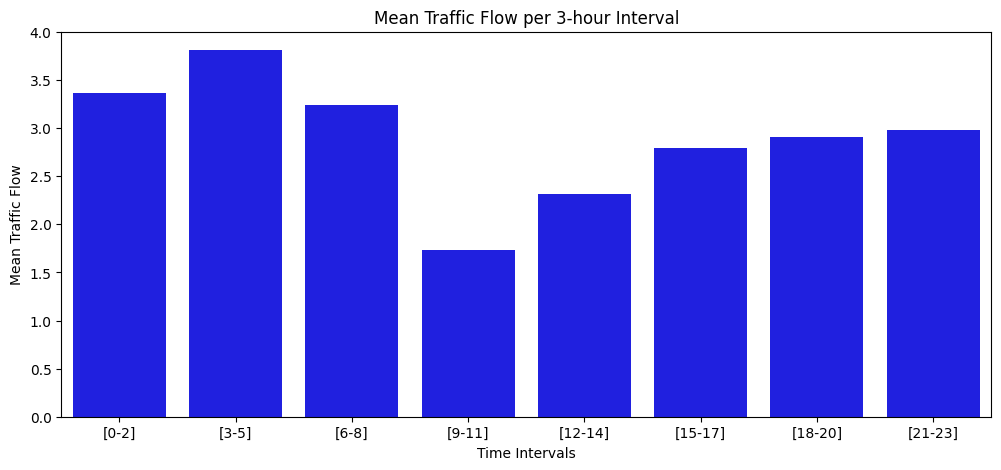

In [12]:
# Group by 3hour_interval and calculate the mean of the traffic flow
grouped_df = traffic_flow['Traffic Flow'].groupby(traffic_flow['3hour_interval']).mean()

# Add results to dataframe
grouped_df = pd.DataFrame(grouped_df,index=grouped_df.index)

# Define the intervals (use strings for easy understanding)
intervals = ['[0-2]','[3-5]','[6-8]','[9-11]','[12-14]','[15-17]','[18-20]','[21-23]']
grouped_df['Hour Interval'] = intervals

# Create a plot to view the results
plt.figure(figsize=(12,5))
sns.barplot(grouped_df, x='Hour Interval', y='Traffic Flow', color='blue')
plt.xlabel('Time Intervals')
plt.ylabel('Mean Traffic Flow')
plt.title('Mean Traffic Flow per 3-hour Interval')

# Show graph
plt.show()

The graph suggests that traffic flow peaks during morning and evening hours, while it tends to be lower during noon.

Text(0.5, 1.0, 'Mean Traffic Flow per Day of Week')

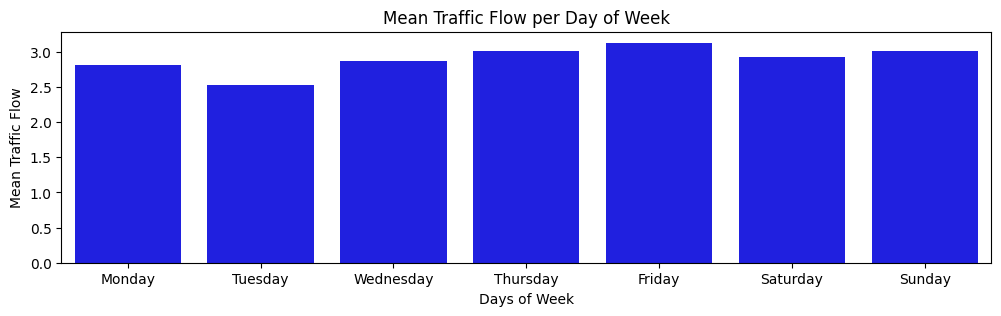

In [13]:
# Group by dayofweek and calculate the mean of the traffic flow
grouped_df = pd.DataFrame(traffic_flow['Traffic Flow'].groupby(traffic_flow['dayofweek']).mean())
grouped_df['Days'] = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

# Create a plot to view the results
plt.figure(figsize=(12,3))
sns.barplot(grouped_df,x='Days',y='Traffic Flow',color='blue')
plt.xlabel('Days of Week')
plt.ylabel('Mean Traffic Flow')
plt.title('Mean Traffic Flow per Day of Week')

Text(0.5, 1.0, 'Mean Traffic Flow during  Memorial Day (26th of May 2008)')

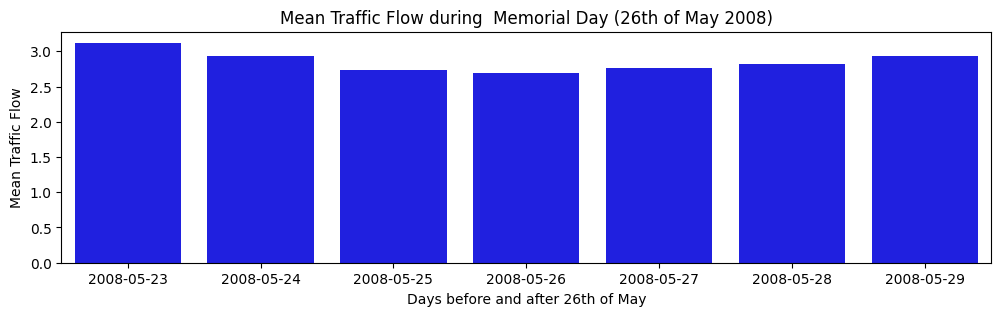

In [14]:
# Select data within the specified date range
select_data = traffic_flow[(traffic_flow['Time Column'] >= '2008-05-23') & (traffic_flow['Time Column'] < '2008-05-30')]
# Extract the date portion from the 'Time Column' and create a new 'Date' column
select_data['Date'] = select_data['Time Column'].dt.date
# Create a DataFrame by grouping 'Traffic Flow' by 'Date' and calculating the sum
select_data = pd.DataFrame(select_data['Traffic Flow'].groupby(select_data['Date']).mean())

# Create a plot to visualize the results
plt.figure(figsize=(12, 3))  # Set the size of the plot figure
sns.barplot(data=select_data, x=select_data.index, y='Traffic Flow',color='blue')
plt.xlabel('Days before and after 26th of May')
plt.ylabel('Mean Traffic Flow')
plt.title('Mean Traffic Flow during  Memorial Day (26th of May 2008)')

According to the calendar, Memorial Day in the United States fell on May 26, 2008. The graph above indicates that on this particular day, there was a decrease in traffic flow, while the subsequent days showed higher traffic flow.

On Memorial Day, many businesses are closed, schools may be out, and people often take the opportunity to engage in various leisure activities or travel. As a result, there tends to be a decrease in local commuting and traffic flow on that specific day compared to the surrounding days.

<Axes: >

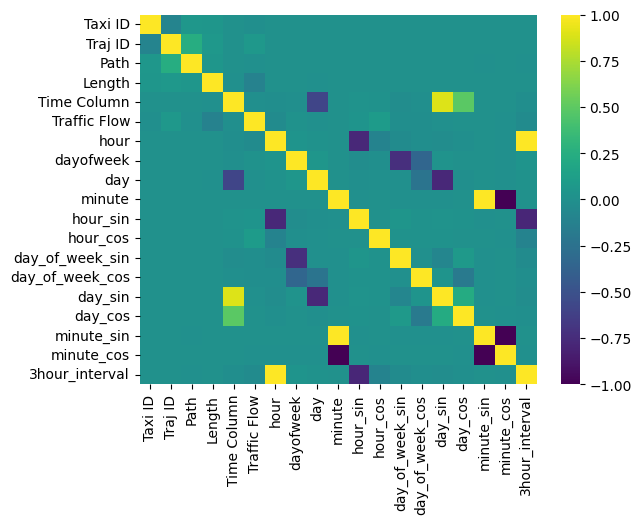

In [15]:
# Use a correlation matrix to show correlations among attributes in the dataset
sns.heatmap(traffic_flow.corr(),cmap='viridis')

In [16]:
# Define a list with the items to be removed
removable_items = ['Record 1(t)', 'Time Column', 'Traffic Flow', 'hour', 'dayofweek', 'day', 'minute']

#### **Find the Optimum Sliding Window Length**

In [17]:
# Sort the time series data
traffic_flow.sort_values(by=['Path','Time Column'], inplace=True)

In [18]:
# Import libraries to use XGBoost model
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [19]:
# Import libraries to use the LSTM Neural Network algorithm
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import tensorflow as tf

# Min Max Scaler
from sklearn.preprocessing import MinMaxScaler

2024-01-23 13:35:41.507636: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
# Use Regression Evaluation Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

**Create function that converts the data into a supervised problem**

Consider for each path n_in timesteps of observations in the past, in order to predict the n_out timesteps in the future.

In [21]:
def series_to_supervised(data, n_in=1, n_out=1):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('Record %d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # Generate sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('Record %d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('Record %d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

def generate_X_y_pairs(data, n_in=1, n_out=1):
    """
    Convert the training data into a supervised dataset. Create X,y pairs of the traffic column information.
    Then, concatenate the rest of the columns.
    """
    new_data = pd.DataFrame()

    # Iterate over unique values in the 'Path' column
    for item in data['Path'].unique():
        # Call function only for the 'Traffic Flow' column
        supervised_traffic_flow = series_to_supervised(pd.DataFrame(data[data['Path'] == item]['Traffic Flow']), n_in, n_out)

        # Concatenate the rest of the columns
        supervised_traffic_flow = pd.concat([supervised_traffic_flow, traffic_flow[traffic_flow['Path'] == item]], axis=1)

        new_data = pd.concat([new_data, supervised_traffic_flow])

    # Drop rows with NaN values
    new_data.dropna(inplace=True)
    return new_data

##### Sliding Window Length Equals to 2

In [22]:
# Define Window Length
lookback = 2

In [23]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-06-03']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-06-03']

In [24]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, lookback)
test = generate_X_y_pairs(test, lookback)

In [25]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:lookback].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:lookback].var(axis=1)

In [26]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [27]:
# Import Grid Search library
from sklearn.model_selection import GridSearchCV

In [28]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:5.06844	validation_1-rmse:5.11979
[1]	validation_0-rmse:4.68918	validation_1-rmse:4.74001
[2]	validation_0-rmse:4.35719	validation_1-rmse:4.40649
[3]	validation_0-rmse:4.06633	validation_1-rmse:4.11547
[4]	validation_0-rmse:3.81232	validation_1-rmse:3.86003
[5]	validation_0-rmse:3.60291	validation_1-rmse:3.65055
[6]	validation_0-rmse:3.41289	validation_1-rmse:3.45979
[7]	validation_0-rmse:3.24880	validation_1-rmse:3.29516
[8]	validation_0-rmse:3.10726	validation_1-rmse:3.15255
[9]	validation_0-rmse:2.99233	validation_1-rmse:3.03679
[10]	validation_0-rmse:2.88976	validation_1-rmse:2.93215
[11]	validation_0-rmse:2.80792	validation_1-rmse:2.84971
[12]	validation_0-rmse:2.73949	validation_1-rmse:2.78069
[13]	validation_0-rmse:2.68219	validation_1-rmse:2.72310
[14]	validation_0-rmse:2.63029	validation_1-rmse:2.66925
[15]	validation_0-rmse:2.58917	validation_1-rmse:2.62731
[16]	validation_0-rmse:2.55475	validation_1-rmse:2.59260
[17]	validation_0-rmse:2.52729	validation

[16]	validation_0-rmse:2.49192	validation_1-rmse:2.53267
[17]	validation_0-rmse:2.46502	validation_1-rmse:2.50656
[18]	validation_0-rmse:2.44273	validation_1-rmse:2.48565
[19]	validation_0-rmse:2.42419	validation_1-rmse:2.46740
[20]	validation_0-rmse:2.40790	validation_1-rmse:2.45208
[21]	validation_0-rmse:2.39453	validation_1-rmse:2.43846
[22]	validation_0-rmse:2.38420	validation_1-rmse:2.42818
[23]	validation_0-rmse:2.37584	validation_1-rmse:2.42154
[24]	validation_0-rmse:2.36876	validation_1-rmse:2.41453
[25]	validation_0-rmse:2.36270	validation_1-rmse:2.40866
[26]	validation_0-rmse:2.35777	validation_1-rmse:2.40426
[27]	validation_0-rmse:2.35270	validation_1-rmse:2.39914
[28]	validation_0-rmse:2.34905	validation_1-rmse:2.39563
[29]	validation_0-rmse:2.34687	validation_1-rmse:2.39380
[30]	validation_0-rmse:2.34341	validation_1-rmse:2.39092
[31]	validation_0-rmse:2.34107	validation_1-rmse:2.38853
[32]	validation_0-rmse:2.33896	validation_1-rmse:2.38941
[33]	validation_0-rmse:2.33746	

[17]	validation_0-rmse:2.52211	validation_1-rmse:2.57772
[18]	validation_0-rmse:2.49826	validation_1-rmse:2.55426
[19]	validation_0-rmse:2.47956	validation_1-rmse:2.53659
[20]	validation_0-rmse:2.46164	validation_1-rmse:2.51937
[21]	validation_0-rmse:2.44764	validation_1-rmse:2.50618
[22]	validation_0-rmse:2.43498	validation_1-rmse:2.49498
[23]	validation_0-rmse:2.42387	validation_1-rmse:2.48454
[24]	validation_0-rmse:2.41547	validation_1-rmse:2.47612
[25]	validation_0-rmse:2.40573	validation_1-rmse:2.46626
[26]	validation_0-rmse:2.39713	validation_1-rmse:2.45644
[27]	validation_0-rmse:2.39089	validation_1-rmse:2.45062
[28]	validation_0-rmse:2.38569	validation_1-rmse:2.44607
[29]	validation_0-rmse:2.38213	validation_1-rmse:2.44310
[30]	validation_0-rmse:2.37653	validation_1-rmse:2.43634
[31]	validation_0-rmse:2.37376	validation_1-rmse:2.43354
[32]	validation_0-rmse:2.37135	validation_1-rmse:2.43140
[33]	validation_0-rmse:2.36828	validation_1-rmse:2.42852
[34]	validation_0-rmse:2.36425	

[31]	validation_0-rmse:2.37041	validation_1-rmse:2.40292
[32]	validation_0-rmse:2.36611	validation_1-rmse:2.39759
[33]	validation_0-rmse:2.36262	validation_1-rmse:2.39375
[34]	validation_0-rmse:2.35957	validation_1-rmse:2.39074
[35]	validation_0-rmse:2.35753	validation_1-rmse:2.38985
[36]	validation_0-rmse:2.35486	validation_1-rmse:2.38678
[37]	validation_0-rmse:2.35427	validation_1-rmse:2.38539
[38]	validation_0-rmse:2.35173	validation_1-rmse:2.38288
[39]	validation_0-rmse:2.35015	validation_1-rmse:2.38160
[40]	validation_0-rmse:2.34909	validation_1-rmse:2.37925
[41]	validation_0-rmse:2.34793	validation_1-rmse:2.37726
[42]	validation_0-rmse:2.34693	validation_1-rmse:2.37675
[43]	validation_0-rmse:2.34586	validation_1-rmse:2.37597
[44]	validation_0-rmse:2.34586	validation_1-rmse:2.37548
[45]	validation_0-rmse:2.34389	validation_1-rmse:2.37330
[46]	validation_0-rmse:2.34339	validation_1-rmse:2.37234
[47]	validation_0-rmse:2.34244	validation_1-rmse:2.37204
[48]	validation_0-rmse:2.34142	

[27]	validation_0-rmse:2.35270	validation_1-rmse:2.39914
[28]	validation_0-rmse:2.34906	validation_1-rmse:2.39563
[29]	validation_0-rmse:2.34688	validation_1-rmse:2.39380
[30]	validation_0-rmse:2.34342	validation_1-rmse:2.39092
[31]	validation_0-rmse:2.34108	validation_1-rmse:2.38853
[32]	validation_0-rmse:2.33897	validation_1-rmse:2.38941
[33]	validation_0-rmse:2.33746	validation_1-rmse:2.38718
[34]	validation_0-rmse:2.33584	validation_1-rmse:2.38582
[35]	validation_0-rmse:2.33441	validation_1-rmse:2.38486
[36]	validation_0-rmse:2.33249	validation_1-rmse:2.38336
[37]	validation_0-rmse:2.33236	validation_1-rmse:2.38492
[38]	validation_0-rmse:2.33171	validation_1-rmse:2.38378
[39]	validation_0-rmse:2.32997	validation_1-rmse:2.38228
[40]	validation_0-rmse:2.32799	validation_1-rmse:2.38179
[41]	validation_0-rmse:2.32648	validation_1-rmse:2.38074
[42]	validation_0-rmse:2.32531	validation_1-rmse:2.38030
[43]	validation_0-rmse:2.32317	validation_1-rmse:2.37863
[44]	validation_0-rmse:2.32224	

[27]	validation_0-rmse:2.39090	validation_1-rmse:2.45064
[28]	validation_0-rmse:2.38570	validation_1-rmse:2.44608
[29]	validation_0-rmse:2.38214	validation_1-rmse:2.44311
[30]	validation_0-rmse:2.37654	validation_1-rmse:2.43635
[31]	validation_0-rmse:2.37378	validation_1-rmse:2.43355
[32]	validation_0-rmse:2.37136	validation_1-rmse:2.43141
[33]	validation_0-rmse:2.36829	validation_1-rmse:2.42853
[34]	validation_0-rmse:2.36427	validation_1-rmse:2.42476
[35]	validation_0-rmse:2.36166	validation_1-rmse:2.42280
[36]	validation_0-rmse:2.35884	validation_1-rmse:2.41907
[37]	validation_0-rmse:2.35674	validation_1-rmse:2.41751
[38]	validation_0-rmse:2.35484	validation_1-rmse:2.41688
[39]	validation_0-rmse:2.35316	validation_1-rmse:2.41484
[40]	validation_0-rmse:2.35143	validation_1-rmse:2.41343
[41]	validation_0-rmse:2.34952	validation_1-rmse:2.41198
[42]	validation_0-rmse:2.34766	validation_1-rmse:2.41032
[43]	validation_0-rmse:2.34632	validation_1-rmse:2.40949
[44]	validation_0-rmse:2.34523	

[41]	validation_0-rmse:2.26829	validation_1-rmse:2.36430
[42]	validation_0-rmse:2.26476	validation_1-rmse:2.36265
[43]	validation_0-rmse:2.26206	validation_1-rmse:2.36131
[44]	validation_0-rmse:2.26014	validation_1-rmse:2.35993
[45]	validation_0-rmse:2.25785	validation_1-rmse:2.35882
[46]	validation_0-rmse:2.25541	validation_1-rmse:2.35906
[47]	validation_0-rmse:2.25666	validation_1-rmse:2.36174
[48]	validation_0-rmse:2.25642	validation_1-rmse:2.36275
[49]	validation_0-rmse:2.25634	validation_1-rmse:2.36514
[0]	validation_0-rmse:5.06570	validation_1-rmse:5.11946
[1]	validation_0-rmse:4.68451	validation_1-rmse:4.74054
[2]	validation_0-rmse:4.35447	validation_1-rmse:4.41305
[3]	validation_0-rmse:4.06099	validation_1-rmse:4.11982
[4]	validation_0-rmse:3.80809	validation_1-rmse:3.86884
[5]	validation_0-rmse:3.58923	validation_1-rmse:3.65342
[6]	validation_0-rmse:3.40164	validation_1-rmse:3.46727
[7]	validation_0-rmse:3.23774	validation_1-rmse:3.30487
[8]	validation_0-rmse:3.09358	validatio

[12]	validation_0-rmse:2.71877	validation_1-rmse:2.81329
[13]	validation_0-rmse:2.65609	validation_1-rmse:2.75081
[14]	validation_0-rmse:2.59976	validation_1-rmse:2.69433
[15]	validation_0-rmse:2.55478	validation_1-rmse:2.65225
[16]	validation_0-rmse:2.51577	validation_1-rmse:2.61405
[17]	validation_0-rmse:2.48267	validation_1-rmse:2.58443
[18]	validation_0-rmse:2.45487	validation_1-rmse:2.55942
[19]	validation_0-rmse:2.42777	validation_1-rmse:2.53494
[20]	validation_0-rmse:2.40867	validation_1-rmse:2.51826
[21]	validation_0-rmse:2.38807	validation_1-rmse:2.49888
[22]	validation_0-rmse:2.37291	validation_1-rmse:2.48383
[23]	validation_0-rmse:2.36237	validation_1-rmse:2.47481
[24]	validation_0-rmse:2.35083	validation_1-rmse:2.46374
[25]	validation_0-rmse:2.33854	validation_1-rmse:2.45306
[26]	validation_0-rmse:2.33221	validation_1-rmse:2.44931
[27]	validation_0-rmse:2.32410	validation_1-rmse:2.44276
[28]	validation_0-rmse:2.31660	validation_1-rmse:2.43642
[29]	validation_0-rmse:2.31149	

[16]	validation_0-rmse:2.51181	validation_1-rmse:2.60780
[17]	validation_0-rmse:2.47690	validation_1-rmse:2.57458
[18]	validation_0-rmse:2.45176	validation_1-rmse:2.55327
[19]	validation_0-rmse:2.42749	validation_1-rmse:2.53236
[20]	validation_0-rmse:2.40530	validation_1-rmse:2.51176
[21]	validation_0-rmse:2.38539	validation_1-rmse:2.49190
[22]	validation_0-rmse:2.36878	validation_1-rmse:2.47776
[23]	validation_0-rmse:2.35390	validation_1-rmse:2.46457
[24]	validation_0-rmse:2.34188	validation_1-rmse:2.45429
[25]	validation_0-rmse:2.33254	validation_1-rmse:2.44763
[26]	validation_0-rmse:2.32275	validation_1-rmse:2.43954
[27]	validation_0-rmse:2.31538	validation_1-rmse:2.43378
[28]	validation_0-rmse:2.30848	validation_1-rmse:2.42832
[29]	validation_0-rmse:2.30684	validation_1-rmse:2.42841
[30]	validation_0-rmse:2.30102	validation_1-rmse:2.42469
[31]	validation_0-rmse:2.29794	validation_1-rmse:2.42321
[32]	validation_0-rmse:2.29148	validation_1-rmse:2.41923
[33]	validation_0-rmse:2.28686	

[38]	validation_0-rmse:2.27628	validation_1-rmse:2.41569
[39]	validation_0-rmse:2.27320	validation_1-rmse:2.41442
[40]	validation_0-rmse:2.27130	validation_1-rmse:2.41418
[41]	validation_0-rmse:2.26750	validation_1-rmse:2.41120
[42]	validation_0-rmse:2.26454	validation_1-rmse:2.40992
[43]	validation_0-rmse:2.26037	validation_1-rmse:2.40762
[44]	validation_0-rmse:2.26777	validation_1-rmse:2.41814
[45]	validation_0-rmse:2.26880	validation_1-rmse:2.42234
[46]	validation_0-rmse:2.26727	validation_1-rmse:2.42324
[47]	validation_0-rmse:2.26615	validation_1-rmse:2.42375
[0]	validation_0-rmse:5.04866	validation_1-rmse:5.09741
[1]	validation_0-rmse:4.65335	validation_1-rmse:4.70502
[2]	validation_0-rmse:4.30121	validation_1-rmse:4.35189
[3]	validation_0-rmse:3.99458	validation_1-rmse:4.04718
[4]	validation_0-rmse:3.72923	validation_1-rmse:3.78475
[5]	validation_0-rmse:3.49837	validation_1-rmse:3.55536
[6]	validation_0-rmse:3.30017	validation_1-rmse:3.35766
[7]	validation_0-rmse:3.13201	validati

[6]	validation_0-rmse:3.38117	validation_1-rmse:3.49122
[7]	validation_0-rmse:3.20900	validation_1-rmse:3.32662
[8]	validation_0-rmse:3.05866	validation_1-rmse:3.18305
[9]	validation_0-rmse:2.92864	validation_1-rmse:3.05858
[10]	validation_0-rmse:2.81721	validation_1-rmse:2.95685
[11]	validation_0-rmse:2.72854	validation_1-rmse:2.87400
[12]	validation_0-rmse:2.64369	validation_1-rmse:2.79993
[13]	validation_0-rmse:2.57719	validation_1-rmse:2.73922
[14]	validation_0-rmse:2.51805	validation_1-rmse:2.68736
[15]	validation_0-rmse:2.46758	validation_1-rmse:2.64458
[16]	validation_0-rmse:2.42133	validation_1-rmse:2.60893
[17]	validation_0-rmse:2.38484	validation_1-rmse:2.57740
[18]	validation_0-rmse:2.35206	validation_1-rmse:2.55504
[19]	validation_0-rmse:2.32336	validation_1-rmse:2.53318
[20]	validation_0-rmse:2.29643	validation_1-rmse:2.51424
[21]	validation_0-rmse:2.27995	validation_1-rmse:2.50301
[22]	validation_0-rmse:2.25961	validation_1-rmse:2.49069
[23]	validation_0-rmse:2.24431	vali

[24]	validation_0-rmse:2.25174	validation_1-rmse:2.52739
[25]	validation_0-rmse:2.24164	validation_1-rmse:2.52284
[26]	validation_0-rmse:2.22741	validation_1-rmse:2.51777
[27]	validation_0-rmse:2.21861	validation_1-rmse:2.51686
[28]	validation_0-rmse:2.21065	validation_1-rmse:2.51417
[29]	validation_0-rmse:2.20351	validation_1-rmse:2.51401
[30]	validation_0-rmse:2.19328	validation_1-rmse:2.51017
[31]	validation_0-rmse:2.18759	validation_1-rmse:2.50822
[32]	validation_0-rmse:2.18356	validation_1-rmse:2.51082
[33]	validation_0-rmse:2.17797	validation_1-rmse:2.51082
[34]	validation_0-rmse:2.17480	validation_1-rmse:2.51204
[35]	validation_0-rmse:2.17178	validation_1-rmse:2.51823
[36]	validation_0-rmse:2.16751	validation_1-rmse:2.52157
[0]	validation_0-rmse:5.05556	validation_1-rmse:5.11746
[1]	validation_0-rmse:4.67183	validation_1-rmse:4.74552
[2]	validation_0-rmse:4.32846	validation_1-rmse:4.41674
[3]	validation_0-rmse:4.02871	validation_1-rmse:4.12740
[4]	validation_0-rmse:3.77001	valid

[25]	validation_0-rmse:2.23441	validation_1-rmse:2.49068
[26]	validation_0-rmse:2.22219	validation_1-rmse:2.48191
[27]	validation_0-rmse:2.20950	validation_1-rmse:2.47295
[28]	validation_0-rmse:2.19776	validation_1-rmse:2.46588
[29]	validation_0-rmse:2.18825	validation_1-rmse:2.46264
[30]	validation_0-rmse:2.17745	validation_1-rmse:2.45659
[31]	validation_0-rmse:2.16781	validation_1-rmse:2.45198
[32]	validation_0-rmse:2.16130	validation_1-rmse:2.44925
[33]	validation_0-rmse:2.15429	validation_1-rmse:2.44703
[34]	validation_0-rmse:2.14941	validation_1-rmse:2.44495
[35]	validation_0-rmse:2.14380	validation_1-rmse:2.44393
[36]	validation_0-rmse:2.13874	validation_1-rmse:2.44260
[37]	validation_0-rmse:2.13243	validation_1-rmse:2.44124
[38]	validation_0-rmse:2.12713	validation_1-rmse:2.44074
[39]	validation_0-rmse:2.12313	validation_1-rmse:2.43991
[40]	validation_0-rmse:2.11853	validation_1-rmse:2.43844
[41]	validation_0-rmse:2.11601	validation_1-rmse:2.43843
[42]	validation_0-rmse:2.11336	

[6]	validation_0-rmse:3.40667	validation_1-rmse:3.45417
[7]	validation_0-rmse:3.25137	validation_1-rmse:3.30257
[8]	validation_0-rmse:3.10978	validation_1-rmse:3.16055
[9]	validation_0-rmse:2.99599	validation_1-rmse:3.04882
[10]	validation_0-rmse:2.89419	validation_1-rmse:2.94722
[11]	validation_0-rmse:2.81310	validation_1-rmse:2.86678
[12]	validation_0-rmse:2.73932	validation_1-rmse:2.79255
[13]	validation_0-rmse:2.68302	validation_1-rmse:2.73824
[14]	validation_0-rmse:2.63090	validation_1-rmse:2.68598
[15]	validation_0-rmse:2.59120	validation_1-rmse:2.64730
[16]	validation_0-rmse:2.55753	validation_1-rmse:2.61393
[17]	validation_0-rmse:2.52530	validation_1-rmse:2.58067
[18]	validation_0-rmse:2.50146	validation_1-rmse:2.55821
[19]	validation_0-rmse:2.48047	validation_1-rmse:2.53808
[20]	validation_0-rmse:2.46160	validation_1-rmse:2.52048
[21]	validation_0-rmse:2.44637	validation_1-rmse:2.50589
[22]	validation_0-rmse:2.43310	validation_1-rmse:2.49331
[23]	validation_0-rmse:2.42054	vali

[35]	validation_0-rmse:2.35521	validation_1-rmse:2.38864
[36]	validation_0-rmse:2.35368	validation_1-rmse:2.38561
[37]	validation_0-rmse:2.35276	validation_1-rmse:2.38394
[38]	validation_0-rmse:2.35079	validation_1-rmse:2.38234
[39]	validation_0-rmse:2.34967	validation_1-rmse:2.38019
[40]	validation_0-rmse:2.34817	validation_1-rmse:2.37938
[41]	validation_0-rmse:2.34684	validation_1-rmse:2.37822
[42]	validation_0-rmse:2.34502	validation_1-rmse:2.37620
[43]	validation_0-rmse:2.34176	validation_1-rmse:2.37305
[44]	validation_0-rmse:2.34124	validation_1-rmse:2.37197
[45]	validation_0-rmse:2.33994	validation_1-rmse:2.37025
[46]	validation_0-rmse:2.33942	validation_1-rmse:2.36993
[47]	validation_0-rmse:2.33738	validation_1-rmse:2.36842
[48]	validation_0-rmse:2.33843	validation_1-rmse:2.36850
[49]	validation_0-rmse:2.33708	validation_1-rmse:2.36723
[50]	validation_0-rmse:2.33643	validation_1-rmse:2.36672
[51]	validation_0-rmse:2.33586	validation_1-rmse:2.36655
[52]	validation_0-rmse:2.33522	

[50]	validation_0-rmse:2.31684	validation_1-rmse:2.37302
[51]	validation_0-rmse:2.31566	validation_1-rmse:2.37148
[52]	validation_0-rmse:2.31480	validation_1-rmse:2.37250
[53]	validation_0-rmse:2.31412	validation_1-rmse:2.37206
[54]	validation_0-rmse:2.31300	validation_1-rmse:2.37119
[55]	validation_0-rmse:2.31187	validation_1-rmse:2.37025
[56]	validation_0-rmse:2.31129	validation_1-rmse:2.36883
[57]	validation_0-rmse:2.31055	validation_1-rmse:2.36864
[58]	validation_0-rmse:2.30966	validation_1-rmse:2.36787
[59]	validation_0-rmse:2.30952	validation_1-rmse:2.36760
[60]	validation_0-rmse:2.30885	validation_1-rmse:2.36713
[61]	validation_0-rmse:2.30839	validation_1-rmse:2.36666
[62]	validation_0-rmse:2.30749	validation_1-rmse:2.36567
[63]	validation_0-rmse:2.30677	validation_1-rmse:2.36550
[64]	validation_0-rmse:2.30674	validation_1-rmse:2.36539
[65]	validation_0-rmse:2.30627	validation_1-rmse:2.36528
[66]	validation_0-rmse:2.30598	validation_1-rmse:2.36517
[67]	validation_0-rmse:2.30514	

[16]	validation_0-rmse:2.55754	validation_1-rmse:2.61395
[17]	validation_0-rmse:2.52532	validation_1-rmse:2.58068
[18]	validation_0-rmse:2.50147	validation_1-rmse:2.55822
[19]	validation_0-rmse:2.48048	validation_1-rmse:2.53809
[20]	validation_0-rmse:2.46162	validation_1-rmse:2.52049
[21]	validation_0-rmse:2.44638	validation_1-rmse:2.50590
[22]	validation_0-rmse:2.43311	validation_1-rmse:2.49333
[23]	validation_0-rmse:2.42055	validation_1-rmse:2.47871
[24]	validation_0-rmse:2.41089	validation_1-rmse:2.46949
[25]	validation_0-rmse:2.40396	validation_1-rmse:2.46298
[26]	validation_0-rmse:2.39683	validation_1-rmse:2.45480
[27]	validation_0-rmse:2.39109	validation_1-rmse:2.44979
[28]	validation_0-rmse:2.38539	validation_1-rmse:2.44474
[29]	validation_0-rmse:2.37954	validation_1-rmse:2.43867
[30]	validation_0-rmse:2.37590	validation_1-rmse:2.43411
[31]	validation_0-rmse:2.37145	validation_1-rmse:2.42953
[32]	validation_0-rmse:2.36779	validation_1-rmse:2.42631
[33]	validation_0-rmse:2.36605	

[46]	validation_0-rmse:2.33942	validation_1-rmse:2.36994
[47]	validation_0-rmse:2.33738	validation_1-rmse:2.36844
[48]	validation_0-rmse:2.33843	validation_1-rmse:2.36851
[49]	validation_0-rmse:2.33708	validation_1-rmse:2.36725
[50]	validation_0-rmse:2.33642	validation_1-rmse:2.36674
[51]	validation_0-rmse:2.33586	validation_1-rmse:2.36656
[52]	validation_0-rmse:2.33521	validation_1-rmse:2.36629
[53]	validation_0-rmse:2.33457	validation_1-rmse:2.36579
[54]	validation_0-rmse:2.33348	validation_1-rmse:2.36498
[55]	validation_0-rmse:2.33376	validation_1-rmse:2.36530
[56]	validation_0-rmse:2.33278	validation_1-rmse:2.36393
[57]	validation_0-rmse:2.33220	validation_1-rmse:2.36344
[58]	validation_0-rmse:2.33155	validation_1-rmse:2.36265
[59]	validation_0-rmse:2.33211	validation_1-rmse:2.36329
[60]	validation_0-rmse:2.33158	validation_1-rmse:2.36271
[61]	validation_0-rmse:2.33126	validation_1-rmse:2.36286
[62]	validation_0-rmse:2.33093	validation_1-rmse:2.36234
[63]	validation_0-rmse:2.33113	

[61]	validation_0-rmse:2.30842	validation_1-rmse:2.36667
[62]	validation_0-rmse:2.30751	validation_1-rmse:2.36569
[63]	validation_0-rmse:2.30679	validation_1-rmse:2.36550
[64]	validation_0-rmse:2.30676	validation_1-rmse:2.36540
[65]	validation_0-rmse:2.30629	validation_1-rmse:2.36529
[66]	validation_0-rmse:2.30600	validation_1-rmse:2.36518
[67]	validation_0-rmse:2.30516	validation_1-rmse:2.36441
[68]	validation_0-rmse:2.30477	validation_1-rmse:2.36392
[69]	validation_0-rmse:2.30403	validation_1-rmse:2.36325
[70]	validation_0-rmse:2.30366	validation_1-rmse:2.36295
[71]	validation_0-rmse:2.30255	validation_1-rmse:2.36207
[72]	validation_0-rmse:2.30226	validation_1-rmse:2.36194
[73]	validation_0-rmse:2.30213	validation_1-rmse:2.36192
[74]	validation_0-rmse:2.30152	validation_1-rmse:2.36212
[75]	validation_0-rmse:2.30117	validation_1-rmse:2.36245
[76]	validation_0-rmse:2.30086	validation_1-rmse:2.36281
[77]	validation_0-rmse:2.30035	validation_1-rmse:2.36376
[78]	validation_0-rmse:2.29890	

[7]	validation_0-rmse:3.22061	validation_1-rmse:3.28666
[8]	validation_0-rmse:3.08096	validation_1-rmse:3.14815
[9]	validation_0-rmse:2.96480	validation_1-rmse:3.03255
[10]	validation_0-rmse:2.86900	validation_1-rmse:2.93651
[11]	validation_0-rmse:2.78064	validation_1-rmse:2.84893
[12]	validation_0-rmse:2.71715	validation_1-rmse:2.78461
[13]	validation_0-rmse:2.65412	validation_1-rmse:2.72063
[14]	validation_0-rmse:2.60392	validation_1-rmse:2.67036
[15]	validation_0-rmse:2.55492	validation_1-rmse:2.62213
[16]	validation_0-rmse:2.51728	validation_1-rmse:2.58324
[17]	validation_0-rmse:2.48500	validation_1-rmse:2.55249
[18]	validation_0-rmse:2.45526	validation_1-rmse:2.52283
[19]	validation_0-rmse:2.42938	validation_1-rmse:2.49784
[20]	validation_0-rmse:2.40847	validation_1-rmse:2.47754
[21]	validation_0-rmse:2.39201	validation_1-rmse:2.46133
[22]	validation_0-rmse:2.37688	validation_1-rmse:2.44782
[23]	validation_0-rmse:2.36573	validation_1-rmse:2.43754
[24]	validation_0-rmse:2.35440	val

[9]	validation_0-rmse:2.94849	validation_1-rmse:3.00998
[10]	validation_0-rmse:2.84576	validation_1-rmse:2.91173
[11]	validation_0-rmse:2.76046	validation_1-rmse:2.82851
[12]	validation_0-rmse:2.68923	validation_1-rmse:2.75856
[13]	validation_0-rmse:2.62783	validation_1-rmse:2.69849
[14]	validation_0-rmse:2.57559	validation_1-rmse:2.64816
[15]	validation_0-rmse:2.53078	validation_1-rmse:2.60566
[16]	validation_0-rmse:2.49335	validation_1-rmse:2.56823
[17]	validation_0-rmse:2.45956	validation_1-rmse:2.53724
[18]	validation_0-rmse:2.43243	validation_1-rmse:2.51178
[19]	validation_0-rmse:2.40766	validation_1-rmse:2.48998
[20]	validation_0-rmse:2.38866	validation_1-rmse:2.47168
[21]	validation_0-rmse:2.37696	validation_1-rmse:2.45968
[22]	validation_0-rmse:2.36105	validation_1-rmse:2.44449
[23]	validation_0-rmse:2.34856	validation_1-rmse:2.43135
[24]	validation_0-rmse:2.33903	validation_1-rmse:2.42324
[25]	validation_0-rmse:2.33152	validation_1-rmse:2.41553
[26]	validation_0-rmse:2.32309	v

[32]	validation_0-rmse:2.29821	validation_1-rmse:2.38314
[33]	validation_0-rmse:2.29494	validation_1-rmse:2.37925
[34]	validation_0-rmse:2.29170	validation_1-rmse:2.37864
[35]	validation_0-rmse:2.28536	validation_1-rmse:2.37467
[36]	validation_0-rmse:2.27995	validation_1-rmse:2.37165
[37]	validation_0-rmse:2.27545	validation_1-rmse:2.36950
[38]	validation_0-rmse:2.27300	validation_1-rmse:2.36859
[39]	validation_0-rmse:2.27038	validation_1-rmse:2.36584
[40]	validation_0-rmse:2.26678	validation_1-rmse:2.36358
[41]	validation_0-rmse:2.26424	validation_1-rmse:2.36246
[42]	validation_0-rmse:2.26276	validation_1-rmse:2.36239
[43]	validation_0-rmse:2.26066	validation_1-rmse:2.36110
[44]	validation_0-rmse:2.25868	validation_1-rmse:2.35896
[45]	validation_0-rmse:2.25655	validation_1-rmse:2.35741
[46]	validation_0-rmse:2.25358	validation_1-rmse:2.35408
[47]	validation_0-rmse:2.25202	validation_1-rmse:2.35573
[48]	validation_0-rmse:2.25054	validation_1-rmse:2.35600
[49]	validation_0-rmse:2.25089	

[7]	validation_0-rmse:3.17086	validation_1-rmse:3.32516
[8]	validation_0-rmse:3.02069	validation_1-rmse:3.18520
[9]	validation_0-rmse:2.89156	validation_1-rmse:3.06919
[10]	validation_0-rmse:2.78088	validation_1-rmse:2.96687
[11]	validation_0-rmse:2.68669	validation_1-rmse:2.88601
[12]	validation_0-rmse:2.60876	validation_1-rmse:2.82005
[13]	validation_0-rmse:2.53979	validation_1-rmse:2.75942
[14]	validation_0-rmse:2.48241	validation_1-rmse:2.71275
[15]	validation_0-rmse:2.43166	validation_1-rmse:2.67078
[16]	validation_0-rmse:2.38676	validation_1-rmse:2.63421
[17]	validation_0-rmse:2.34958	validation_1-rmse:2.60558
[18]	validation_0-rmse:2.31822	validation_1-rmse:2.58188
[19]	validation_0-rmse:2.28718	validation_1-rmse:2.55755
[20]	validation_0-rmse:2.26039	validation_1-rmse:2.53691
[21]	validation_0-rmse:2.23873	validation_1-rmse:2.52204
[22]	validation_0-rmse:2.22010	validation_1-rmse:2.51044
[23]	validation_0-rmse:2.20250	validation_1-rmse:2.49932
[24]	validation_0-rmse:2.18741	val

[0]	validation_0-rmse:5.04414	validation_1-rmse:5.09991
[1]	validation_0-rmse:4.64272	validation_1-rmse:4.70790
[2]	validation_0-rmse:4.28724	validation_1-rmse:4.36142
[3]	validation_0-rmse:3.98239	validation_1-rmse:4.06984
[4]	validation_0-rmse:3.71422	validation_1-rmse:3.81312
[5]	validation_0-rmse:3.47826	validation_1-rmse:3.58546
[6]	validation_0-rmse:3.27518	validation_1-rmse:3.39509
[7]	validation_0-rmse:3.09576	validation_1-rmse:3.23317
[8]	validation_0-rmse:2.94631	validation_1-rmse:3.09645
[9]	validation_0-rmse:2.81613	validation_1-rmse:2.97736
[10]	validation_0-rmse:2.70586	validation_1-rmse:2.88160
[11]	validation_0-rmse:2.61006	validation_1-rmse:2.79278
[12]	validation_0-rmse:2.53011	validation_1-rmse:2.73103
[13]	validation_0-rmse:2.47066	validation_1-rmse:2.68008
[14]	validation_0-rmse:2.42312	validation_1-rmse:2.64343
[15]	validation_0-rmse:2.37800	validation_1-rmse:2.60702
[16]	validation_0-rmse:2.34685	validation_1-rmse:2.58452
[17]	validation_0-rmse:2.31242	validation

[14]	validation_0-rmse:2.51774	validation_1-rmse:2.69549
[15]	validation_0-rmse:2.46889	validation_1-rmse:2.65186
[16]	validation_0-rmse:2.42613	validation_1-rmse:2.61512
[17]	validation_0-rmse:2.38520	validation_1-rmse:2.58352
[18]	validation_0-rmse:2.35123	validation_1-rmse:2.55818
[19]	validation_0-rmse:2.32009	validation_1-rmse:2.53541
[20]	validation_0-rmse:2.29723	validation_1-rmse:2.51721
[21]	validation_0-rmse:2.27482	validation_1-rmse:2.50206
[22]	validation_0-rmse:2.25626	validation_1-rmse:2.48841
[23]	validation_0-rmse:2.23908	validation_1-rmse:2.47722
[24]	validation_0-rmse:2.22510	validation_1-rmse:2.46676
[25]	validation_0-rmse:2.21184	validation_1-rmse:2.46062
[26]	validation_0-rmse:2.20227	validation_1-rmse:2.45775
[27]	validation_0-rmse:2.19133	validation_1-rmse:2.45297
[28]	validation_0-rmse:2.18201	validation_1-rmse:2.45031
[29]	validation_0-rmse:2.17335	validation_1-rmse:2.44592
[30]	validation_0-rmse:2.16607	validation_1-rmse:2.44383
[31]	validation_0-rmse:2.16000	

[34]	validation_0-rmse:2.32773	validation_1-rmse:2.38015
[35]	validation_0-rmse:2.32485	validation_1-rmse:2.37728
[36]	validation_0-rmse:2.32260	validation_1-rmse:2.37542
[37]	validation_0-rmse:2.32033	validation_1-rmse:2.37346
[38]	validation_0-rmse:2.31828	validation_1-rmse:2.37131
[39]	validation_0-rmse:2.31600	validation_1-rmse:2.37045
[40]	validation_0-rmse:2.31445	validation_1-rmse:2.36990
[41]	validation_0-rmse:2.31267	validation_1-rmse:2.36798
[42]	validation_0-rmse:2.31139	validation_1-rmse:2.36620
[43]	validation_0-rmse:2.30968	validation_1-rmse:2.36447
[44]	validation_0-rmse:2.30816	validation_1-rmse:2.36313
[45]	validation_0-rmse:2.30688	validation_1-rmse:2.36226
[46]	validation_0-rmse:2.30587	validation_1-rmse:2.36325
[47]	validation_0-rmse:2.30396	validation_1-rmse:2.36182
[48]	validation_0-rmse:2.30206	validation_1-rmse:2.35897
[49]	validation_0-rmse:2.30022	validation_1-rmse:2.35738
[50]	validation_0-rmse:2.29828	validation_1-rmse:2.35536
[51]	validation_0-rmse:2.29707	

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [29]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)],
        verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Make predictions on the test set

In [30]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

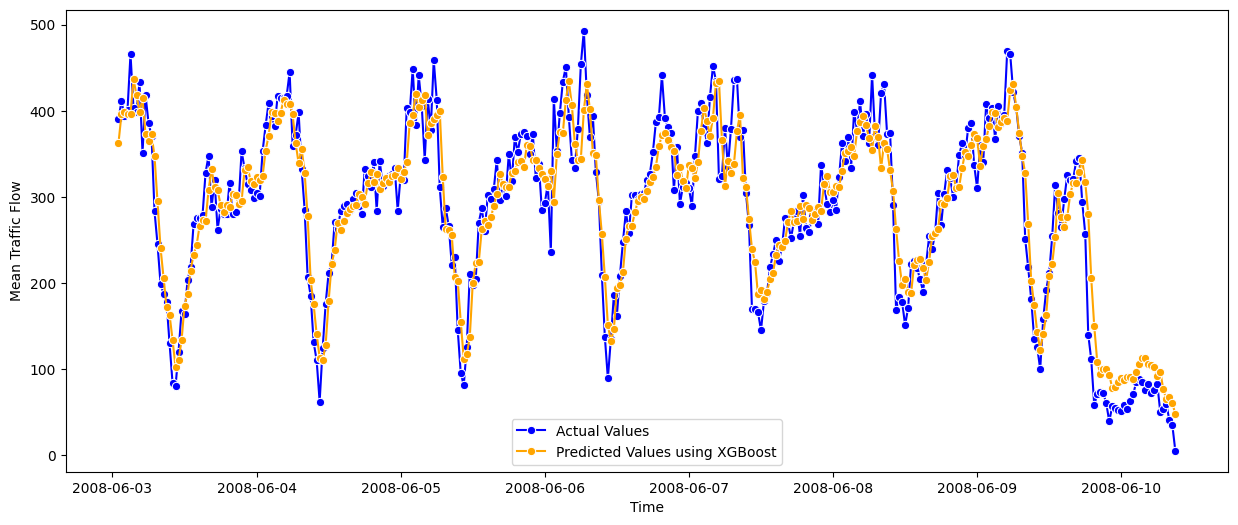

In [31]:
# Select relevant columns from the 'test' DataFrame
select = test[['Time Column','Traffic Flow']]

# Add a new column 'Predictions XGBoost' to the 'select' DataFrame containing the XGBoost predicted values
select['Predictions XGBoost'] = y_pred_xgboost

# Print the average traffic flow on all paths grouped by timestamp
grouped_by_timestamps = select[['Traffic Flow', 'Predictions XGBoost']].groupby(select['Time Column']).sum()
grouped_by_timestamps = pd.DataFrame(grouped_by_timestamps, index=grouped_by_timestamps.index)

# Create a figure
plt.figure(figsize=(15, 6))

# Plotting actual values in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Traffic Flow',
             data=grouped_by_timestamps,
             color='blue', 
             marker='o',
             alpha=1, 
             label='Actual Values')

# Plotting predicted values using LSTM in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Predictions XGBoost',
             data=grouped_by_timestamps,
             color='orange', 
             marker='o',
             alpha=1, 
             label='Predicted Values using XGBoost')

# Set the x-axis label
plt.xlabel('Time')

# Set the y-axis label
plt.ylabel('Mean Traffic Flow')

# Add a legend to the plot
plt.legend(loc='lower center')

# Display the plot
plt.show()

In [32]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.3210484061642251
RMSE score: 2.3245337957503964


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [33]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [34]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [35]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [36]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='linear'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

2024-01-23 13:39:55.753469: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [37]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [38]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 12s 72ms/step - loss: 0.0065 - val_loss: 0.0041
Epoch 2/50
100/100 [==============================] - 6s 65ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 3/50
100/100 [==============================] - 6s 64ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 4/50
100/100 [==============================] - 7s 72ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 5/50
100/100 [==============================] - 6s 61ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 6/50
100/100 [==============================] - 7s 67ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 7/50
100/100 [==============================] - 7s 74ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 8/50
100/100 [==============================] - 7s 70ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 9/50
100/100 [==============================] - 7s 75ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 10/50
100/100 [==============================] - 8s 77ms/step - loss: 0.0018 - val_l

In [39]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

1104/1104 [==============================] - 11s 10ms/step - loss: 0.0012
Test Loss: 0.0011644279584288597


In [40]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

1104/1104 [==============================] - 10s 9ms/step


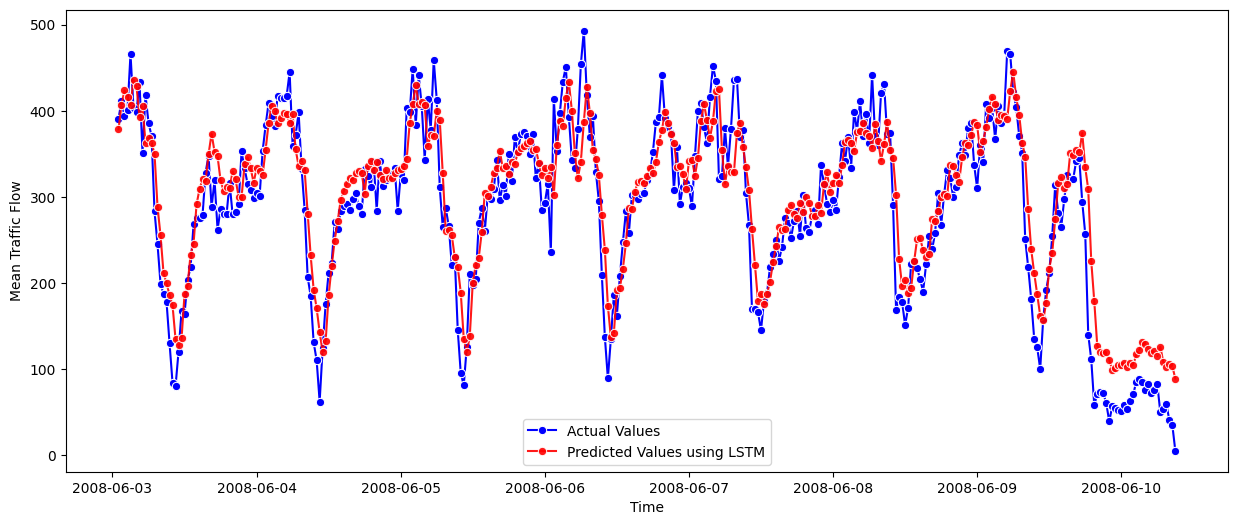

In [41]:
# Select relevant columns from the 'test' DataFrame
select = test[['Time Column','Traffic Flow']]

# Add a new column 'Predictions LSTM' to the 'select' DataFrame containing the LSTM predicted values
select['Predictions LSTM'] = y_pred_lstm

# Print the average traffic flow on all paths grouped by timestamp
grouped_by_timestamps = select[['Traffic Flow', 'Predictions LSTM']].groupby(select['Time Column']).sum()
grouped_by_timestamps = pd.DataFrame(grouped_by_timestamps, index=grouped_by_timestamps.index)

# Create a figure
plt.figure(figsize=(15, 6))

# Plotting actual values in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Traffic Flow',
             data=grouped_by_timestamps,
             color='blue', 
             marker='o',
             alpha=1, 
             label='Actual Values')

# Plotting predicted values using LSTM in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Predictions LSTM',
             data=grouped_by_timestamps,
             color='red', 
             marker='o',
             alpha=0.9, 
             label='Predicted Values using LSTM')

# Set the x-axis label
plt.xlabel('Time')

# Set the y-axis label
plt.ylabel('Mean Traffic Flow')

# Add a legend to the plot
plt.legend(loc='lower center')

# Display the plot
plt.show()

Evaluate the LSTM model

In [42]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  1.4630606219923867
RMSE LSTM score: 2.3886608398279625


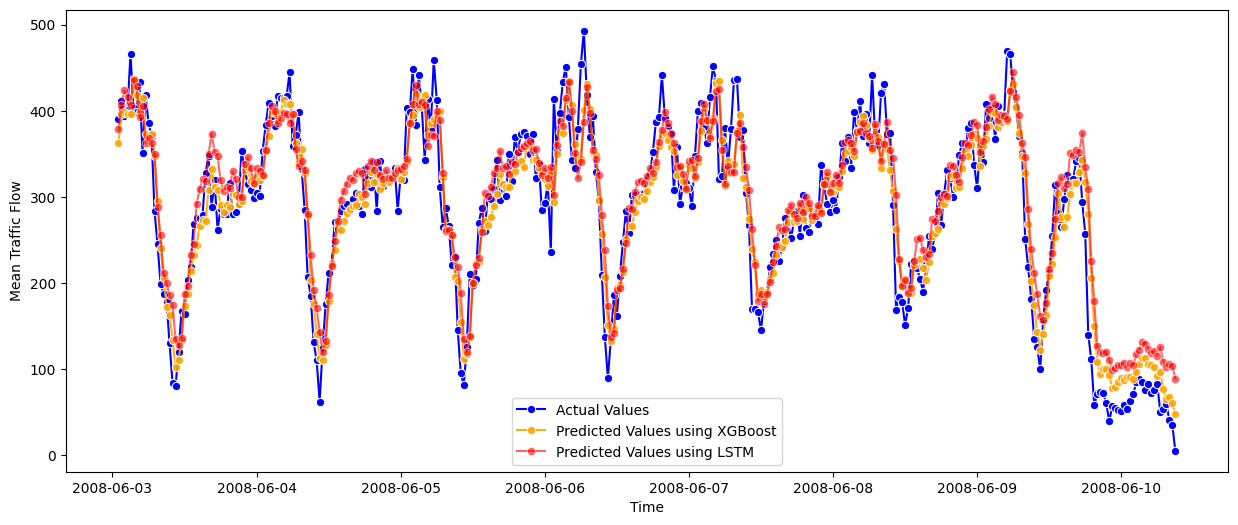

In [43]:
# Select relevant columns from the 'test' DataFrame
select = test[['Time Column','Traffic Flow']]

# Add a new column 'Predictions XGBoost' to the 'select' DataFrame containing the XGBoost predicted values
select['Predictions XGBoost'] = y_pred_xgboost

# Add a new column 'Predictions LSTM' to the 'select' DataFrame containing the LSTM predicted values
select['Predictions LSTM'] = y_pred_lstm

# Print the average traffic flow on all paths grouped by timestamp
grouped_by_timestamps = select[['Traffic Flow', 'Predictions XGBoost', 'Predictions LSTM']].groupby(select['Time Column']).sum()
grouped_by_timestamps = pd.DataFrame(grouped_by_timestamps, index=grouped_by_timestamps.index)

# Create a figure
plt.figure(figsize=(15, 6))

# Plotting actual values in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Traffic Flow',
             data=grouped_by_timestamps,
             color='blue', 
             marker='o',
             alpha=1, 
             label='Actual Values')

# Plotting predicted values using XGBoost in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Predictions XGBoost',
             data=grouped_by_timestamps,
             color='orange', 
             marker='o',
             alpha=0.9, 
             label='Predicted Values using XGBoost')

# Plotting predicted values using LSTM in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Predictions LSTM',
             data=grouped_by_timestamps,
             color='red', 
             marker='o',
             alpha=0.6, 
             label='Predicted Values using LSTM')

# Set the x-axis label
plt.xlabel('Time')

# Set the y-axis label
plt.ylabel('Mean Traffic Flow')

# Add a legend to the plot
plt.legend(loc='lower center')

# Display the plot
plt.show()

In [44]:
# Save XGBoost model to a file
reg.save_model('xgboost_traffic_flow_length-'+str(lookback)+'.model')

In [45]:
# Save the LSTM model
model.save("LSTM-length-"+str(lookback)+".h5")

##### Sliding Window Length Equals to 3

In [46]:
# Define Window Length
lookback = 3

In [47]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-06-03']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-06-03']

In [48]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, lookback)
test = generate_X_y_pairs(test, lookback)

In [49]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:lookback].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:lookback].var(axis=1)

In [50]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [51]:
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:5.07200	validation_1-rmse:5.11717
[1]	validation_0-rmse:4.69438	validation_1-rmse:4.73977
[2]	validation_0-rmse:4.36118	validation_1-rmse:4.40435
[3]	validation_0-rmse:4.08220	validation_1-rmse:4.12609
[4]	validation_0-rmse:3.82828	validation_1-rmse:3.87134
[5]	validation_0-rmse:3.61396	validation_1-rmse:3.65658
[6]	validation_0-rmse:3.42783	validation_1-rmse:3.46954
[7]	validation_0-rmse:3.26120	validation_1-rmse:3.30404
[8]	validation_0-rmse:3.11972	validation_1-rmse:3.16190
[9]	validation_0-rmse:3.00221	validation_1-rmse:3.04365
[10]	validation_0-rmse:2.89747	validation_1-rmse:2.93800
[11]	validation_0-rmse:2.80856	validation_1-rmse:2.85028
[12]	validation_0-rmse:2.73427	validation_1-rmse:2.77565
[13]	validation_0-rmse:2.66976	validation_1-rmse:2.70976
[14]	validation_0-rmse:2.61555	validation_1-rmse:2.65568
[15]	validation_0-rmse:2.57020	validation_1-rmse:2.60881
[16]	validation_0-rmse:2.53302	validation_1-rmse:2.57238
[17]	validation_0-rmse:2.50394	validation

[42]	validation_0-rmse:2.28520	validation_1-rmse:2.34811
[43]	validation_0-rmse:2.28351	validation_1-rmse:2.34673
[44]	validation_0-rmse:2.28241	validation_1-rmse:2.34564
[45]	validation_0-rmse:2.28149	validation_1-rmse:2.34620
[46]	validation_0-rmse:2.28022	validation_1-rmse:2.34558
[47]	validation_0-rmse:2.27991	validation_1-rmse:2.34613
[48]	validation_0-rmse:2.27858	validation_1-rmse:2.34503
[49]	validation_0-rmse:2.27624	validation_1-rmse:2.34216
[50]	validation_0-rmse:2.27449	validation_1-rmse:2.34150
[51]	validation_0-rmse:2.27245	validation_1-rmse:2.33921
[52]	validation_0-rmse:2.27117	validation_1-rmse:2.33849
[53]	validation_0-rmse:2.26966	validation_1-rmse:2.33738
[54]	validation_0-rmse:2.26893	validation_1-rmse:2.33669
[55]	validation_0-rmse:2.26849	validation_1-rmse:2.33638
[56]	validation_0-rmse:2.26762	validation_1-rmse:2.33576
[57]	validation_0-rmse:2.26622	validation_1-rmse:2.33464
[58]	validation_0-rmse:2.26587	validation_1-rmse:2.33528
[59]	validation_0-rmse:2.26485	

[44]	validation_0-rmse:2.30818	validation_1-rmse:2.37956
[45]	validation_0-rmse:2.30717	validation_1-rmse:2.38012
[46]	validation_0-rmse:2.30515	validation_1-rmse:2.37772
[47]	validation_0-rmse:2.30530	validation_1-rmse:2.38018
[0]	validation_0-rmse:5.06082	validation_1-rmse:5.10708
[1]	validation_0-rmse:4.67563	validation_1-rmse:4.72125
[2]	validation_0-rmse:4.33449	validation_1-rmse:4.37827
[3]	validation_0-rmse:4.03946	validation_1-rmse:4.08177
[4]	validation_0-rmse:3.78015	validation_1-rmse:3.82110
[5]	validation_0-rmse:3.55600	validation_1-rmse:3.59779
[6]	validation_0-rmse:3.36272	validation_1-rmse:3.40361
[7]	validation_0-rmse:3.19657	validation_1-rmse:3.23776
[8]	validation_0-rmse:3.05400	validation_1-rmse:3.09487
[9]	validation_0-rmse:2.93359	validation_1-rmse:2.97457
[10]	validation_0-rmse:2.83109	validation_1-rmse:2.87268
[11]	validation_0-rmse:2.74385	validation_1-rmse:2.78559
[12]	validation_0-rmse:2.67083	validation_1-rmse:2.71309
[13]	validation_0-rmse:2.60612	validation

[19]	validation_0-rmse:2.45224	validation_1-rmse:2.51165
[20]	validation_0-rmse:2.43266	validation_1-rmse:2.49208
[21]	validation_0-rmse:2.41695	validation_1-rmse:2.47715
[22]	validation_0-rmse:2.40207	validation_1-rmse:2.46161
[23]	validation_0-rmse:2.38813	validation_1-rmse:2.44702
[24]	validation_0-rmse:2.38083	validation_1-rmse:2.44184
[25]	validation_0-rmse:2.37587	validation_1-rmse:2.43808
[26]	validation_0-rmse:2.36870	validation_1-rmse:2.43155
[27]	validation_0-rmse:2.36127	validation_1-rmse:2.42344
[28]	validation_0-rmse:2.35410	validation_1-rmse:2.41629
[29]	validation_0-rmse:2.34938	validation_1-rmse:2.41180
[30]	validation_0-rmse:2.34317	validation_1-rmse:2.40535
[31]	validation_0-rmse:2.33907	validation_1-rmse:2.40061
[32]	validation_0-rmse:2.33545	validation_1-rmse:2.39741
[33]	validation_0-rmse:2.33220	validation_1-rmse:2.39463
[34]	validation_0-rmse:2.32896	validation_1-rmse:2.39157
[35]	validation_0-rmse:2.32648	validation_1-rmse:2.38969
[36]	validation_0-rmse:2.32362	

[41]	validation_0-rmse:2.31327	validation_1-rmse:2.35521
[42]	validation_0-rmse:2.31236	validation_1-rmse:2.35427
[43]	validation_0-rmse:2.31014	validation_1-rmse:2.35263
[44]	validation_0-rmse:2.30954	validation_1-rmse:2.35231
[45]	validation_0-rmse:2.30953	validation_1-rmse:2.35215
[46]	validation_0-rmse:2.30883	validation_1-rmse:2.35177
[47]	validation_0-rmse:2.30735	validation_1-rmse:2.35055
[48]	validation_0-rmse:2.30617	validation_1-rmse:2.34936
[49]	validation_0-rmse:2.30564	validation_1-rmse:2.34829
[50]	validation_0-rmse:2.30307	validation_1-rmse:2.34638
[51]	validation_0-rmse:2.30150	validation_1-rmse:2.34512
[52]	validation_0-rmse:2.30080	validation_1-rmse:2.34476
[53]	validation_0-rmse:2.29967	validation_1-rmse:2.34370
[54]	validation_0-rmse:2.29929	validation_1-rmse:2.34359
[55]	validation_0-rmse:2.29865	validation_1-rmse:2.34258
[56]	validation_0-rmse:2.29770	validation_1-rmse:2.34225
[57]	validation_0-rmse:2.29982	validation_1-rmse:2.34334
[58]	validation_0-rmse:2.29906	

[54]	validation_0-rmse:2.27575	validation_1-rmse:2.34271
[55]	validation_0-rmse:2.27543	validation_1-rmse:2.34184
[56]	validation_0-rmse:2.27550	validation_1-rmse:2.34257
[57]	validation_0-rmse:2.27496	validation_1-rmse:2.34201
[58]	validation_0-rmse:2.27422	validation_1-rmse:2.34156
[59]	validation_0-rmse:2.27322	validation_1-rmse:2.34063
[60]	validation_0-rmse:2.27294	validation_1-rmse:2.33997
[61]	validation_0-rmse:2.27429	validation_1-rmse:2.34198
[62]	validation_0-rmse:2.27292	validation_1-rmse:2.34126
[63]	validation_0-rmse:2.27196	validation_1-rmse:2.34048
[64]	validation_0-rmse:2.27206	validation_1-rmse:2.34064
[0]	validation_0-rmse:5.06072	validation_1-rmse:5.10606
[1]	validation_0-rmse:4.67087	validation_1-rmse:4.71656
[2]	validation_0-rmse:4.33013	validation_1-rmse:4.37577
[3]	validation_0-rmse:4.03183	validation_1-rmse:4.07989
[4]	validation_0-rmse:3.77705	validation_1-rmse:3.82747
[5]	validation_0-rmse:3.55008	validation_1-rmse:3.60380
[6]	validation_0-rmse:3.35547	validat

[7]	validation_0-rmse:3.21256	validation_1-rmse:3.27209
[8]	validation_0-rmse:3.06691	validation_1-rmse:3.13028
[9]	validation_0-rmse:2.94357	validation_1-rmse:3.00729
[10]	validation_0-rmse:2.84417	validation_1-rmse:2.90811
[11]	validation_0-rmse:2.75467	validation_1-rmse:2.81880
[12]	validation_0-rmse:2.67753	validation_1-rmse:2.74844
[13]	validation_0-rmse:2.61622	validation_1-rmse:2.68863
[14]	validation_0-rmse:2.55711	validation_1-rmse:2.63202
[15]	validation_0-rmse:2.51131	validation_1-rmse:2.58940
[16]	validation_0-rmse:2.47502	validation_1-rmse:2.55694
[17]	validation_0-rmse:2.44020	validation_1-rmse:2.52309
[18]	validation_0-rmse:2.40998	validation_1-rmse:2.49387
[19]	validation_0-rmse:2.38547	validation_1-rmse:2.47142
[20]	validation_0-rmse:2.36397	validation_1-rmse:2.45250
[21]	validation_0-rmse:2.34444	validation_1-rmse:2.43572
[22]	validation_0-rmse:2.32783	validation_1-rmse:2.42221
[23]	validation_0-rmse:2.31498	validation_1-rmse:2.41213
[24]	validation_0-rmse:2.30270	val

[17]	validation_0-rmse:2.41302	validation_1-rmse:2.49843
[18]	validation_0-rmse:2.38563	validation_1-rmse:2.47344
[19]	validation_0-rmse:2.36908	validation_1-rmse:2.45407
[20]	validation_0-rmse:2.34757	validation_1-rmse:2.43562
[21]	validation_0-rmse:2.33067	validation_1-rmse:2.42050
[22]	validation_0-rmse:2.31634	validation_1-rmse:2.40786
[23]	validation_0-rmse:2.30229	validation_1-rmse:2.39738
[24]	validation_0-rmse:2.29168	validation_1-rmse:2.38837
[25]	validation_0-rmse:2.28414	validation_1-rmse:2.38179
[26]	validation_0-rmse:2.27505	validation_1-rmse:2.37402
[27]	validation_0-rmse:2.26673	validation_1-rmse:2.36810
[28]	validation_0-rmse:2.26019	validation_1-rmse:2.36278
[29]	validation_0-rmse:2.25408	validation_1-rmse:2.35835
[30]	validation_0-rmse:2.24558	validation_1-rmse:2.35238
[31]	validation_0-rmse:2.23774	validation_1-rmse:2.34717
[32]	validation_0-rmse:2.23123	validation_1-rmse:2.34269
[33]	validation_0-rmse:2.22640	validation_1-rmse:2.33990
[34]	validation_0-rmse:2.22273	

[36]	validation_0-rmse:2.23154	validation_1-rmse:2.34852
[37]	validation_0-rmse:2.23020	validation_1-rmse:2.34712
[38]	validation_0-rmse:2.22699	validation_1-rmse:2.34516
[39]	validation_0-rmse:2.22348	validation_1-rmse:2.34413
[40]	validation_0-rmse:2.22227	validation_1-rmse:2.34413
[41]	validation_0-rmse:2.21936	validation_1-rmse:2.34086
[42]	validation_0-rmse:2.21733	validation_1-rmse:2.34008
[43]	validation_0-rmse:2.21477	validation_1-rmse:2.34035
[44]	validation_0-rmse:2.21461	validation_1-rmse:2.34186
[45]	validation_0-rmse:2.21143	validation_1-rmse:2.34121
[46]	validation_0-rmse:2.20855	validation_1-rmse:2.33992
[47]	validation_0-rmse:2.20720	validation_1-rmse:2.34003
[48]	validation_0-rmse:2.20613	validation_1-rmse:2.34014
[49]	validation_0-rmse:2.20522	validation_1-rmse:2.34027
[50]	validation_0-rmse:2.20404	validation_1-rmse:2.34030
[0]	validation_0-rmse:5.07311	validation_1-rmse:5.12558
[1]	validation_0-rmse:4.69098	validation_1-rmse:4.74667
[2]	validation_0-rmse:4.36217	val

[8]	validation_0-rmse:2.99401	validation_1-rmse:3.14784
[9]	validation_0-rmse:2.86144	validation_1-rmse:3.02796
[10]	validation_0-rmse:2.74477	validation_1-rmse:2.92456
[11]	validation_0-rmse:2.64601	validation_1-rmse:2.83716
[12]	validation_0-rmse:2.56008	validation_1-rmse:2.76250
[13]	validation_0-rmse:2.48936	validation_1-rmse:2.70127
[14]	validation_0-rmse:2.42720	validation_1-rmse:2.64950
[15]	validation_0-rmse:2.37420	validation_1-rmse:2.60802
[16]	validation_0-rmse:2.32832	validation_1-rmse:2.57281
[17]	validation_0-rmse:2.28883	validation_1-rmse:2.54254
[18]	validation_0-rmse:2.25290	validation_1-rmse:2.51602
[19]	validation_0-rmse:2.22486	validation_1-rmse:2.49563
[20]	validation_0-rmse:2.19641	validation_1-rmse:2.47789
[21]	validation_0-rmse:2.17387	validation_1-rmse:2.46192
[22]	validation_0-rmse:2.15234	validation_1-rmse:2.44968
[23]	validation_0-rmse:2.13461	validation_1-rmse:2.43906
[24]	validation_0-rmse:2.11816	validation_1-rmse:2.42993
[25]	validation_0-rmse:2.10562	va

[41]	validation_0-rmse:2.05216	validation_1-rmse:2.40892
[42]	validation_0-rmse:2.04746	validation_1-rmse:2.40848
[43]	validation_0-rmse:2.04414	validation_1-rmse:2.40908
[44]	validation_0-rmse:2.04035	validation_1-rmse:2.40838
[45]	validation_0-rmse:2.03662	validation_1-rmse:2.40790
[46]	validation_0-rmse:2.03369	validation_1-rmse:2.40817
[47]	validation_0-rmse:2.02948	validation_1-rmse:2.40868
[48]	validation_0-rmse:2.02621	validation_1-rmse:2.40846
[49]	validation_0-rmse:2.01960	validation_1-rmse:2.40663
[50]	validation_0-rmse:2.01557	validation_1-rmse:2.40607
[51]	validation_0-rmse:2.01094	validation_1-rmse:2.40484
[52]	validation_0-rmse:2.00767	validation_1-rmse:2.40649
[53]	validation_0-rmse:2.00465	validation_1-rmse:2.40916
[54]	validation_0-rmse:2.00080	validation_1-rmse:2.40797
[55]	validation_0-rmse:1.99688	validation_1-rmse:2.40632
[56]	validation_0-rmse:1.99395	validation_1-rmse:2.40700
[0]	validation_0-rmse:5.03927	validation_1-rmse:5.09221
[1]	validation_0-rmse:4.63491	va

[7]	validation_0-rmse:3.03441	validation_1-rmse:3.18498
[8]	validation_0-rmse:2.88458	validation_1-rmse:3.05040
[9]	validation_0-rmse:2.75475	validation_1-rmse:2.93276
[10]	validation_0-rmse:2.65111	validation_1-rmse:2.84241
[11]	validation_0-rmse:2.56042	validation_1-rmse:2.76723
[12]	validation_0-rmse:2.48737	validation_1-rmse:2.71239
[13]	validation_0-rmse:2.42109	validation_1-rmse:2.65842
[14]	validation_0-rmse:2.36665	validation_1-rmse:2.61557
[15]	validation_0-rmse:2.32107	validation_1-rmse:2.57984
[16]	validation_0-rmse:2.28158	validation_1-rmse:2.55149
[17]	validation_0-rmse:2.25473	validation_1-rmse:2.53517
[18]	validation_0-rmse:2.22891	validation_1-rmse:2.51831
[19]	validation_0-rmse:2.20926	validation_1-rmse:2.50793
[20]	validation_0-rmse:2.19286	validation_1-rmse:2.49885
[21]	validation_0-rmse:2.17866	validation_1-rmse:2.49150
[22]	validation_0-rmse:2.16741	validation_1-rmse:2.48704
[23]	validation_0-rmse:2.15890	validation_1-rmse:2.48657
[24]	validation_0-rmse:2.15888	val

[26]	validation_0-rmse:2.12932	validation_1-rmse:2.44781
[27]	validation_0-rmse:2.12480	validation_1-rmse:2.44822
[28]	validation_0-rmse:2.11863	validation_1-rmse:2.44725
[29]	validation_0-rmse:2.11317	validation_1-rmse:2.44701
[30]	validation_0-rmse:2.10550	validation_1-rmse:2.44576
[31]	validation_0-rmse:2.10214	validation_1-rmse:2.44638
[32]	validation_0-rmse:2.09826	validation_1-rmse:2.44711
[33]	validation_0-rmse:2.09555	validation_1-rmse:2.44648
[34]	validation_0-rmse:2.09395	validation_1-rmse:2.44763
[35]	validation_0-rmse:2.09122	validation_1-rmse:2.44796
[0]	validation_0-rmse:5.07200	validation_1-rmse:5.11717
[1]	validation_0-rmse:4.69438	validation_1-rmse:4.73977
[2]	validation_0-rmse:4.36118	validation_1-rmse:4.40435
[3]	validation_0-rmse:4.08220	validation_1-rmse:4.12609
[4]	validation_0-rmse:3.82828	validation_1-rmse:3.87134
[5]	validation_0-rmse:3.61396	validation_1-rmse:3.65658
[6]	validation_0-rmse:3.42783	validation_1-rmse:3.46954
[7]	validation_0-rmse:3.26120	validati

[32]	validation_0-rmse:2.30203	validation_1-rmse:2.35586
[33]	validation_0-rmse:2.29926	validation_1-rmse:2.35375
[34]	validation_0-rmse:2.29667	validation_1-rmse:2.35136
[35]	validation_0-rmse:2.29502	validation_1-rmse:2.35065
[36]	validation_0-rmse:2.29380	validation_1-rmse:2.34965
[37]	validation_0-rmse:2.29230	validation_1-rmse:2.34937
[38]	validation_0-rmse:2.29118	validation_1-rmse:2.35007
[39]	validation_0-rmse:2.28958	validation_1-rmse:2.34928
[40]	validation_0-rmse:2.28825	validation_1-rmse:2.34902
[41]	validation_0-rmse:2.28651	validation_1-rmse:2.34773
[42]	validation_0-rmse:2.28520	validation_1-rmse:2.34811
[43]	validation_0-rmse:2.28351	validation_1-rmse:2.34673
[44]	validation_0-rmse:2.28241	validation_1-rmse:2.34564
[45]	validation_0-rmse:2.28149	validation_1-rmse:2.34620
[46]	validation_0-rmse:2.28022	validation_1-rmse:2.34558
[47]	validation_0-rmse:2.27991	validation_1-rmse:2.34613
[48]	validation_0-rmse:2.27858	validation_1-rmse:2.34503
[49]	validation_0-rmse:2.27624	

[36]	validation_0-rmse:2.31969	validation_1-rmse:2.38353
[37]	validation_0-rmse:2.31786	validation_1-rmse:2.38226
[38]	validation_0-rmse:2.31575	validation_1-rmse:2.38131
[39]	validation_0-rmse:2.31383	validation_1-rmse:2.37996
[40]	validation_0-rmse:2.31140	validation_1-rmse:2.37723
[41]	validation_0-rmse:2.31093	validation_1-rmse:2.37906
[42]	validation_0-rmse:2.30904	validation_1-rmse:2.37685
[43]	validation_0-rmse:2.30849	validation_1-rmse:2.37757
[44]	validation_0-rmse:2.30818	validation_1-rmse:2.37956
[45]	validation_0-rmse:2.30717	validation_1-rmse:2.38012
[46]	validation_0-rmse:2.30515	validation_1-rmse:2.37772
[47]	validation_0-rmse:2.30530	validation_1-rmse:2.38018
[0]	validation_0-rmse:5.06082	validation_1-rmse:5.10708
[1]	validation_0-rmse:4.67563	validation_1-rmse:4.72125
[2]	validation_0-rmse:4.33449	validation_1-rmse:4.37827
[3]	validation_0-rmse:4.03946	validation_1-rmse:4.08177
[4]	validation_0-rmse:3.78015	validation_1-rmse:3.82110
[5]	validation_0-rmse:3.55600	valida

[11]	validation_0-rmse:2.79961	validation_1-rmse:2.85341
[12]	validation_0-rmse:2.72501	validation_1-rmse:2.77920
[13]	validation_0-rmse:2.66518	validation_1-rmse:2.72152
[14]	validation_0-rmse:2.61172	validation_1-rmse:2.66687
[15]	validation_0-rmse:2.56974	validation_1-rmse:2.62674
[16]	validation_0-rmse:2.53263	validation_1-rmse:2.59019
[17]	validation_0-rmse:2.49928	validation_1-rmse:2.55643
[18]	validation_0-rmse:2.47437	validation_1-rmse:2.53310
[19]	validation_0-rmse:2.45224	validation_1-rmse:2.51165
[20]	validation_0-rmse:2.43266	validation_1-rmse:2.49208
[21]	validation_0-rmse:2.41695	validation_1-rmse:2.47715
[22]	validation_0-rmse:2.40207	validation_1-rmse:2.46161
[23]	validation_0-rmse:2.38813	validation_1-rmse:2.44702
[24]	validation_0-rmse:2.38083	validation_1-rmse:2.44184
[25]	validation_0-rmse:2.37587	validation_1-rmse:2.43808
[26]	validation_0-rmse:2.36870	validation_1-rmse:2.43155
[27]	validation_0-rmse:2.36127	validation_1-rmse:2.42344
[28]	validation_0-rmse:2.35410	

[33]	validation_0-rmse:2.33157	validation_1-rmse:2.37203
[34]	validation_0-rmse:2.32750	validation_1-rmse:2.36758
[35]	validation_0-rmse:2.32522	validation_1-rmse:2.36495
[36]	validation_0-rmse:2.32220	validation_1-rmse:2.36217
[37]	validation_0-rmse:2.31972	validation_1-rmse:2.36079
[38]	validation_0-rmse:2.31835	validation_1-rmse:2.35951
[39]	validation_0-rmse:2.31669	validation_1-rmse:2.35793
[40]	validation_0-rmse:2.31421	validation_1-rmse:2.35569
[41]	validation_0-rmse:2.31327	validation_1-rmse:2.35521
[42]	validation_0-rmse:2.31236	validation_1-rmse:2.35427
[43]	validation_0-rmse:2.31014	validation_1-rmse:2.35263
[44]	validation_0-rmse:2.30954	validation_1-rmse:2.35231
[45]	validation_0-rmse:2.30953	validation_1-rmse:2.35215
[46]	validation_0-rmse:2.30883	validation_1-rmse:2.35177
[47]	validation_0-rmse:2.30735	validation_1-rmse:2.35055
[48]	validation_0-rmse:2.30617	validation_1-rmse:2.34936
[49]	validation_0-rmse:2.30564	validation_1-rmse:2.34829
[50]	validation_0-rmse:2.30307	

[47]	validation_0-rmse:2.28119	validation_1-rmse:2.34708
[48]	validation_0-rmse:2.28040	validation_1-rmse:2.34602
[49]	validation_0-rmse:2.27993	validation_1-rmse:2.34575
[50]	validation_0-rmse:2.27862	validation_1-rmse:2.34463
[51]	validation_0-rmse:2.27828	validation_1-rmse:2.34488
[52]	validation_0-rmse:2.27646	validation_1-rmse:2.34337
[53]	validation_0-rmse:2.27642	validation_1-rmse:2.34325
[54]	validation_0-rmse:2.27575	validation_1-rmse:2.34271
[55]	validation_0-rmse:2.27543	validation_1-rmse:2.34184
[56]	validation_0-rmse:2.27550	validation_1-rmse:2.34257
[57]	validation_0-rmse:2.27496	validation_1-rmse:2.34201
[58]	validation_0-rmse:2.27422	validation_1-rmse:2.34156
[59]	validation_0-rmse:2.27322	validation_1-rmse:2.34063
[60]	validation_0-rmse:2.27294	validation_1-rmse:2.33997
[61]	validation_0-rmse:2.27429	validation_1-rmse:2.34198
[62]	validation_0-rmse:2.27292	validation_1-rmse:2.34126
[63]	validation_0-rmse:2.27196	validation_1-rmse:2.34048
[64]	validation_0-rmse:2.27206	

[35]	validation_0-rmse:2.23568	validation_1-rmse:2.37065
[0]	validation_0-rmse:5.06743	validation_1-rmse:5.11341
[1]	validation_0-rmse:4.67929	validation_1-rmse:4.73295
[2]	validation_0-rmse:4.34517	validation_1-rmse:4.40045
[3]	validation_0-rmse:4.04740	validation_1-rmse:4.10231
[4]	validation_0-rmse:3.79275	validation_1-rmse:3.85045
[5]	validation_0-rmse:3.57629	validation_1-rmse:3.63388
[6]	validation_0-rmse:3.38188	validation_1-rmse:3.43800
[7]	validation_0-rmse:3.21256	validation_1-rmse:3.27209
[8]	validation_0-rmse:3.06691	validation_1-rmse:3.13028
[9]	validation_0-rmse:2.94357	validation_1-rmse:3.00729
[10]	validation_0-rmse:2.84417	validation_1-rmse:2.90811
[11]	validation_0-rmse:2.75467	validation_1-rmse:2.81880
[12]	validation_0-rmse:2.67753	validation_1-rmse:2.74844
[13]	validation_0-rmse:2.61622	validation_1-rmse:2.68863
[14]	validation_0-rmse:2.55711	validation_1-rmse:2.63202
[15]	validation_0-rmse:2.51131	validation_1-rmse:2.58940
[16]	validation_0-rmse:2.47502	validation

[9]	validation_0-rmse:2.92124	validation_1-rmse:2.98331
[10]	validation_0-rmse:2.81683	validation_1-rmse:2.88126
[11]	validation_0-rmse:2.72549	validation_1-rmse:2.79337
[12]	validation_0-rmse:2.65222	validation_1-rmse:2.72208
[13]	validation_0-rmse:2.58931	validation_1-rmse:2.66395
[14]	validation_0-rmse:2.53452	validation_1-rmse:2.61343
[15]	validation_0-rmse:2.48826	validation_1-rmse:2.56870
[16]	validation_0-rmse:2.44608	validation_1-rmse:2.53024
[17]	validation_0-rmse:2.41302	validation_1-rmse:2.49843
[18]	validation_0-rmse:2.38563	validation_1-rmse:2.47344
[19]	validation_0-rmse:2.36908	validation_1-rmse:2.45407
[20]	validation_0-rmse:2.34757	validation_1-rmse:2.43562
[21]	validation_0-rmse:2.33067	validation_1-rmse:2.42050
[22]	validation_0-rmse:2.31634	validation_1-rmse:2.40786
[23]	validation_0-rmse:2.30229	validation_1-rmse:2.39738
[24]	validation_0-rmse:2.29168	validation_1-rmse:2.38837
[25]	validation_0-rmse:2.28414	validation_1-rmse:2.38179
[26]	validation_0-rmse:2.27505	v

[28]	validation_0-rmse:2.26873	validation_1-rmse:2.37209
[29]	validation_0-rmse:2.26156	validation_1-rmse:2.36620
[30]	validation_0-rmse:2.25605	validation_1-rmse:2.36306
[31]	validation_0-rmse:2.24958	validation_1-rmse:2.35880
[32]	validation_0-rmse:2.24545	validation_1-rmse:2.35666
[33]	validation_0-rmse:2.24130	validation_1-rmse:2.35365
[34]	validation_0-rmse:2.23793	validation_1-rmse:2.35087
[35]	validation_0-rmse:2.23444	validation_1-rmse:2.35047
[36]	validation_0-rmse:2.23154	validation_1-rmse:2.34852
[37]	validation_0-rmse:2.23020	validation_1-rmse:2.34712
[38]	validation_0-rmse:2.22699	validation_1-rmse:2.34516
[39]	validation_0-rmse:2.22348	validation_1-rmse:2.34413
[40]	validation_0-rmse:2.22227	validation_1-rmse:2.34413
[41]	validation_0-rmse:2.21936	validation_1-rmse:2.34086
[42]	validation_0-rmse:2.21733	validation_1-rmse:2.34008
[43]	validation_0-rmse:2.21477	validation_1-rmse:2.34035
[44]	validation_0-rmse:2.21461	validation_1-rmse:2.34186
[45]	validation_0-rmse:2.21143	

[35]	validation_0-rmse:2.07503	validation_1-rmse:2.42827
[36]	validation_0-rmse:2.07718	validation_1-rmse:2.43578
[37]	validation_0-rmse:2.07332	validation_1-rmse:2.43517
[38]	validation_0-rmse:2.06819	validation_1-rmse:2.43641
[0]	validation_0-rmse:5.05658	validation_1-rmse:5.11378
[1]	validation_0-rmse:4.66727	validation_1-rmse:4.73715
[2]	validation_0-rmse:4.32192	validation_1-rmse:4.40257
[3]	validation_0-rmse:4.02245	validation_1-rmse:4.11118
[4]	validation_0-rmse:3.75565	validation_1-rmse:3.86047
[5]	validation_0-rmse:3.52418	validation_1-rmse:3.64002
[6]	validation_0-rmse:3.32170	validation_1-rmse:3.45000
[7]	validation_0-rmse:3.14594	validation_1-rmse:3.28762
[8]	validation_0-rmse:2.99401	validation_1-rmse:3.14784
[9]	validation_0-rmse:2.86143	validation_1-rmse:3.02795
[10]	validation_0-rmse:2.74477	validation_1-rmse:2.92456
[11]	validation_0-rmse:2.64601	validation_1-rmse:2.83715
[12]	validation_0-rmse:2.56007	validation_1-rmse:2.76249
[13]	validation_0-rmse:2.48931	validation

[29]	validation_0-rmse:2.13057	validation_1-rmse:2.43235
[30]	validation_0-rmse:2.12061	validation_1-rmse:2.42751
[31]	validation_0-rmse:2.11368	validation_1-rmse:2.42295
[32]	validation_0-rmse:2.10693	validation_1-rmse:2.41955
[33]	validation_0-rmse:2.10160	validation_1-rmse:2.41634
[34]	validation_0-rmse:2.09512	validation_1-rmse:2.41216
[35]	validation_0-rmse:2.08791	validation_1-rmse:2.40963
[36]	validation_0-rmse:2.08145	validation_1-rmse:2.40842
[37]	validation_0-rmse:2.07521	validation_1-rmse:2.40628
[38]	validation_0-rmse:2.06950	validation_1-rmse:2.40367
[39]	validation_0-rmse:2.06386	validation_1-rmse:2.40259
[40]	validation_0-rmse:2.05998	validation_1-rmse:2.40231
[41]	validation_0-rmse:2.05566	validation_1-rmse:2.40085
[42]	validation_0-rmse:2.05295	validation_1-rmse:2.40065
[43]	validation_0-rmse:2.04885	validation_1-rmse:2.39996
[44]	validation_0-rmse:2.04541	validation_1-rmse:2.39951
[45]	validation_0-rmse:2.04033	validation_1-rmse:2.39922
[46]	validation_0-rmse:2.03520	

[6]	validation_0-rmse:3.21142	validation_1-rmse:3.34678
[7]	validation_0-rmse:3.03441	validation_1-rmse:3.18498
[8]	validation_0-rmse:2.88458	validation_1-rmse:3.05040
[9]	validation_0-rmse:2.75475	validation_1-rmse:2.93276
[10]	validation_0-rmse:2.65111	validation_1-rmse:2.84241
[11]	validation_0-rmse:2.56042	validation_1-rmse:2.76724
[12]	validation_0-rmse:2.48737	validation_1-rmse:2.71234
[13]	validation_0-rmse:2.42109	validation_1-rmse:2.65837
[14]	validation_0-rmse:2.36666	validation_1-rmse:2.61553
[15]	validation_0-rmse:2.32108	validation_1-rmse:2.57979
[16]	validation_0-rmse:2.28125	validation_1-rmse:2.55147
[17]	validation_0-rmse:2.25437	validation_1-rmse:2.53551
[18]	validation_0-rmse:2.22851	validation_1-rmse:2.51877
[19]	validation_0-rmse:2.20872	validation_1-rmse:2.50823
[20]	validation_0-rmse:2.19259	validation_1-rmse:2.49969
[21]	validation_0-rmse:2.17851	validation_1-rmse:2.49193
[22]	validation_0-rmse:2.16723	validation_1-rmse:2.48715
[23]	validation_0-rmse:2.15896	vali

[23]	validation_0-rmse:2.14933	validation_1-rmse:2.45695
[24]	validation_0-rmse:2.13756	validation_1-rmse:2.45097
[25]	validation_0-rmse:2.12995	validation_1-rmse:2.44670
[26]	validation_0-rmse:2.12372	validation_1-rmse:2.44397
[27]	validation_0-rmse:2.11605	validation_1-rmse:2.44059
[28]	validation_0-rmse:2.11081	validation_1-rmse:2.43921
[29]	validation_0-rmse:2.10553	validation_1-rmse:2.43992
[30]	validation_0-rmse:2.10465	validation_1-rmse:2.44259
[31]	validation_0-rmse:2.10262	validation_1-rmse:2.44344
[32]	validation_0-rmse:2.10015	validation_1-rmse:2.44434
[33]	validation_0-rmse:2.10037	validation_1-rmse:2.44597
[0]	validation_0-rmse:5.06940	validation_1-rmse:5.11417
[1]	validation_0-rmse:4.68819	validation_1-rmse:4.73399
[2]	validation_0-rmse:4.35432	validation_1-rmse:4.39771
[3]	validation_0-rmse:4.06086	validation_1-rmse:4.10544
[4]	validation_0-rmse:3.80359	validation_1-rmse:3.84947
[5]	validation_0-rmse:3.58077	validation_1-rmse:3.62510
[6]	validation_0-rmse:3.38760	validat

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [52]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)])

[0]	validation_0-rmse:5.06940	validation_1-rmse:5.11417
[1]	validation_0-rmse:4.68819	validation_1-rmse:4.73399
[2]	validation_0-rmse:4.35432	validation_1-rmse:4.39771
[3]	validation_0-rmse:4.06086	validation_1-rmse:4.10544
[4]	validation_0-rmse:3.80359	validation_1-rmse:3.84947
[5]	validation_0-rmse:3.58077	validation_1-rmse:3.62510
[6]	validation_0-rmse:3.38760	validation_1-rmse:3.43298
[7]	validation_0-rmse:3.22187	validation_1-rmse:3.26742
[8]	validation_0-rmse:3.07976	validation_1-rmse:3.12475
[9]	validation_0-rmse:2.95796	validation_1-rmse:3.00380
[10]	validation_0-rmse:2.85481	validation_1-rmse:2.90047
[11]	validation_0-rmse:2.76730	validation_1-rmse:2.81321
[12]	validation_0-rmse:2.69383	validation_1-rmse:2.73973
[13]	validation_0-rmse:2.63174	validation_1-rmse:2.67932
[14]	validation_0-rmse:2.57903	validation_1-rmse:2.62584
[15]	validation_0-rmse:2.53555	validation_1-rmse:2.58253
[16]	validation_0-rmse:2.49909	validation_1-rmse:2.54689
[17]	validation_0-rmse:2.46780	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Make predictions on the test set

In [53]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

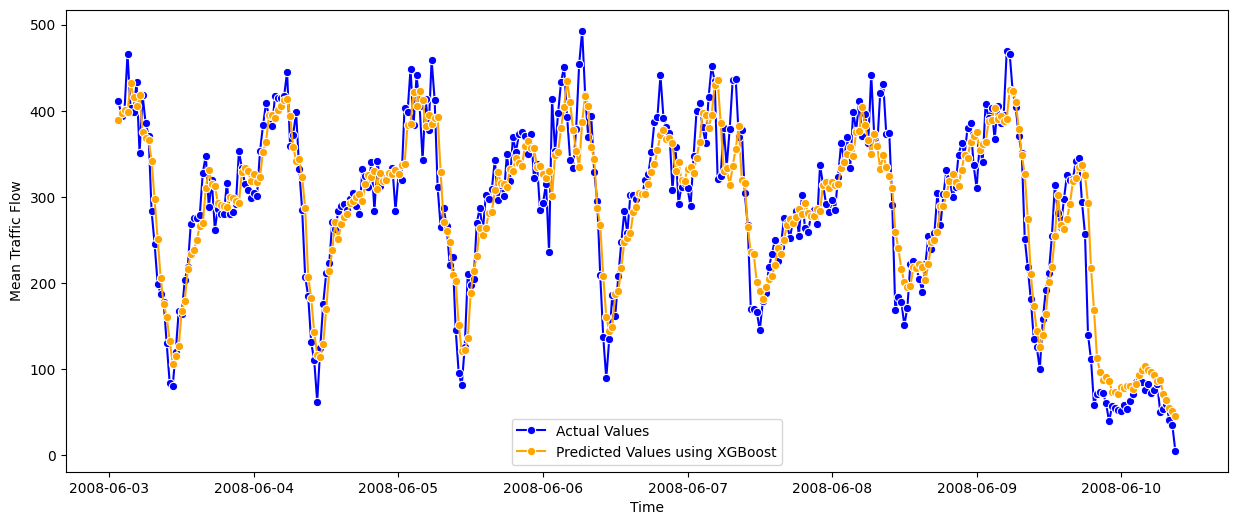

In [54]:
# Select relevant columns from the 'test' DataFrame
select = test[['Time Column','Traffic Flow']]

# Add a new column 'Predictions XGBoost' to the 'select' DataFrame containing the XGBoost predicted values
select['Predictions XGBoost'] = y_pred_xgboost

# Print the average traffic flow on all paths grouped by timestamp
grouped_by_timestamps = select[['Traffic Flow', 'Predictions XGBoost']].groupby(select['Time Column']).sum()
grouped_by_timestamps = pd.DataFrame(grouped_by_timestamps, index=grouped_by_timestamps.index)

# Create a figure
plt.figure(figsize=(15, 6))

# Plotting actual values in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Traffic Flow',
             data=grouped_by_timestamps,
             color='blue', 
             marker='o',
             alpha=1, 
             label='Actual Values')

# Plotting predicted values using LSTM in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Predictions XGBoost',
             data=grouped_by_timestamps,
             color='orange', 
             marker='o',
             alpha=1, 
             label='Predicted Values using XGBoost')

# Set the x-axis label
plt.xlabel('Time')

# Set the y-axis label
plt.ylabel('Mean Traffic Flow')

# Add a legend to the plot
plt.legend(loc='lower center')

# Display the plot
plt.show()

In [55]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.3052014426737812
RMSE score: 2.3081550285267953


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [56]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [57]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [58]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [59]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='linear'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [60]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [61]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 14s 98ms/step - loss: 0.0066 - val_loss: 0.0049
Epoch 2/50
100/100 [==============================] - 9s 91ms/step - loss: 0.0032 - val_loss: 0.0013
Epoch 3/50
100/100 [==============================] - 8s 77ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 4/50
100/100 [==============================] - 8s 80ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 5/50
100/100 [==============================] - 7s 75ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 6/50
100/100 [==============================] - 8s 79ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 7/50
100/100 [==============================] - 8s 81ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 8/50
100/100 [==============================] - 7s 71ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 9/50
100/100 [==============================] - 6s 64ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 10/50
100/100 [==============================] - 7s 70ms/step - loss: 0.0018 - val_l

In [62]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

1100/1100 [==============================] - 9s 8ms/step - loss: 0.0011
Test Loss: 0.0010796240530908108


In [63]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

1100/1100 [==============================] - 8s 7ms/step


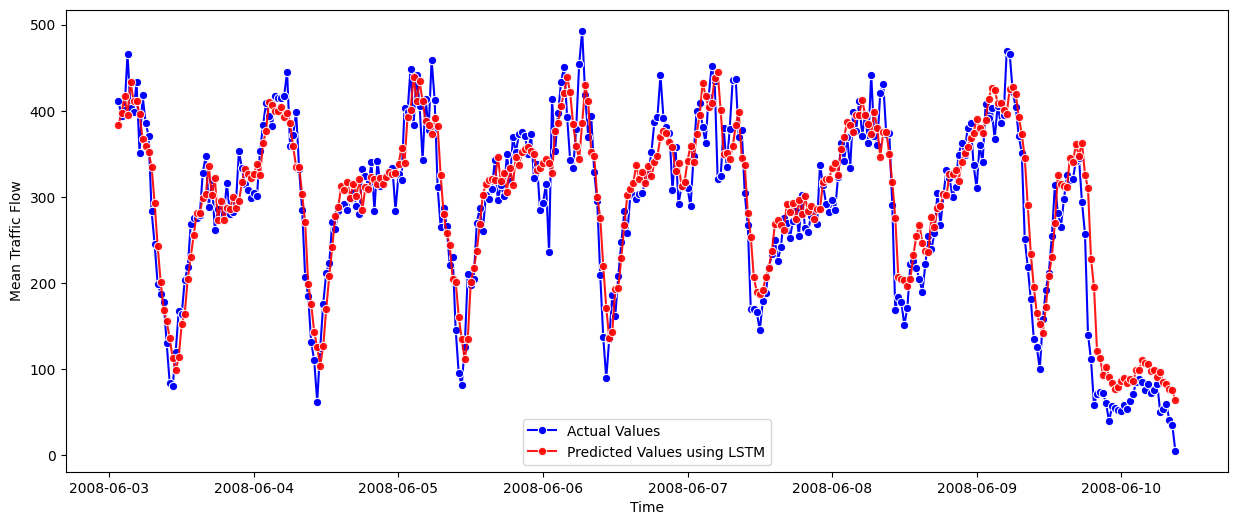

In [64]:
# Select relevant columns from the 'test' DataFrame
select = test[['Time Column','Traffic Flow']]

# Add a new column 'Predictions LSTM' to the 'select' DataFrame containing the LSTM predicted values
select['Predictions LSTM'] = y_pred_lstm

# Print the average traffic flow on all paths grouped by timestamp
grouped_by_timestamps = select[['Traffic Flow', 'Predictions LSTM']].groupby(select['Time Column']).sum()
grouped_by_timestamps = pd.DataFrame(grouped_by_timestamps, index=grouped_by_timestamps.index)

# Create a figure
plt.figure(figsize=(15, 6))

# Plotting actual values in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Traffic Flow',
             data=grouped_by_timestamps,
             color='blue', 
             marker='o',
             alpha=1, 
             label='Actual Values')

# Plotting predicted values using LSTM in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Predictions LSTM',
             data=grouped_by_timestamps,
             color='red', 
             marker='o',
             alpha=0.9, 
             label='Predicted Values using LSTM')

# Set the x-axis label
plt.xlabel('Time')

# Set the y-axis label
plt.ylabel('Mean Traffic Flow')

# Add a legend to the plot
plt.legend(loc='lower center')

# Display the plot
plt.show()

Evaluate the LSTM model

In [65]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  1.3556359618157148
RMSE LSTM score: 2.300033767394399


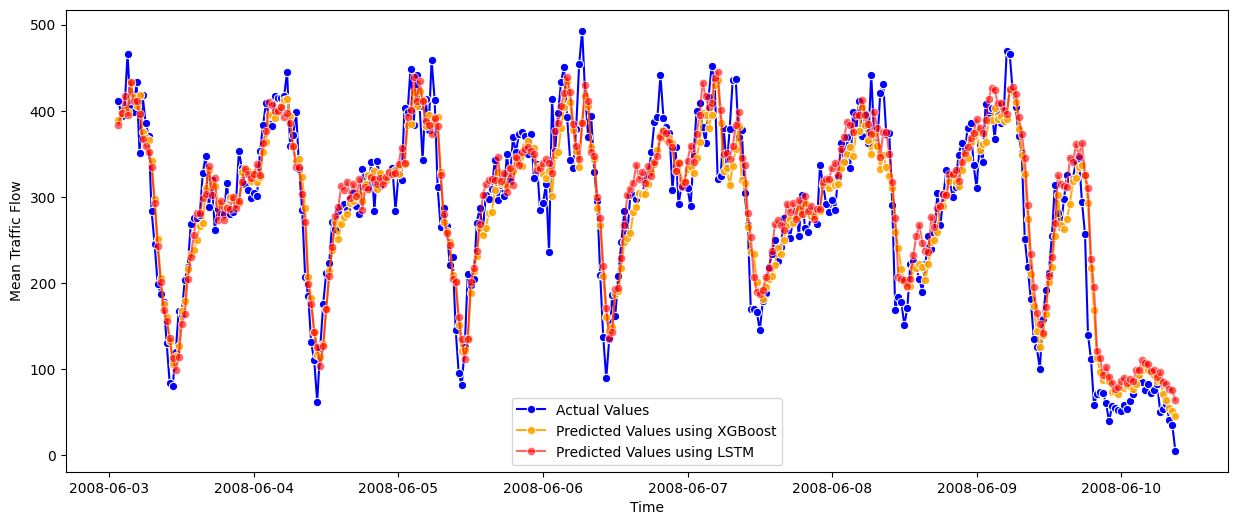

In [66]:
# Select relevant columns from the 'test' DataFrame
select = test[['Time Column','Traffic Flow']]

# Add a new column 'Predictions XGBoost' to the 'select' DataFrame containing the XGBoost predicted values
select['Predictions XGBoost'] = y_pred_xgboost

# Add a new column 'Predictions LSTM' to the 'select' DataFrame containing the LSTM predicted values
select['Predictions LSTM'] = y_pred_lstm

# Print the average traffic flow on all paths grouped by timestamp
grouped_by_timestamps = select[['Traffic Flow', 'Predictions XGBoost', 'Predictions LSTM']].groupby(select['Time Column']).sum()
grouped_by_timestamps = pd.DataFrame(grouped_by_timestamps, index=grouped_by_timestamps.index)

# Create a figure
plt.figure(figsize=(15, 6))

# Plotting actual values in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Traffic Flow',
             data=grouped_by_timestamps,
             color='blue', 
             marker='o',
             alpha=1, 
             label='Actual Values')

# Plotting predicted values using XGBoost in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Predictions XGBoost',
             data=grouped_by_timestamps,
             color='orange', 
             marker='o',
             alpha=0.9, 
             label='Predicted Values using XGBoost')

# Plotting predicted values using LSTM in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Predictions LSTM',
             data=grouped_by_timestamps,
             color='red', 
             marker='o',
             alpha=0.6, 
             label='Predicted Values using LSTM')

# Set the x-axis label
plt.xlabel('Time')

# Set the y-axis label
plt.ylabel('Mean Traffic Flow')

# Add a legend to the plot
plt.legend(loc='lower center')

# Display the plot
plt.show()

In [67]:
# Save XGBoost model to a file
reg.save_model('xgboost_traffic_flow_length-'+str(lookback)+'.model')

In [68]:
# Save the model
model.save("LSTM-length-"+str(lookback)+".h5")

##### Sliding Window Length Equals to 4

In [69]:
lookback = 4

In [70]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-06-03']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-06-03']

In [71]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, lookback)
test = generate_X_y_pairs(test, lookback)

In [72]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:lookback].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:lookback].var(axis=1)

In [73]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [74]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:5.07769	validation_1-rmse:5.11564
[1]	validation_0-rmse:4.71862	validation_1-rmse:4.75647
[2]	validation_0-rmse:4.38754	validation_1-rmse:4.42512
[3]	validation_0-rmse:4.09528	validation_1-rmse:4.13426
[4]	validation_0-rmse:3.84045	validation_1-rmse:3.87868
[5]	validation_0-rmse:3.62826	validation_1-rmse:3.66519
[6]	validation_0-rmse:3.43558	validation_1-rmse:3.47412
[7]	validation_0-rmse:3.26995	validation_1-rmse:3.30750
[8]	validation_0-rmse:3.12674	validation_1-rmse:3.16481
[9]	validation_0-rmse:3.01200	validation_1-rmse:3.04955
[10]	validation_0-rmse:2.91084	validation_1-rmse:2.94815
[11]	validation_0-rmse:2.82242	validation_1-rmse:2.85888
[12]	validation_0-rmse:2.74556	validation_1-rmse:2.78340
[13]	validation_0-rmse:2.68019	validation_1-rmse:2.71718
[14]	validation_0-rmse:2.62638	validation_1-rmse:2.66348
[15]	validation_0-rmse:2.58123	validation_1-rmse:2.61854
[16]	validation_0-rmse:2.54061	validation_1-rmse:2.57717
[17]	validation_0-rmse:2.51040	validation

[6]	validation_0-rmse:3.37001	validation_1-rmse:3.40659
[7]	validation_0-rmse:3.20297	validation_1-rmse:3.23875
[8]	validation_0-rmse:3.06154	validation_1-rmse:3.09836
[9]	validation_0-rmse:2.93949	validation_1-rmse:2.97640
[10]	validation_0-rmse:2.83561	validation_1-rmse:2.87322
[11]	validation_0-rmse:2.74805	validation_1-rmse:2.78519
[12]	validation_0-rmse:2.67462	validation_1-rmse:2.71262
[13]	validation_0-rmse:2.61237	validation_1-rmse:2.65170
[14]	validation_0-rmse:2.56123	validation_1-rmse:2.60193
[15]	validation_0-rmse:2.51846	validation_1-rmse:2.55968
[16]	validation_0-rmse:2.48193	validation_1-rmse:2.52412
[17]	validation_0-rmse:2.45267	validation_1-rmse:2.49481
[18]	validation_0-rmse:2.42748	validation_1-rmse:2.47083
[19]	validation_0-rmse:2.40162	validation_1-rmse:2.44586
[20]	validation_0-rmse:2.38450	validation_1-rmse:2.42883
[21]	validation_0-rmse:2.36872	validation_1-rmse:2.41257
[22]	validation_0-rmse:2.35548	validation_1-rmse:2.40024
[23]	validation_0-rmse:2.34510	vali

[25]	validation_0-rmse:2.37935	validation_1-rmse:2.43975
[26]	validation_0-rmse:2.37120	validation_1-rmse:2.43256
[27]	validation_0-rmse:2.36489	validation_1-rmse:2.42757
[28]	validation_0-rmse:2.35947	validation_1-rmse:2.42292
[29]	validation_0-rmse:2.35397	validation_1-rmse:2.41831
[30]	validation_0-rmse:2.35045	validation_1-rmse:2.41525
[31]	validation_0-rmse:2.34647	validation_1-rmse:2.41184
[32]	validation_0-rmse:2.34130	validation_1-rmse:2.40658
[33]	validation_0-rmse:2.33779	validation_1-rmse:2.40350
[34]	validation_0-rmse:2.33426	validation_1-rmse:2.40034
[35]	validation_0-rmse:2.33199	validation_1-rmse:2.39869
[36]	validation_0-rmse:2.33006	validation_1-rmse:2.39709
[37]	validation_0-rmse:2.32752	validation_1-rmse:2.39526
[38]	validation_0-rmse:2.32513	validation_1-rmse:2.39296
[39]	validation_0-rmse:2.32241	validation_1-rmse:2.39104
[40]	validation_0-rmse:2.32049	validation_1-rmse:2.38919
[41]	validation_0-rmse:2.31822	validation_1-rmse:2.38830
[42]	validation_0-rmse:2.31679	

[16]	validation_0-rmse:2.54063	validation_1-rmse:2.57719
[17]	validation_0-rmse:2.51042	validation_1-rmse:2.54721
[18]	validation_0-rmse:2.48155	validation_1-rmse:2.51835
[19]	validation_0-rmse:2.45735	validation_1-rmse:2.49384
[20]	validation_0-rmse:2.43697	validation_1-rmse:2.47443
[21]	validation_0-rmse:2.42131	validation_1-rmse:2.45877
[22]	validation_0-rmse:2.40667	validation_1-rmse:2.44419
[23]	validation_0-rmse:2.39463	validation_1-rmse:2.43136
[24]	validation_0-rmse:2.38410	validation_1-rmse:2.42020
[25]	validation_0-rmse:2.37569	validation_1-rmse:2.41198
[26]	validation_0-rmse:2.36791	validation_1-rmse:2.40390
[27]	validation_0-rmse:2.36073	validation_1-rmse:2.39657
[28]	validation_0-rmse:2.35407	validation_1-rmse:2.38882
[29]	validation_0-rmse:2.34748	validation_1-rmse:2.38231
[30]	validation_0-rmse:2.34220	validation_1-rmse:2.37742
[31]	validation_0-rmse:2.33664	validation_1-rmse:2.37215
[32]	validation_0-rmse:2.33286	validation_1-rmse:2.36839
[33]	validation_0-rmse:2.32999	

[29]	validation_0-rmse:2.30902	validation_1-rmse:2.35748
[30]	validation_0-rmse:2.30591	validation_1-rmse:2.35451
[31]	validation_0-rmse:2.30202	validation_1-rmse:2.35105
[32]	validation_0-rmse:2.29922	validation_1-rmse:2.34878
[33]	validation_0-rmse:2.29657	validation_1-rmse:2.34719
[34]	validation_0-rmse:2.29408	validation_1-rmse:2.34529
[35]	validation_0-rmse:2.29221	validation_1-rmse:2.34392
[36]	validation_0-rmse:2.29071	validation_1-rmse:2.34262
[37]	validation_0-rmse:2.28832	validation_1-rmse:2.34061
[38]	validation_0-rmse:2.28725	validation_1-rmse:2.33994
[39]	validation_0-rmse:2.28602	validation_1-rmse:2.33881
[40]	validation_0-rmse:2.28416	validation_1-rmse:2.33738
[41]	validation_0-rmse:2.28311	validation_1-rmse:2.33739
[42]	validation_0-rmse:2.28198	validation_1-rmse:2.33676
[43]	validation_0-rmse:2.28063	validation_1-rmse:2.33624
[44]	validation_0-rmse:2.28002	validation_1-rmse:2.33616
[45]	validation_0-rmse:2.27883	validation_1-rmse:2.33569
[46]	validation_0-rmse:2.27763	

[49]	validation_0-rmse:2.30443	validation_1-rmse:2.37582
[50]	validation_0-rmse:2.30146	validation_1-rmse:2.37378
[51]	validation_0-rmse:2.30052	validation_1-rmse:2.37293
[52]	validation_0-rmse:2.30048	validation_1-rmse:2.37490
[53]	validation_0-rmse:2.29897	validation_1-rmse:2.37371
[54]	validation_0-rmse:2.29854	validation_1-rmse:2.37449
[55]	validation_0-rmse:2.29968	validation_1-rmse:2.37642
[56]	validation_0-rmse:2.29969	validation_1-rmse:2.37689
[0]	validation_0-rmse:5.06452	validation_1-rmse:5.10188
[1]	validation_0-rmse:4.68051	validation_1-rmse:4.71840
[2]	validation_0-rmse:4.34126	validation_1-rmse:4.37976
[3]	validation_0-rmse:4.04683	validation_1-rmse:4.08479
[4]	validation_0-rmse:3.78848	validation_1-rmse:3.82480
[5]	validation_0-rmse:3.56458	validation_1-rmse:3.60125
[6]	validation_0-rmse:3.37145	validation_1-rmse:3.40733
[7]	validation_0-rmse:3.20450	validation_1-rmse:3.24102
[8]	validation_0-rmse:3.06267	validation_1-rmse:3.09909
[9]	validation_0-rmse:2.94049	validation

[2]	validation_0-rmse:4.34374	validation_1-rmse:4.39559
[3]	validation_0-rmse:4.05001	validation_1-rmse:4.10552
[4]	validation_0-rmse:3.79262	validation_1-rmse:3.85052
[5]	validation_0-rmse:3.56683	validation_1-rmse:3.62856
[6]	validation_0-rmse:3.37041	validation_1-rmse:3.43574
[7]	validation_0-rmse:3.20176	validation_1-rmse:3.27418
[8]	validation_0-rmse:3.05884	validation_1-rmse:3.13437
[9]	validation_0-rmse:2.93059	validation_1-rmse:3.00855
[10]	validation_0-rmse:2.82750	validation_1-rmse:2.90973
[11]	validation_0-rmse:2.73853	validation_1-rmse:2.82146
[12]	validation_0-rmse:2.66031	validation_1-rmse:2.74552
[13]	validation_0-rmse:2.59551	validation_1-rmse:2.68367
[14]	validation_0-rmse:2.53817	validation_1-rmse:2.62941
[15]	validation_0-rmse:2.48941	validation_1-rmse:2.58224
[16]	validation_0-rmse:2.44897	validation_1-rmse:2.54515
[17]	validation_0-rmse:2.41667	validation_1-rmse:2.51483
[18]	validation_0-rmse:2.38533	validation_1-rmse:2.48723
[19]	validation_0-rmse:2.36152	validati

[2]	validation_0-rmse:4.35387	validation_1-rmse:4.40428
[3]	validation_0-rmse:4.05807	validation_1-rmse:4.11477
[4]	validation_0-rmse:3.80398	validation_1-rmse:3.86500
[5]	validation_0-rmse:3.57668	validation_1-rmse:3.64307
[6]	validation_0-rmse:3.38192	validation_1-rmse:3.45269
[7]	validation_0-rmse:3.21339	validation_1-rmse:3.29008
[8]	validation_0-rmse:3.06994	validation_1-rmse:3.15199
[9]	validation_0-rmse:2.94577	validation_1-rmse:3.03163
[10]	validation_0-rmse:2.84123	validation_1-rmse:2.93444
[11]	validation_0-rmse:2.75273	validation_1-rmse:2.84955
[12]	validation_0-rmse:2.67728	validation_1-rmse:2.77763
[13]	validation_0-rmse:2.61400	validation_1-rmse:2.71695
[14]	validation_0-rmse:2.55865	validation_1-rmse:2.66392
[15]	validation_0-rmse:2.51404	validation_1-rmse:2.62356
[16]	validation_0-rmse:2.47368	validation_1-rmse:2.58610
[17]	validation_0-rmse:2.43694	validation_1-rmse:2.55092
[18]	validation_0-rmse:2.40557	validation_1-rmse:2.52098
[19]	validation_0-rmse:2.38281	validati

[45]	validation_0-rmse:2.21771	validation_1-rmse:2.32415
[46]	validation_0-rmse:2.21685	validation_1-rmse:2.32345
[47]	validation_0-rmse:2.21581	validation_1-rmse:2.32351
[0]	validation_0-rmse:5.06702	validation_1-rmse:5.11150
[1]	validation_0-rmse:4.68342	validation_1-rmse:4.73225
[2]	validation_0-rmse:4.34522	validation_1-rmse:4.39594
[3]	validation_0-rmse:4.04959	validation_1-rmse:4.10771
[4]	validation_0-rmse:3.79104	validation_1-rmse:3.85270
[5]	validation_0-rmse:3.56713	validation_1-rmse:3.63086
[6]	validation_0-rmse:3.37113	validation_1-rmse:3.43890
[7]	validation_0-rmse:3.20451	validation_1-rmse:3.27646
[8]	validation_0-rmse:3.05657	validation_1-rmse:3.13452
[9]	validation_0-rmse:2.92868	validation_1-rmse:3.00922
[10]	validation_0-rmse:2.82200	validation_1-rmse:2.90275
[11]	validation_0-rmse:2.73144	validation_1-rmse:2.81400
[12]	validation_0-rmse:2.65431	validation_1-rmse:2.74104
[13]	validation_0-rmse:2.59090	validation_1-rmse:2.68086
[14]	validation_0-rmse:2.53500	validation

[8]	validation_0-rmse:3.06998	validation_1-rmse:3.15210
[9]	validation_0-rmse:2.94581	validation_1-rmse:3.03173
[10]	validation_0-rmse:2.84122	validation_1-rmse:2.93451
[11]	validation_0-rmse:2.75276	validation_1-rmse:2.84961
[12]	validation_0-rmse:2.67733	validation_1-rmse:2.77771
[13]	validation_0-rmse:2.61405	validation_1-rmse:2.71701
[14]	validation_0-rmse:2.55878	validation_1-rmse:2.66397
[15]	validation_0-rmse:2.51417	validation_1-rmse:2.62361
[16]	validation_0-rmse:2.47372	validation_1-rmse:2.58602
[17]	validation_0-rmse:2.43763	validation_1-rmse:2.55130
[18]	validation_0-rmse:2.40878	validation_1-rmse:2.52521
[19]	validation_0-rmse:2.38014	validation_1-rmse:2.49954
[20]	validation_0-rmse:2.35703	validation_1-rmse:2.47978
[21]	validation_0-rmse:2.33767	validation_1-rmse:2.46467
[22]	validation_0-rmse:2.32526	validation_1-rmse:2.45578
[23]	validation_0-rmse:2.31165	validation_1-rmse:2.44383
[24]	validation_0-rmse:2.29805	validation_1-rmse:2.43204
[25]	validation_0-rmse:2.28879	va

[13]	validation_0-rmse:2.46762	validation_1-rmse:2.67670
[14]	validation_0-rmse:2.40197	validation_1-rmse:2.62393
[15]	validation_0-rmse:2.34870	validation_1-rmse:2.58014
[16]	validation_0-rmse:2.30063	validation_1-rmse:2.54257
[17]	validation_0-rmse:2.25872	validation_1-rmse:2.51117
[18]	validation_0-rmse:2.22461	validation_1-rmse:2.48674
[19]	validation_0-rmse:2.19295	validation_1-rmse:2.46566
[20]	validation_0-rmse:2.16763	validation_1-rmse:2.44757
[21]	validation_0-rmse:2.14400	validation_1-rmse:2.43286
[22]	validation_0-rmse:2.12293	validation_1-rmse:2.41993
[23]	validation_0-rmse:2.10571	validation_1-rmse:2.41060
[24]	validation_0-rmse:2.08942	validation_1-rmse:2.40075
[25]	validation_0-rmse:2.07607	validation_1-rmse:2.39254
[26]	validation_0-rmse:2.06211	validation_1-rmse:2.38526
[27]	validation_0-rmse:2.04934	validation_1-rmse:2.38030
[28]	validation_0-rmse:2.03916	validation_1-rmse:2.37661
[29]	validation_0-rmse:2.02983	validation_1-rmse:2.37342
[30]	validation_0-rmse:2.02107	

[35]	validation_0-rmse:2.03811	validation_1-rmse:2.42169
[36]	validation_0-rmse:2.03236	validation_1-rmse:2.41922
[37]	validation_0-rmse:2.02681	validation_1-rmse:2.41686
[38]	validation_0-rmse:2.01916	validation_1-rmse:2.41315
[39]	validation_0-rmse:2.01485	validation_1-rmse:2.41142
[40]	validation_0-rmse:2.01037	validation_1-rmse:2.41045
[41]	validation_0-rmse:2.00554	validation_1-rmse:2.40860
[42]	validation_0-rmse:2.00286	validation_1-rmse:2.40864
[43]	validation_0-rmse:1.99770	validation_1-rmse:2.40744
[44]	validation_0-rmse:1.99418	validation_1-rmse:2.40651
[45]	validation_0-rmse:1.99006	validation_1-rmse:2.40508
[46]	validation_0-rmse:1.98669	validation_1-rmse:2.40484
[47]	validation_0-rmse:1.98398	validation_1-rmse:2.40538
[48]	validation_0-rmse:1.98090	validation_1-rmse:2.40522
[49]	validation_0-rmse:1.97483	validation_1-rmse:2.40399
[50]	validation_0-rmse:1.97324	validation_1-rmse:2.40400
[51]	validation_0-rmse:1.96954	validation_1-rmse:2.40534
[52]	validation_0-rmse:1.96554	

[35]	validation_0-rmse:1.98686	validation_1-rmse:2.34644
[36]	validation_0-rmse:1.97844	validation_1-rmse:2.34424
[37]	validation_0-rmse:1.97220	validation_1-rmse:2.34211
[38]	validation_0-rmse:1.96962	validation_1-rmse:2.34333
[39]	validation_0-rmse:1.96273	validation_1-rmse:2.34307
[40]	validation_0-rmse:1.95781	validation_1-rmse:2.34208
[41]	validation_0-rmse:1.95337	validation_1-rmse:2.34282
[42]	validation_0-rmse:1.94822	validation_1-rmse:2.33997
[43]	validation_0-rmse:1.94269	validation_1-rmse:2.34002
[44]	validation_0-rmse:1.94211	validation_1-rmse:2.34380
[45]	validation_0-rmse:1.93749	validation_1-rmse:2.34258
[46]	validation_0-rmse:1.93192	validation_1-rmse:2.34049
[47]	validation_0-rmse:1.92682	validation_1-rmse:2.33779
[48]	validation_0-rmse:1.92179	validation_1-rmse:2.33569
[49]	validation_0-rmse:1.91749	validation_1-rmse:2.33453
[50]	validation_0-rmse:1.90585	validation_1-rmse:2.32820
[51]	validation_0-rmse:1.90259	validation_1-rmse:2.32788
[52]	validation_0-rmse:1.90072	

[39]	validation_0-rmse:2.02279	validation_1-rmse:2.41020
[40]	validation_0-rmse:2.01840	validation_1-rmse:2.41007
[41]	validation_0-rmse:2.01246	validation_1-rmse:2.40739
[42]	validation_0-rmse:2.00701	validation_1-rmse:2.40587
[43]	validation_0-rmse:2.00292	validation_1-rmse:2.40467
[44]	validation_0-rmse:1.99874	validation_1-rmse:2.40539
[45]	validation_0-rmse:1.99371	validation_1-rmse:2.40384
[46]	validation_0-rmse:1.99092	validation_1-rmse:2.40376
[47]	validation_0-rmse:1.98583	validation_1-rmse:2.40098
[48]	validation_0-rmse:1.98292	validation_1-rmse:2.40115
[49]	validation_0-rmse:1.97803	validation_1-rmse:2.40168
[50]	validation_0-rmse:1.96753	validation_1-rmse:2.39534
[51]	validation_0-rmse:1.96304	validation_1-rmse:2.39271
[52]	validation_0-rmse:1.95444	validation_1-rmse:2.38714
[53]	validation_0-rmse:1.95184	validation_1-rmse:2.38827
[54]	validation_0-rmse:1.94890	validation_1-rmse:2.38725
[55]	validation_0-rmse:1.94542	validation_1-rmse:2.38569
[56]	validation_0-rmse:1.94332	

[68]	validation_0-rmse:2.29467	validation_1-rmse:2.33397
[69]	validation_0-rmse:2.29396	validation_1-rmse:2.33330
[70]	validation_0-rmse:2.29293	validation_1-rmse:2.33260
[71]	validation_0-rmse:2.29367	validation_1-rmse:2.33396
[72]	validation_0-rmse:2.29191	validation_1-rmse:2.33255
[73]	validation_0-rmse:2.29250	validation_1-rmse:2.33309
[74]	validation_0-rmse:2.29141	validation_1-rmse:2.33228
[75]	validation_0-rmse:2.28971	validation_1-rmse:2.33104
[76]	validation_0-rmse:2.28920	validation_1-rmse:2.33088
[77]	validation_0-rmse:2.28814	validation_1-rmse:2.33018
[78]	validation_0-rmse:2.28855	validation_1-rmse:2.33072
[79]	validation_0-rmse:2.28765	validation_1-rmse:2.33037
[80]	validation_0-rmse:2.28705	validation_1-rmse:2.33013
[81]	validation_0-rmse:2.28610	validation_1-rmse:2.32970
[82]	validation_0-rmse:2.28583	validation_1-rmse:2.32965
[83]	validation_0-rmse:2.28456	validation_1-rmse:2.32871
[84]	validation_0-rmse:2.28450	validation_1-rmse:2.32867
[85]	validation_0-rmse:2.28572	

[18]	validation_0-rmse:2.48255	validation_1-rmse:2.51971
[19]	validation_0-rmse:2.45857	validation_1-rmse:2.49493
[20]	validation_0-rmse:2.43840	validation_1-rmse:2.47555
[21]	validation_0-rmse:2.42350	validation_1-rmse:2.46048
[22]	validation_0-rmse:2.41044	validation_1-rmse:2.44742
[23]	validation_0-rmse:2.39742	validation_1-rmse:2.43439
[24]	validation_0-rmse:2.38707	validation_1-rmse:2.42349
[25]	validation_0-rmse:2.37737	validation_1-rmse:2.41342
[26]	validation_0-rmse:2.36912	validation_1-rmse:2.40495
[27]	validation_0-rmse:2.36124	validation_1-rmse:2.39744
[28]	validation_0-rmse:2.35535	validation_1-rmse:2.39106
[29]	validation_0-rmse:2.34981	validation_1-rmse:2.38541
[30]	validation_0-rmse:2.34506	validation_1-rmse:2.38065
[31]	validation_0-rmse:2.34106	validation_1-rmse:2.37672
[32]	validation_0-rmse:2.33713	validation_1-rmse:2.37233
[33]	validation_0-rmse:2.33425	validation_1-rmse:2.36943
[34]	validation_0-rmse:2.33002	validation_1-rmse:2.36548
[35]	validation_0-rmse:2.32737	

[27]	validation_0-rmse:2.31798	validation_1-rmse:2.36526
[28]	validation_0-rmse:2.31302	validation_1-rmse:2.36039
[29]	validation_0-rmse:2.30931	validation_1-rmse:2.35701
[30]	validation_0-rmse:2.30555	validation_1-rmse:2.35410
[31]	validation_0-rmse:2.30288	validation_1-rmse:2.35140
[32]	validation_0-rmse:2.30020	validation_1-rmse:2.34961
[33]	validation_0-rmse:2.29678	validation_1-rmse:2.34660
[34]	validation_0-rmse:2.29457	validation_1-rmse:2.34462
[35]	validation_0-rmse:2.29264	validation_1-rmse:2.34297
[36]	validation_0-rmse:2.29055	validation_1-rmse:2.34161
[37]	validation_0-rmse:2.28929	validation_1-rmse:2.34052
[38]	validation_0-rmse:2.28787	validation_1-rmse:2.33960
[39]	validation_0-rmse:2.28661	validation_1-rmse:2.33916
[40]	validation_0-rmse:2.28509	validation_1-rmse:2.33823
[41]	validation_0-rmse:2.28395	validation_1-rmse:2.33786
[42]	validation_0-rmse:2.28192	validation_1-rmse:2.33609
[43]	validation_0-rmse:2.28067	validation_1-rmse:2.33670
[44]	validation_0-rmse:2.27907	

[82]	validation_0-rmse:2.28151	validation_1-rmse:2.32862
[0]	validation_0-rmse:5.08015	validation_1-rmse:5.11960
[1]	validation_0-rmse:4.70560	validation_1-rmse:4.74495
[2]	validation_0-rmse:4.37852	validation_1-rmse:4.41957
[3]	validation_0-rmse:4.08835	validation_1-rmse:4.12764
[4]	validation_0-rmse:3.83472	validation_1-rmse:3.87448
[5]	validation_0-rmse:3.61348	validation_1-rmse:3.65445
[6]	validation_0-rmse:3.42306	validation_1-rmse:3.46389
[7]	validation_0-rmse:3.26915	validation_1-rmse:3.31428
[8]	validation_0-rmse:3.12496	validation_1-rmse:3.17104
[9]	validation_0-rmse:3.00382	validation_1-rmse:3.05045
[10]	validation_0-rmse:2.90687	validation_1-rmse:2.95475
[11]	validation_0-rmse:2.81600	validation_1-rmse:2.86387
[12]	validation_0-rmse:2.74500	validation_1-rmse:2.79499
[13]	validation_0-rmse:2.67913	validation_1-rmse:2.72910
[14]	validation_0-rmse:2.62701	validation_1-rmse:2.67802
[15]	validation_0-rmse:2.58164	validation_1-rmse:2.63189
[16]	validation_0-rmse:2.54399	validation

[39]	validation_0-rmse:2.31737	validation_1-rmse:2.35481
[40]	validation_0-rmse:2.31582	validation_1-rmse:2.35354
[41]	validation_0-rmse:2.31345	validation_1-rmse:2.35171
[42]	validation_0-rmse:2.31245	validation_1-rmse:2.35093
[43]	validation_0-rmse:2.31202	validation_1-rmse:2.35045
[44]	validation_0-rmse:2.30955	validation_1-rmse:2.34755
[45]	validation_0-rmse:2.30863	validation_1-rmse:2.34732
[46]	validation_0-rmse:2.30748	validation_1-rmse:2.34712
[47]	validation_0-rmse:2.30798	validation_1-rmse:2.34768
[48]	validation_0-rmse:2.30614	validation_1-rmse:2.34628
[49]	validation_0-rmse:2.30534	validation_1-rmse:2.34580
[50]	validation_0-rmse:2.30430	validation_1-rmse:2.34513
[51]	validation_0-rmse:2.30548	validation_1-rmse:2.34570
[52]	validation_0-rmse:2.30493	validation_1-rmse:2.34543
[53]	validation_0-rmse:2.30379	validation_1-rmse:2.34447
[54]	validation_0-rmse:2.30346	validation_1-rmse:2.34450
[55]	validation_0-rmse:2.30250	validation_1-rmse:2.34355
[56]	validation_0-rmse:2.30176	

[58]	validation_0-rmse:2.26872	validation_1-rmse:2.33001
[59]	validation_0-rmse:2.26825	validation_1-rmse:2.32992
[60]	validation_0-rmse:2.26759	validation_1-rmse:2.32984
[61]	validation_0-rmse:2.26741	validation_1-rmse:2.33033
[62]	validation_0-rmse:2.26645	validation_1-rmse:2.32948
[63]	validation_0-rmse:2.26542	validation_1-rmse:2.32844
[64]	validation_0-rmse:2.26474	validation_1-rmse:2.32847
[65]	validation_0-rmse:2.26446	validation_1-rmse:2.32785
[66]	validation_0-rmse:2.26299	validation_1-rmse:2.32644
[67]	validation_0-rmse:2.26155	validation_1-rmse:2.32524
[68]	validation_0-rmse:2.26111	validation_1-rmse:2.32486
[69]	validation_0-rmse:2.26124	validation_1-rmse:2.32575
[70]	validation_0-rmse:2.26006	validation_1-rmse:2.32503
[71]	validation_0-rmse:2.25936	validation_1-rmse:2.32424
[72]	validation_0-rmse:2.25791	validation_1-rmse:2.32345
[73]	validation_0-rmse:2.25750	validation_1-rmse:2.32339
[74]	validation_0-rmse:2.25725	validation_1-rmse:2.32321
[75]	validation_0-rmse:2.25570	

[18]	validation_0-rmse:2.29250	validation_1-rmse:2.41080
[19]	validation_0-rmse:2.27064	validation_1-rmse:2.39187
[20]	validation_0-rmse:2.25089	validation_1-rmse:2.37643
[21]	validation_0-rmse:2.23347	validation_1-rmse:2.36237
[22]	validation_0-rmse:2.21985	validation_1-rmse:2.35130
[23]	validation_0-rmse:2.20784	validation_1-rmse:2.34247
[24]	validation_0-rmse:2.19731	validation_1-rmse:2.33473
[25]	validation_0-rmse:2.19041	validation_1-rmse:2.32924
[26]	validation_0-rmse:2.18369	validation_1-rmse:2.32458
[27]	validation_0-rmse:2.17642	validation_1-rmse:2.32146
[28]	validation_0-rmse:2.16899	validation_1-rmse:2.31631
[29]	validation_0-rmse:2.16337	validation_1-rmse:2.31267
[30]	validation_0-rmse:2.15845	validation_1-rmse:2.30942
[31]	validation_0-rmse:2.15446	validation_1-rmse:2.30821
[32]	validation_0-rmse:2.14994	validation_1-rmse:2.30551
[33]	validation_0-rmse:2.14699	validation_1-rmse:2.30363
[34]	validation_0-rmse:2.14401	validation_1-rmse:2.30153
[35]	validation_0-rmse:2.14678	

[15]	validation_0-rmse:2.39101	validation_1-rmse:2.49238
[16]	validation_0-rmse:2.35143	validation_1-rmse:2.45975
[17]	validation_0-rmse:2.32100	validation_1-rmse:2.43370
[18]	validation_0-rmse:2.29348	validation_1-rmse:2.40990
[19]	validation_0-rmse:2.27276	validation_1-rmse:2.39100
[20]	validation_0-rmse:2.25349	validation_1-rmse:2.37378
[21]	validation_0-rmse:2.23927	validation_1-rmse:2.36176
[22]	validation_0-rmse:2.22676	validation_1-rmse:2.35147
[23]	validation_0-rmse:2.21708	validation_1-rmse:2.34331
[24]	validation_0-rmse:2.20700	validation_1-rmse:2.33482
[25]	validation_0-rmse:2.19910	validation_1-rmse:2.32888
[26]	validation_0-rmse:2.19015	validation_1-rmse:2.32274
[27]	validation_0-rmse:2.18513	validation_1-rmse:2.31810
[28]	validation_0-rmse:2.18106	validation_1-rmse:2.31535
[29]	validation_0-rmse:2.17728	validation_1-rmse:2.31298
[30]	validation_0-rmse:2.17374	validation_1-rmse:2.31242
[31]	validation_0-rmse:2.17093	validation_1-rmse:2.31063
[32]	validation_0-rmse:2.16820	

[19]	validation_0-rmse:2.26631	validation_1-rmse:2.38784
[20]	validation_0-rmse:2.24766	validation_1-rmse:2.37158
[21]	validation_0-rmse:2.23273	validation_1-rmse:2.35907
[22]	validation_0-rmse:2.21912	validation_1-rmse:2.34701
[23]	validation_0-rmse:2.20870	validation_1-rmse:2.33812
[24]	validation_0-rmse:2.20017	validation_1-rmse:2.33100
[25]	validation_0-rmse:2.19271	validation_1-rmse:2.32576
[26]	validation_0-rmse:2.18565	validation_1-rmse:2.32282
[27]	validation_0-rmse:2.17941	validation_1-rmse:2.31936
[28]	validation_0-rmse:2.17401	validation_1-rmse:2.31461
[29]	validation_0-rmse:2.16857	validation_1-rmse:2.31033
[30]	validation_0-rmse:2.16517	validation_1-rmse:2.30915
[31]	validation_0-rmse:2.16148	validation_1-rmse:2.30646
[32]	validation_0-rmse:2.15921	validation_1-rmse:2.30559
[33]	validation_0-rmse:2.15598	validation_1-rmse:2.30395
[34]	validation_0-rmse:2.15148	validation_1-rmse:2.30096
[35]	validation_0-rmse:2.14846	validation_1-rmse:2.30014
[36]	validation_0-rmse:2.14509	

[21]	validation_0-rmse:2.23998	validation_1-rmse:2.36472
[22]	validation_0-rmse:2.22764	validation_1-rmse:2.35420
[23]	validation_0-rmse:2.21890	validation_1-rmse:2.34667
[24]	validation_0-rmse:2.20888	validation_1-rmse:2.33902
[25]	validation_0-rmse:2.20126	validation_1-rmse:2.33291
[26]	validation_0-rmse:2.19491	validation_1-rmse:2.32798
[27]	validation_0-rmse:2.18960	validation_1-rmse:2.32493
[28]	validation_0-rmse:2.18386	validation_1-rmse:2.32126
[29]	validation_0-rmse:2.17856	validation_1-rmse:2.31791
[30]	validation_0-rmse:2.17491	validation_1-rmse:2.31525
[31]	validation_0-rmse:2.17117	validation_1-rmse:2.31407
[32]	validation_0-rmse:2.16816	validation_1-rmse:2.31309
[33]	validation_0-rmse:2.16343	validation_1-rmse:2.30930
[34]	validation_0-rmse:2.16149	validation_1-rmse:2.30863
[35]	validation_0-rmse:2.15928	validation_1-rmse:2.30799
[36]	validation_0-rmse:2.15699	validation_1-rmse:2.30644
[37]	validation_0-rmse:2.15469	validation_1-rmse:2.30560
[38]	validation_0-rmse:2.15285	

[20]	validation_0-rmse:2.06197	validation_1-rmse:2.40432
[21]	validation_0-rmse:2.04234	validation_1-rmse:2.39404
[22]	validation_0-rmse:2.02546	validation_1-rmse:2.38554
[23]	validation_0-rmse:2.01318	validation_1-rmse:2.38034
[24]	validation_0-rmse:2.00314	validation_1-rmse:2.37724
[25]	validation_0-rmse:1.99331	validation_1-rmse:2.37644
[26]	validation_0-rmse:1.98515	validation_1-rmse:2.37438
[27]	validation_0-rmse:1.98014	validation_1-rmse:2.37449
[28]	validation_0-rmse:1.97774	validation_1-rmse:2.37637
[29]	validation_0-rmse:1.97509	validation_1-rmse:2.37824
[30]	validation_0-rmse:1.97199	validation_1-rmse:2.38013
[0]	validation_0-rmse:5.07290	validation_1-rmse:5.11999
[1]	validation_0-rmse:4.69363	validation_1-rmse:4.74870
[2]	validation_0-rmse:4.36367	validation_1-rmse:4.42405
[3]	validation_0-rmse:4.06246	validation_1-rmse:4.13618
[4]	validation_0-rmse:3.80270	validation_1-rmse:3.88667
[5]	validation_0-rmse:3.57299	validation_1-rmse:3.67402
[6]	validation_0-rmse:3.37042	validat

[25]	validation_0-rmse:2.02035	validation_1-rmse:2.36032
[26]	validation_0-rmse:2.00965	validation_1-rmse:2.35473
[27]	validation_0-rmse:2.00118	validation_1-rmse:2.35123
[28]	validation_0-rmse:1.99220	validation_1-rmse:2.34767
[29]	validation_0-rmse:1.98646	validation_1-rmse:2.34513
[30]	validation_0-rmse:1.98077	validation_1-rmse:2.34266
[31]	validation_0-rmse:1.97742	validation_1-rmse:2.34263
[32]	validation_0-rmse:1.97333	validation_1-rmse:2.34158
[33]	validation_0-rmse:1.96792	validation_1-rmse:2.33979
[34]	validation_0-rmse:1.96495	validation_1-rmse:2.34074
[35]	validation_0-rmse:1.96124	validation_1-rmse:2.34037
[36]	validation_0-rmse:1.95543	validation_1-rmse:2.34071
[37]	validation_0-rmse:1.95205	validation_1-rmse:2.33969
[38]	validation_0-rmse:1.94949	validation_1-rmse:2.33980
[39]	validation_0-rmse:1.94500	validation_1-rmse:2.33882
[40]	validation_0-rmse:1.94070	validation_1-rmse:2.33814
[41]	validation_0-rmse:1.93819	validation_1-rmse:2.33929
[42]	validation_0-rmse:1.93416	

[33]	validation_0-rmse:1.96036	validation_1-rmse:2.37623
[34]	validation_0-rmse:1.95253	validation_1-rmse:2.37563
[35]	validation_0-rmse:1.95023	validation_1-rmse:2.37711
[0]	validation_0-rmse:5.07285	validation_1-rmse:5.11970
[1]	validation_0-rmse:4.69362	validation_1-rmse:4.74827
[2]	validation_0-rmse:4.36387	validation_1-rmse:4.42361
[3]	validation_0-rmse:4.06258	validation_1-rmse:4.13549
[4]	validation_0-rmse:3.80195	validation_1-rmse:3.88511
[5]	validation_0-rmse:3.57342	validation_1-rmse:3.67069
[6]	validation_0-rmse:3.36813	validation_1-rmse:3.47951
[7]	validation_0-rmse:3.19847	validation_1-rmse:3.32232
[8]	validation_0-rmse:3.04807	validation_1-rmse:3.18156
[9]	validation_0-rmse:2.91265	validation_1-rmse:3.06093
[10]	validation_0-rmse:2.79583	validation_1-rmse:2.95539
[11]	validation_0-rmse:2.69668	validation_1-rmse:2.86621
[12]	validation_0-rmse:2.61199	validation_1-rmse:2.79371
[13]	validation_0-rmse:2.53706	validation_1-rmse:2.72907
[14]	validation_0-rmse:2.47311	validation

[26]	validation_0-rmse:2.02420	validation_1-rmse:2.35804
[27]	validation_0-rmse:2.01623	validation_1-rmse:2.35368
[28]	validation_0-rmse:2.00868	validation_1-rmse:2.35106
[29]	validation_0-rmse:2.00590	validation_1-rmse:2.35176
[30]	validation_0-rmse:2.00133	validation_1-rmse:2.35112
[31]	validation_0-rmse:1.99395	validation_1-rmse:2.34890
[32]	validation_0-rmse:1.98822	validation_1-rmse:2.34734
[33]	validation_0-rmse:1.98238	validation_1-rmse:2.34619
[34]	validation_0-rmse:1.97788	validation_1-rmse:2.34619
[35]	validation_0-rmse:1.97420	validation_1-rmse:2.34662
[36]	validation_0-rmse:1.96930	validation_1-rmse:2.34619
[37]	validation_0-rmse:1.96674	validation_1-rmse:2.34627
[38]	validation_0-rmse:1.96113	validation_1-rmse:2.34536
[39]	validation_0-rmse:1.95947	validation_1-rmse:2.34582
[40]	validation_0-rmse:1.95497	validation_1-rmse:2.34654
[41]	validation_0-rmse:1.95133	validation_1-rmse:2.34522
[42]	validation_0-rmse:1.94802	validation_1-rmse:2.34684
[43]	validation_0-rmse:1.94363	

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [75]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)])

[0]	validation_0-rmse:5.07359	validation_1-rmse:5.11298
[1]	validation_0-rmse:4.69386	validation_1-rmse:4.73329
[2]	validation_0-rmse:4.36226	validation_1-rmse:4.39948
[3]	validation_0-rmse:4.06828	validation_1-rmse:4.10696
[4]	validation_0-rmse:3.81368	validation_1-rmse:3.85187
[5]	validation_0-rmse:3.59148	validation_1-rmse:3.63035
[6]	validation_0-rmse:3.39839	validation_1-rmse:3.43772
[7]	validation_0-rmse:3.23360	validation_1-rmse:3.27442
[8]	validation_0-rmse:3.09005	validation_1-rmse:3.13141
[9]	validation_0-rmse:2.96760	validation_1-rmse:3.00993
[10]	validation_0-rmse:2.86443	validation_1-rmse:2.90764
[11]	validation_0-rmse:2.77662	validation_1-rmse:2.82177
[12]	validation_0-rmse:2.70301	validation_1-rmse:2.74812
[13]	validation_0-rmse:2.63969	validation_1-rmse:2.68544
[14]	validation_0-rmse:2.58641	validation_1-rmse:2.63211
[15]	validation_0-rmse:2.54239	validation_1-rmse:2.58829
[16]	validation_0-rmse:2.50528	validation_1-rmse:2.55113
[17]	validation_0-rmse:2.47352	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Make predictions on the test set

In [76]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

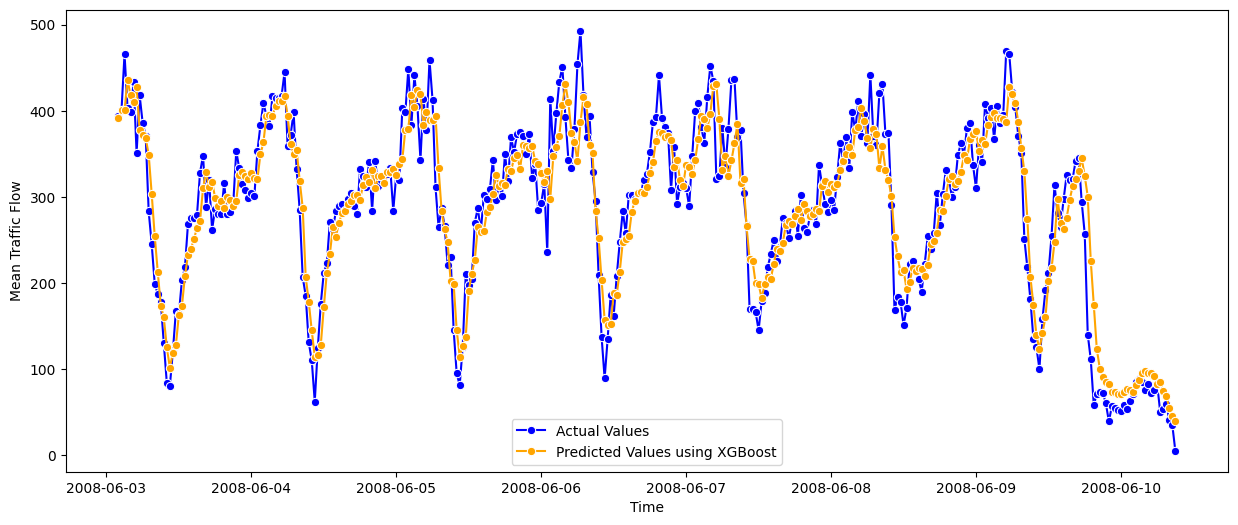

In [77]:
# Select relevant columns from the 'test' DataFrame
select = test[['Time Column','Traffic Flow']]

# Add a new column 'Predictions XGBoost' to the 'select' DataFrame containing the XGBoost predicted values
select['Predictions XGBoost'] = y_pred_xgboost

# Print the average traffic flow on all paths grouped by timestamp
grouped_by_timestamps = select[['Traffic Flow', 'Predictions XGBoost']].groupby(select['Time Column']).sum()
grouped_by_timestamps = pd.DataFrame(grouped_by_timestamps, index=grouped_by_timestamps.index)

# Create a figure
plt.figure(figsize=(15, 6))

# Plotting actual values in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Traffic Flow',
             data=grouped_by_timestamps,
             color='blue', 
             marker='o',
             alpha=1, 
             label='Actual Values')

# Plotting predicted values using LSTM in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Predictions XGBoost',
             data=grouped_by_timestamps,
             color='orange', 
             marker='o',
             alpha=1, 
             label='Predicted Values using XGBoost')

# Set the x-axis label
plt.xlabel('Time')

# Set the y-axis label
plt.ylabel('Mean Traffic Flow')

# Add a legend to the plot
plt.legend(loc='lower center')

# Display the plot
plt.show()

In [78]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.292939192755332
RMSE score: 2.296146512887526


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [79]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [80]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [81]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [82]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='linear'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [83]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [84]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 14s 85ms/step - loss: 0.0062 - val_loss: 0.0016
Epoch 2/50
100/100 [==============================] - 6s 57ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 3/50
100/100 [==============================] - 7s 73ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 4/50
100/100 [==============================] - 7s 73ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 5/50
100/100 [==============================] - 7s 69ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 6/50
100/100 [==============================] - 7s 72ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 7/50
100/100 [==============================] - 7s 67ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 8/50
100/100 [==============================] - 7s 69ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 9/50
100/100 [==============================] - 8s 76ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 10/50
100/100 [==============================] - 7s 69ms/step - loss: 0.0018 - val_l

In [85]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

1097/1097 [==============================] - 9s 8ms/step - loss: 0.0011
Test Loss: 0.0010804772609844804


In [86]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

1097/1097 [==============================] - 9s 8ms/step


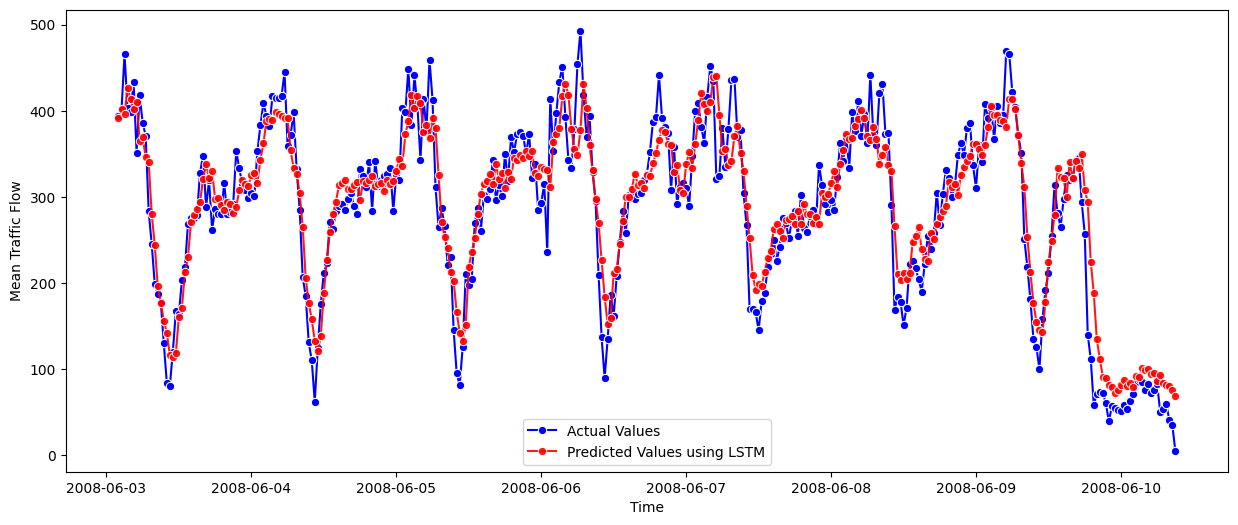

In [87]:
# Select relevant columns from the 'test' DataFrame
select = test[['Time Column','Traffic Flow']]

# Add a new column 'Predictions LSTM' to the 'select' DataFrame containing the LSTM predicted values
select['Predictions LSTM'] = y_pred_lstm

# Print the average traffic flow on all paths grouped by timestamp
grouped_by_timestamps = select[['Traffic Flow', 'Predictions LSTM']].groupby(select['Time Column']).sum()
grouped_by_timestamps = pd.DataFrame(grouped_by_timestamps, index=grouped_by_timestamps.index)

# Create a figure
plt.figure(figsize=(15, 6))

# Plotting actual values in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Traffic Flow',
             data=grouped_by_timestamps,
             color='blue', 
             marker='o',
             alpha=1, 
             label='Actual Values')

# Plotting predicted values using LSTM in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Predictions LSTM',
             data=grouped_by_timestamps,
             color='red', 
             marker='o',
             alpha=0.9, 
             label='Predicted Values using LSTM')

# Set the x-axis label
plt.xlabel('Time')

# Set the y-axis label
plt.ylabel('Mean Traffic Flow')

# Add a legend to the plot
plt.legend(loc='lower center')

# Display the plot
plt.show()

Evaluate the LSTM model

In [88]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  1.3738983063106862
RMSE LSTM score: 2.3009425782670987


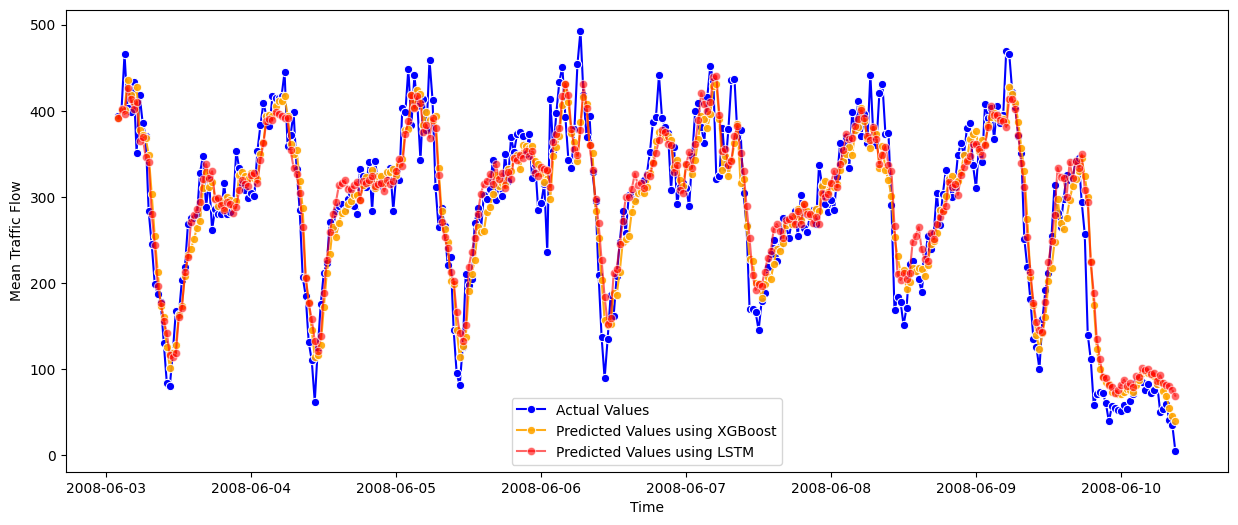

In [89]:
# Select relevant columns from the 'test' DataFrame
select = test[['Time Column','Traffic Flow']]

# Add a new column 'Predictions XGBoost' to the 'select' DataFrame containing the XGBoost predicted values
select['Predictions XGBoost'] = y_pred_xgboost

# Add a new column 'Predictions LSTM' to the 'select' DataFrame containing the LSTM predicted values
select['Predictions LSTM'] = y_pred_lstm

# Print the average traffic flow on all paths grouped by timestamp
grouped_by_timestamps = select[['Traffic Flow', 'Predictions XGBoost', 'Predictions LSTM']].groupby(select['Time Column']).sum()
grouped_by_timestamps = pd.DataFrame(grouped_by_timestamps, index=grouped_by_timestamps.index)

# Create a figure
plt.figure(figsize=(15, 6))

# Plotting actual values in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Traffic Flow',
             data=grouped_by_timestamps,
             color='blue', 
             marker='o',
             alpha=1, 
             label='Actual Values')

# Plotting predicted values using XGBoost in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Predictions XGBoost',
             data=grouped_by_timestamps,
             color='orange', 
             marker='o',
             alpha=0.9, 
             label='Predicted Values using XGBoost')

# Plotting predicted values using LSTM in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Predictions LSTM',
             data=grouped_by_timestamps,
             color='red', 
             marker='o',
             alpha=0.6, 
             label='Predicted Values using LSTM')

# Set the x-axis label
plt.xlabel('Time')

# Set the y-axis label
plt.ylabel('Mean Traffic Flow')

# Add a legend to the plot
plt.legend(loc='lower center')

# Display the plot
plt.show()

In [90]:
# Save XGBoost model to a file
reg.save_model('xgboost_traffic_flow_length-'+str(lookback)+'.model')

In [91]:
# Save the model
model.save("LSTM-length-"+str(lookback)+".h5")

##### Sliding Window Length equals to 5

In [92]:
lookback = 5

In [93]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-06-03']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-06-03']

In [94]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, lookback)
test = generate_X_y_pairs(test, lookback)

In [95]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:lookback].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:lookback].var(axis=1)

In [96]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [97]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:5.07977	validation_1-rmse:5.11632
[1]	validation_0-rmse:4.72301	validation_1-rmse:4.76162
[2]	validation_0-rmse:4.39183	validation_1-rmse:4.43137
[3]	validation_0-rmse:4.10092	validation_1-rmse:4.13922
[4]	validation_0-rmse:3.84708	validation_1-rmse:3.88503
[5]	validation_0-rmse:3.62575	validation_1-rmse:3.66414
[6]	validation_0-rmse:3.43248	validation_1-rmse:3.47212
[7]	validation_0-rmse:3.26759	validation_1-rmse:3.30670
[8]	validation_0-rmse:3.13352	validation_1-rmse:3.17234
[9]	validation_0-rmse:3.01109	validation_1-rmse:3.05168
[10]	validation_0-rmse:2.91020	validation_1-rmse:2.95046
[11]	validation_0-rmse:2.81988	validation_1-rmse:2.86131
[12]	validation_0-rmse:2.74692	validation_1-rmse:2.78847
[13]	validation_0-rmse:2.68128	validation_1-rmse:2.72345
[14]	validation_0-rmse:2.62816	validation_1-rmse:2.66988
[15]	validation_0-rmse:2.58438	validation_1-rmse:2.62619
[16]	validation_0-rmse:2.54877	validation_1-rmse:2.59078
[17]	validation_0-rmse:2.51664	validation

[47]	validation_0-rmse:2.29518	validation_1-rmse:2.35809
[48]	validation_0-rmse:2.29538	validation_1-rmse:2.36065
[49]	validation_0-rmse:2.29490	validation_1-rmse:2.36052
[50]	validation_0-rmse:2.29507	validation_1-rmse:2.36192
[51]	validation_0-rmse:2.29417	validation_1-rmse:2.36249
[0]	validation_0-rmse:5.06434	validation_1-rmse:5.09774
[1]	validation_0-rmse:4.68036	validation_1-rmse:4.71263
[2]	validation_0-rmse:4.34339	validation_1-rmse:4.37636
[3]	validation_0-rmse:4.04749	validation_1-rmse:4.08146
[4]	validation_0-rmse:3.79138	validation_1-rmse:3.82655
[5]	validation_0-rmse:3.56667	validation_1-rmse:3.60277
[6]	validation_0-rmse:3.37373	validation_1-rmse:3.41047
[7]	validation_0-rmse:3.20493	validation_1-rmse:3.24248
[8]	validation_0-rmse:3.06280	validation_1-rmse:3.10052
[9]	validation_0-rmse:2.94016	validation_1-rmse:2.98066
[10]	validation_0-rmse:2.83612	validation_1-rmse:2.87870
[11]	validation_0-rmse:2.74908	validation_1-rmse:2.79160
[12]	validation_0-rmse:2.67592	validation

[67]	validation_0-rmse:2.28364	validation_1-rmse:2.32812
[68]	validation_0-rmse:2.28336	validation_1-rmse:2.32749
[69]	validation_0-rmse:2.28304	validation_1-rmse:2.32718
[70]	validation_0-rmse:2.28295	validation_1-rmse:2.32698
[71]	validation_0-rmse:2.28213	validation_1-rmse:2.32647
[72]	validation_0-rmse:2.28156	validation_1-rmse:2.32608
[73]	validation_0-rmse:2.28158	validation_1-rmse:2.32668
[74]	validation_0-rmse:2.28092	validation_1-rmse:2.32628
[75]	validation_0-rmse:2.28049	validation_1-rmse:2.32640
[76]	validation_0-rmse:2.28009	validation_1-rmse:2.32636
[77]	validation_0-rmse:2.27939	validation_1-rmse:2.32584
[78]	validation_0-rmse:2.27977	validation_1-rmse:2.32638
[79]	validation_0-rmse:2.27833	validation_1-rmse:2.32571
[80]	validation_0-rmse:2.27823	validation_1-rmse:2.32579
[81]	validation_0-rmse:2.27901	validation_1-rmse:2.32700
[82]	validation_0-rmse:2.27774	validation_1-rmse:2.32658
[83]	validation_0-rmse:2.27664	validation_1-rmse:2.32578
[84]	validation_0-rmse:2.27617	

[40]	validation_0-rmse:2.27738	validation_1-rmse:2.33340
[41]	validation_0-rmse:2.27610	validation_1-rmse:2.33201
[42]	validation_0-rmse:2.27473	validation_1-rmse:2.33088
[43]	validation_0-rmse:2.27332	validation_1-rmse:2.32939
[44]	validation_0-rmse:2.27156	validation_1-rmse:2.32805
[45]	validation_0-rmse:2.27030	validation_1-rmse:2.32810
[46]	validation_0-rmse:2.26920	validation_1-rmse:2.32772
[47]	validation_0-rmse:2.26826	validation_1-rmse:2.32730
[48]	validation_0-rmse:2.26747	validation_1-rmse:2.32674
[49]	validation_0-rmse:2.26656	validation_1-rmse:2.32654
[50]	validation_0-rmse:2.26512	validation_1-rmse:2.32519
[51]	validation_0-rmse:2.26439	validation_1-rmse:2.32494
[52]	validation_0-rmse:2.26377	validation_1-rmse:2.32469
[53]	validation_0-rmse:2.26292	validation_1-rmse:2.32501
[54]	validation_0-rmse:2.26169	validation_1-rmse:2.32407
[55]	validation_0-rmse:2.26012	validation_1-rmse:2.32272
[56]	validation_0-rmse:2.25972	validation_1-rmse:2.32242
[57]	validation_0-rmse:2.25905	

[23]	validation_0-rmse:2.39636	validation_1-rmse:2.45496
[24]	validation_0-rmse:2.38239	validation_1-rmse:2.44029
[25]	validation_0-rmse:2.37354	validation_1-rmse:2.43045
[26]	validation_0-rmse:2.36538	validation_1-rmse:2.42328
[27]	validation_0-rmse:2.35726	validation_1-rmse:2.41433
[28]	validation_0-rmse:2.34894	validation_1-rmse:2.40591
[29]	validation_0-rmse:2.34368	validation_1-rmse:2.40133
[30]	validation_0-rmse:2.33874	validation_1-rmse:2.39592
[31]	validation_0-rmse:2.33453	validation_1-rmse:2.39261
[32]	validation_0-rmse:2.33051	validation_1-rmse:2.38912
[33]	validation_0-rmse:2.32614	validation_1-rmse:2.38515
[34]	validation_0-rmse:2.32282	validation_1-rmse:2.38262
[35]	validation_0-rmse:2.31933	validation_1-rmse:2.37955
[36]	validation_0-rmse:2.31628	validation_1-rmse:2.37665
[37]	validation_0-rmse:2.31333	validation_1-rmse:2.37405
[38]	validation_0-rmse:2.31092	validation_1-rmse:2.37195
[39]	validation_0-rmse:2.30861	validation_1-rmse:2.36988
[40]	validation_0-rmse:2.30640	

[43]	validation_0-rmse:2.30142	validation_1-rmse:2.34142
[44]	validation_0-rmse:2.30001	validation_1-rmse:2.33989
[45]	validation_0-rmse:2.29884	validation_1-rmse:2.33923
[46]	validation_0-rmse:2.29827	validation_1-rmse:2.33872
[47]	validation_0-rmse:2.29681	validation_1-rmse:2.33835
[48]	validation_0-rmse:2.29561	validation_1-rmse:2.33754
[49]	validation_0-rmse:2.29427	validation_1-rmse:2.33635
[50]	validation_0-rmse:2.29356	validation_1-rmse:2.33601
[51]	validation_0-rmse:2.29280	validation_1-rmse:2.33582
[52]	validation_0-rmse:2.29172	validation_1-rmse:2.33519
[53]	validation_0-rmse:2.28958	validation_1-rmse:2.33340
[54]	validation_0-rmse:2.28852	validation_1-rmse:2.33277
[55]	validation_0-rmse:2.28782	validation_1-rmse:2.33240
[56]	validation_0-rmse:2.28743	validation_1-rmse:2.33187
[57]	validation_0-rmse:2.28699	validation_1-rmse:2.33144
[58]	validation_0-rmse:2.28585	validation_1-rmse:2.33061
[59]	validation_0-rmse:2.28183	validation_1-rmse:2.32713
[60]	validation_0-rmse:2.28159	

[11]	validation_0-rmse:2.75014	validation_1-rmse:2.79284
[12]	validation_0-rmse:2.67689	validation_1-rmse:2.71981
[13]	validation_0-rmse:2.61555	validation_1-rmse:2.65789
[14]	validation_0-rmse:2.56086	validation_1-rmse:2.60327
[15]	validation_0-rmse:2.51816	validation_1-rmse:2.56006
[16]	validation_0-rmse:2.48015	validation_1-rmse:2.52136
[17]	validation_0-rmse:2.44796	validation_1-rmse:2.48924
[18]	validation_0-rmse:2.42295	validation_1-rmse:2.46490
[19]	validation_0-rmse:2.40135	validation_1-rmse:2.44368
[20]	validation_0-rmse:2.38397	validation_1-rmse:2.42807
[21]	validation_0-rmse:2.36773	validation_1-rmse:2.41218
[22]	validation_0-rmse:2.35256	validation_1-rmse:2.39777
[23]	validation_0-rmse:2.34127	validation_1-rmse:2.38714
[24]	validation_0-rmse:2.33256	validation_1-rmse:2.37822
[25]	validation_0-rmse:2.32471	validation_1-rmse:2.37068
[26]	validation_0-rmse:2.31850	validation_1-rmse:2.36531
[27]	validation_0-rmse:2.31282	validation_1-rmse:2.36007
[28]	validation_0-rmse:2.30821	

[25]	validation_0-rmse:2.26240	validation_1-rmse:2.39292
[26]	validation_0-rmse:2.25155	validation_1-rmse:2.38409
[27]	validation_0-rmse:2.24126	validation_1-rmse:2.37803
[28]	validation_0-rmse:2.23188	validation_1-rmse:2.37013
[29]	validation_0-rmse:2.22400	validation_1-rmse:2.36602
[30]	validation_0-rmse:2.22499	validation_1-rmse:2.36899
[31]	validation_0-rmse:2.22122	validation_1-rmse:2.36736
[32]	validation_0-rmse:2.21588	validation_1-rmse:2.36356
[33]	validation_0-rmse:2.21070	validation_1-rmse:2.36098
[34]	validation_0-rmse:2.20660	validation_1-rmse:2.35854
[35]	validation_0-rmse:2.20991	validation_1-rmse:2.36415
[36]	validation_0-rmse:2.21619	validation_1-rmse:2.37208
[37]	validation_0-rmse:2.21271	validation_1-rmse:2.37176
[38]	validation_0-rmse:2.21228	validation_1-rmse:2.37391
[0]	validation_0-rmse:5.04628	validation_1-rmse:5.08451
[1]	validation_0-rmse:4.64347	validation_1-rmse:4.68343
[2]	validation_0-rmse:4.29107	validation_1-rmse:4.33138
[3]	validation_0-rmse:3.98391	vali

[42]	validation_0-rmse:2.20407	validation_1-rmse:2.37861
[43]	validation_0-rmse:2.20266	validation_1-rmse:2.37809
[44]	validation_0-rmse:2.19983	validation_1-rmse:2.37684
[45]	validation_0-rmse:2.19766	validation_1-rmse:2.37695
[46]	validation_0-rmse:2.19714	validation_1-rmse:2.37686
[47]	validation_0-rmse:2.19477	validation_1-rmse:2.37600
[48]	validation_0-rmse:2.19259	validation_1-rmse:2.37667
[49]	validation_0-rmse:2.18962	validation_1-rmse:2.37591
[50]	validation_0-rmse:2.18846	validation_1-rmse:2.37748
[51]	validation_0-rmse:2.18869	validation_1-rmse:2.37956
[52]	validation_0-rmse:2.18630	validation_1-rmse:2.38031
[53]	validation_0-rmse:2.18290	validation_1-rmse:2.37813
[0]	validation_0-rmse:5.05127	validation_1-rmse:5.08762
[1]	validation_0-rmse:4.65139	validation_1-rmse:4.69192
[2]	validation_0-rmse:4.30061	validation_1-rmse:4.34451
[3]	validation_0-rmse:3.99346	validation_1-rmse:4.04082
[4]	validation_0-rmse:3.72375	validation_1-rmse:3.77131
[5]	validation_0-rmse:3.48777	valida

[24]	validation_0-rmse:2.28554	validation_1-rmse:2.42068
[25]	validation_0-rmse:2.27387	validation_1-rmse:2.41148
[26]	validation_0-rmse:2.26036	validation_1-rmse:2.40060
[27]	validation_0-rmse:2.25067	validation_1-rmse:2.39340
[28]	validation_0-rmse:2.24244	validation_1-rmse:2.38804
[29]	validation_0-rmse:2.23665	validation_1-rmse:2.38560
[30]	validation_0-rmse:2.23117	validation_1-rmse:2.38325
[31]	validation_0-rmse:2.22476	validation_1-rmse:2.38030
[32]	validation_0-rmse:2.22186	validation_1-rmse:2.37979
[33]	validation_0-rmse:2.21611	validation_1-rmse:2.37580
[34]	validation_0-rmse:2.21997	validation_1-rmse:2.38153
[35]	validation_0-rmse:2.21572	validation_1-rmse:2.37924
[36]	validation_0-rmse:2.21110	validation_1-rmse:2.37756
[37]	validation_0-rmse:2.20581	validation_1-rmse:2.37414
[38]	validation_0-rmse:2.20327	validation_1-rmse:2.37418
[39]	validation_0-rmse:2.19904	validation_1-rmse:2.37193
[40]	validation_0-rmse:2.19690	validation_1-rmse:2.37134
[41]	validation_0-rmse:2.19281	

[78]	validation_0-rmse:2.15787	validation_1-rmse:2.30586
[0]	validation_0-rmse:5.06892	validation_1-rmse:5.11055
[1]	validation_0-rmse:4.68846	validation_1-rmse:4.73685
[2]	validation_0-rmse:4.35263	validation_1-rmse:4.40624
[3]	validation_0-rmse:4.05484	validation_1-rmse:4.11744
[4]	validation_0-rmse:3.79691	validation_1-rmse:3.86246
[5]	validation_0-rmse:3.57439	validation_1-rmse:3.64448
[6]	validation_0-rmse:3.38046	validation_1-rmse:3.45567
[7]	validation_0-rmse:3.21762	validation_1-rmse:3.30087
[8]	validation_0-rmse:3.07805	validation_1-rmse:3.16783
[9]	validation_0-rmse:2.95541	validation_1-rmse:3.04975
[10]	validation_0-rmse:2.85321	validation_1-rmse:2.95134
[11]	validation_0-rmse:2.76199	validation_1-rmse:2.86456
[12]	validation_0-rmse:2.68515	validation_1-rmse:2.79462
[13]	validation_0-rmse:2.61719	validation_1-rmse:2.72731
[14]	validation_0-rmse:2.56209	validation_1-rmse:2.67696
[15]	validation_0-rmse:2.51125	validation_1-rmse:2.62740
[16]	validation_0-rmse:2.46976	validation

[12]	validation_0-rmse:2.52432	validation_1-rmse:2.73943
[13]	validation_0-rmse:2.45064	validation_1-rmse:2.67913
[14]	validation_0-rmse:2.39012	validation_1-rmse:2.62911
[15]	validation_0-rmse:2.33397	validation_1-rmse:2.58575
[16]	validation_0-rmse:2.28621	validation_1-rmse:2.55013
[17]	validation_0-rmse:2.24414	validation_1-rmse:2.51862
[18]	validation_0-rmse:2.20697	validation_1-rmse:2.49444
[19]	validation_0-rmse:2.17525	validation_1-rmse:2.47184
[20]	validation_0-rmse:2.14763	validation_1-rmse:2.45297
[21]	validation_0-rmse:2.12640	validation_1-rmse:2.43902
[22]	validation_0-rmse:2.10770	validation_1-rmse:2.42654
[23]	validation_0-rmse:2.09100	validation_1-rmse:2.41648
[24]	validation_0-rmse:2.07374	validation_1-rmse:2.40709
[25]	validation_0-rmse:2.05949	validation_1-rmse:2.40001
[26]	validation_0-rmse:2.04660	validation_1-rmse:2.39525
[27]	validation_0-rmse:2.03488	validation_1-rmse:2.38911
[28]	validation_0-rmse:2.02261	validation_1-rmse:2.38309
[29]	validation_0-rmse:2.01205	

[58]	validation_0-rmse:1.98855	validation_1-rmse:2.37122
[0]	validation_0-rmse:5.06573	validation_1-rmse:5.11495
[1]	validation_0-rmse:4.68743	validation_1-rmse:4.74818
[2]	validation_0-rmse:4.35529	validation_1-rmse:4.42978
[3]	validation_0-rmse:4.05464	validation_1-rmse:4.14791
[4]	validation_0-rmse:3.79812	validation_1-rmse:3.90689
[5]	validation_0-rmse:3.56979	validation_1-rmse:3.69459
[6]	validation_0-rmse:3.36537	validation_1-rmse:3.50508
[7]	validation_0-rmse:3.19401	validation_1-rmse:3.34733
[8]	validation_0-rmse:3.04104	validation_1-rmse:3.21166
[9]	validation_0-rmse:2.91021	validation_1-rmse:3.09482
[10]	validation_0-rmse:2.79618	validation_1-rmse:2.99869
[11]	validation_0-rmse:2.69699	validation_1-rmse:2.91432
[12]	validation_0-rmse:2.60744	validation_1-rmse:2.83651
[13]	validation_0-rmse:2.53296	validation_1-rmse:2.77463
[14]	validation_0-rmse:2.46781	validation_1-rmse:2.72504
[15]	validation_0-rmse:2.41184	validation_1-rmse:2.68101
[16]	validation_0-rmse:2.36308	validation

[13]	validation_0-rmse:2.44785	validation_1-rmse:2.67807
[14]	validation_0-rmse:2.38429	validation_1-rmse:2.62724
[15]	validation_0-rmse:2.32924	validation_1-rmse:2.58544
[16]	validation_0-rmse:2.28223	validation_1-rmse:2.55028
[17]	validation_0-rmse:2.24388	validation_1-rmse:2.52478
[18]	validation_0-rmse:2.21129	validation_1-rmse:2.50430
[19]	validation_0-rmse:2.17908	validation_1-rmse:2.47945
[20]	validation_0-rmse:2.15155	validation_1-rmse:2.45905
[21]	validation_0-rmse:2.12856	validation_1-rmse:2.44470
[22]	validation_0-rmse:2.10617	validation_1-rmse:2.43149
[23]	validation_0-rmse:2.08902	validation_1-rmse:2.42124
[24]	validation_0-rmse:2.07225	validation_1-rmse:2.41046
[25]	validation_0-rmse:2.05708	validation_1-rmse:2.39982
[26]	validation_0-rmse:2.04376	validation_1-rmse:2.39416
[27]	validation_0-rmse:2.03075	validation_1-rmse:2.38917
[28]	validation_0-rmse:2.02459	validation_1-rmse:2.38852
[29]	validation_0-rmse:2.01415	validation_1-rmse:2.38608
[30]	validation_0-rmse:2.00478	

[18]	validation_0-rmse:2.29128	validation_1-rmse:2.59019
[19]	validation_0-rmse:2.25648	validation_1-rmse:2.56206
[20]	validation_0-rmse:2.22623	validation_1-rmse:2.53927
[21]	validation_0-rmse:2.19865	validation_1-rmse:2.52104
[22]	validation_0-rmse:2.17733	validation_1-rmse:2.50675
[23]	validation_0-rmse:2.15752	validation_1-rmse:2.49428
[24]	validation_0-rmse:2.13976	validation_1-rmse:2.48227
[25]	validation_0-rmse:2.12224	validation_1-rmse:2.47088
[26]	validation_0-rmse:2.10794	validation_1-rmse:2.45950
[27]	validation_0-rmse:2.09474	validation_1-rmse:2.44899
[28]	validation_0-rmse:2.08249	validation_1-rmse:2.44159
[29]	validation_0-rmse:2.07144	validation_1-rmse:2.43524
[30]	validation_0-rmse:2.06154	validation_1-rmse:2.42940
[31]	validation_0-rmse:2.05316	validation_1-rmse:2.42388
[32]	validation_0-rmse:2.04529	validation_1-rmse:2.41976
[33]	validation_0-rmse:2.03738	validation_1-rmse:2.41567
[34]	validation_0-rmse:2.03114	validation_1-rmse:2.41284
[35]	validation_0-rmse:2.02452	

[46]	validation_0-rmse:2.30314	validation_1-rmse:2.34354
[47]	validation_0-rmse:2.30191	validation_1-rmse:2.34309
[48]	validation_0-rmse:2.30036	validation_1-rmse:2.34153
[49]	validation_0-rmse:2.29850	validation_1-rmse:2.33994
[50]	validation_0-rmse:2.29783	validation_1-rmse:2.33956
[51]	validation_0-rmse:2.29672	validation_1-rmse:2.33941
[52]	validation_0-rmse:2.29583	validation_1-rmse:2.33861
[53]	validation_0-rmse:2.29526	validation_1-rmse:2.33921
[54]	validation_0-rmse:2.29436	validation_1-rmse:2.33853
[55]	validation_0-rmse:2.29365	validation_1-rmse:2.33788
[56]	validation_0-rmse:2.29266	validation_1-rmse:2.33776
[57]	validation_0-rmse:2.29188	validation_1-rmse:2.33741
[58]	validation_0-rmse:2.29172	validation_1-rmse:2.33701
[59]	validation_0-rmse:2.29042	validation_1-rmse:2.33609
[60]	validation_0-rmse:2.28987	validation_1-rmse:2.33597
[61]	validation_0-rmse:2.28853	validation_1-rmse:2.33516
[62]	validation_0-rmse:2.28810	validation_1-rmse:2.33528
[63]	validation_0-rmse:2.28675	

[39]	validation_0-rmse:2.28036	validation_1-rmse:2.33450
[40]	validation_0-rmse:2.27927	validation_1-rmse:2.33438
[41]	validation_0-rmse:2.27751	validation_1-rmse:2.33286
[42]	validation_0-rmse:2.27596	validation_1-rmse:2.33191
[43]	validation_0-rmse:2.27385	validation_1-rmse:2.33053
[44]	validation_0-rmse:2.27266	validation_1-rmse:2.32952
[45]	validation_0-rmse:2.27146	validation_1-rmse:2.32886
[46]	validation_0-rmse:2.27016	validation_1-rmse:2.32829
[47]	validation_0-rmse:2.26778	validation_1-rmse:2.32654
[48]	validation_0-rmse:2.26675	validation_1-rmse:2.32626
[49]	validation_0-rmse:2.26586	validation_1-rmse:2.32503
[50]	validation_0-rmse:2.26508	validation_1-rmse:2.32519
[51]	validation_0-rmse:2.26431	validation_1-rmse:2.32480
[52]	validation_0-rmse:2.26247	validation_1-rmse:2.32326
[53]	validation_0-rmse:2.26178	validation_1-rmse:2.32268
[54]	validation_0-rmse:2.26036	validation_1-rmse:2.32197
[55]	validation_0-rmse:2.25809	validation_1-rmse:2.32021
[56]	validation_0-rmse:2.25679	

[27]	validation_0-rmse:2.35519	validation_1-rmse:2.41436
[28]	validation_0-rmse:2.34898	validation_1-rmse:2.40915
[29]	validation_0-rmse:2.34108	validation_1-rmse:2.40062
[30]	validation_0-rmse:2.33578	validation_1-rmse:2.39565
[31]	validation_0-rmse:2.33239	validation_1-rmse:2.39289
[32]	validation_0-rmse:2.32809	validation_1-rmse:2.38851
[33]	validation_0-rmse:2.32419	validation_1-rmse:2.38520
[34]	validation_0-rmse:2.32089	validation_1-rmse:2.38234
[35]	validation_0-rmse:2.31717	validation_1-rmse:2.37914
[36]	validation_0-rmse:2.31448	validation_1-rmse:2.37692
[37]	validation_0-rmse:2.31169	validation_1-rmse:2.37517
[38]	validation_0-rmse:2.30934	validation_1-rmse:2.37311
[39]	validation_0-rmse:2.30708	validation_1-rmse:2.37162
[40]	validation_0-rmse:2.30544	validation_1-rmse:2.37062
[41]	validation_0-rmse:2.30357	validation_1-rmse:2.36880
[42]	validation_0-rmse:2.30151	validation_1-rmse:2.36720
[43]	validation_0-rmse:2.30068	validation_1-rmse:2.36750
[44]	validation_0-rmse:2.29997	

[7]	validation_0-rmse:3.26761	validation_1-rmse:3.30671
[8]	validation_0-rmse:3.13353	validation_1-rmse:3.17235
[9]	validation_0-rmse:3.01110	validation_1-rmse:3.05169
[10]	validation_0-rmse:2.91021	validation_1-rmse:2.95047
[11]	validation_0-rmse:2.81989	validation_1-rmse:2.86132
[12]	validation_0-rmse:2.74693	validation_1-rmse:2.78848
[13]	validation_0-rmse:2.68130	validation_1-rmse:2.72347
[14]	validation_0-rmse:2.62817	validation_1-rmse:2.66990
[15]	validation_0-rmse:2.58439	validation_1-rmse:2.62620
[16]	validation_0-rmse:2.54878	validation_1-rmse:2.59079
[17]	validation_0-rmse:2.51666	validation_1-rmse:2.55885
[18]	validation_0-rmse:2.48630	validation_1-rmse:2.52821
[19]	validation_0-rmse:2.46286	validation_1-rmse:2.50175
[20]	validation_0-rmse:2.44409	validation_1-rmse:2.48338
[21]	validation_0-rmse:2.42621	validation_1-rmse:2.46631
[22]	validation_0-rmse:2.41049	validation_1-rmse:2.45083
[23]	validation_0-rmse:2.39618	validation_1-rmse:2.43597
[24]	validation_0-rmse:2.38375	val

[15]	validation_0-rmse:2.51752	validation_1-rmse:2.55892
[16]	validation_0-rmse:2.48159	validation_1-rmse:2.52459
[17]	validation_0-rmse:2.44869	validation_1-rmse:2.49163
[18]	validation_0-rmse:2.42279	validation_1-rmse:2.46498
[19]	validation_0-rmse:2.40104	validation_1-rmse:2.44367
[20]	validation_0-rmse:2.38370	validation_1-rmse:2.42702
[21]	validation_0-rmse:2.36733	validation_1-rmse:2.41113
[22]	validation_0-rmse:2.35355	validation_1-rmse:2.39808
[23]	validation_0-rmse:2.34119	validation_1-rmse:2.38633
[24]	validation_0-rmse:2.33249	validation_1-rmse:2.37783
[25]	validation_0-rmse:2.32508	validation_1-rmse:2.37115
[26]	validation_0-rmse:2.31848	validation_1-rmse:2.36536
[27]	validation_0-rmse:2.31266	validation_1-rmse:2.36032
[28]	validation_0-rmse:2.30796	validation_1-rmse:2.35614
[29]	validation_0-rmse:2.30498	validation_1-rmse:2.35385
[30]	validation_0-rmse:2.30160	validation_1-rmse:2.35068
[31]	validation_0-rmse:2.29844	validation_1-rmse:2.34842
[32]	validation_0-rmse:2.29537	

[87]	validation_0-rmse:2.27299	validation_1-rmse:2.32115
[88]	validation_0-rmse:2.27236	validation_1-rmse:2.32071
[89]	validation_0-rmse:2.27367	validation_1-rmse:2.32226
[90]	validation_0-rmse:2.27312	validation_1-rmse:2.32188
[0]	validation_0-rmse:5.08023	validation_1-rmse:5.11592
[1]	validation_0-rmse:4.70876	validation_1-rmse:4.74416
[2]	validation_0-rmse:4.38062	validation_1-rmse:4.41742
[3]	validation_0-rmse:4.09307	validation_1-rmse:4.12892
[4]	validation_0-rmse:3.84204	validation_1-rmse:3.87900
[5]	validation_0-rmse:3.61936	validation_1-rmse:3.65875
[6]	validation_0-rmse:3.42857	validation_1-rmse:3.46783
[7]	validation_0-rmse:3.26453	validation_1-rmse:3.30440
[8]	validation_0-rmse:3.12228	validation_1-rmse:3.16263
[9]	validation_0-rmse:2.99959	validation_1-rmse:3.04095
[10]	validation_0-rmse:2.90142	validation_1-rmse:2.94641
[11]	validation_0-rmse:2.81263	validation_1-rmse:2.85750
[12]	validation_0-rmse:2.74009	validation_1-rmse:2.78669
[13]	validation_0-rmse:2.67976	validation

[54]	validation_0-rmse:2.26315	validation_1-rmse:2.32360
[55]	validation_0-rmse:2.26191	validation_1-rmse:2.32276
[56]	validation_0-rmse:2.26155	validation_1-rmse:2.32304
[57]	validation_0-rmse:2.26103	validation_1-rmse:2.32296
[58]	validation_0-rmse:2.25821	validation_1-rmse:2.32008
[59]	validation_0-rmse:2.25728	validation_1-rmse:2.31941
[60]	validation_0-rmse:2.25583	validation_1-rmse:2.31818
[61]	validation_0-rmse:2.25541	validation_1-rmse:2.31805
[62]	validation_0-rmse:2.25354	validation_1-rmse:2.31708
[63]	validation_0-rmse:2.25271	validation_1-rmse:2.31705
[64]	validation_0-rmse:2.25198	validation_1-rmse:2.31673
[65]	validation_0-rmse:2.25136	validation_1-rmse:2.31708
[66]	validation_0-rmse:2.24998	validation_1-rmse:2.31648
[67]	validation_0-rmse:2.24815	validation_1-rmse:2.31529
[68]	validation_0-rmse:2.24777	validation_1-rmse:2.31530
[69]	validation_0-rmse:2.24722	validation_1-rmse:2.31462
[70]	validation_0-rmse:2.24696	validation_1-rmse:2.31456
[71]	validation_0-rmse:2.24632	

[28]	validation_0-rmse:2.17124	validation_1-rmse:2.31562
[29]	validation_0-rmse:2.16497	validation_1-rmse:2.31011
[30]	validation_0-rmse:2.16104	validation_1-rmse:2.30884
[31]	validation_0-rmse:2.15715	validation_1-rmse:2.30830
[32]	validation_0-rmse:2.15193	validation_1-rmse:2.30429
[33]	validation_0-rmse:2.14972	validation_1-rmse:2.30407
[34]	validation_0-rmse:2.14595	validation_1-rmse:2.30233
[35]	validation_0-rmse:2.14279	validation_1-rmse:2.30096
[36]	validation_0-rmse:2.14099	validation_1-rmse:2.30073
[37]	validation_0-rmse:2.13847	validation_1-rmse:2.30087
[38]	validation_0-rmse:2.13825	validation_1-rmse:2.30268
[39]	validation_0-rmse:2.13795	validation_1-rmse:2.30383
[40]	validation_0-rmse:2.13500	validation_1-rmse:2.30293
[41]	validation_0-rmse:2.13264	validation_1-rmse:2.30192
[0]	validation_0-rmse:5.07384	validation_1-rmse:5.11008
[1]	validation_0-rmse:4.70286	validation_1-rmse:4.73747
[2]	validation_0-rmse:4.37419	validation_1-rmse:4.41156
[3]	validation_0-rmse:4.09008	vali

[29]	validation_0-rmse:2.16490	validation_1-rmse:2.30388
[30]	validation_0-rmse:2.16169	validation_1-rmse:2.30108
[31]	validation_0-rmse:2.15738	validation_1-rmse:2.29887
[32]	validation_0-rmse:2.15351	validation_1-rmse:2.29627
[33]	validation_0-rmse:2.15060	validation_1-rmse:2.29478
[34]	validation_0-rmse:2.14936	validation_1-rmse:2.29815
[35]	validation_0-rmse:2.14531	validation_1-rmse:2.29715
[36]	validation_0-rmse:2.14341	validation_1-rmse:2.29663
[37]	validation_0-rmse:2.14112	validation_1-rmse:2.29611
[38]	validation_0-rmse:2.13776	validation_1-rmse:2.29510
[0]	validation_0-rmse:5.07126	validation_1-rmse:5.10580
[1]	validation_0-rmse:4.69309	validation_1-rmse:4.72942
[2]	validation_0-rmse:4.36673	validation_1-rmse:4.40211
[3]	validation_0-rmse:4.06519	validation_1-rmse:4.10527
[4]	validation_0-rmse:3.81250	validation_1-rmse:3.84913
[5]	validation_0-rmse:3.58685	validation_1-rmse:3.62436
[6]	validation_0-rmse:3.38779	validation_1-rmse:3.42984
[7]	validation_0-rmse:3.21456	validati

[20]	validation_0-rmse:2.24409	validation_1-rmse:2.36866
[21]	validation_0-rmse:2.22780	validation_1-rmse:2.35806
[22]	validation_0-rmse:2.21572	validation_1-rmse:2.34883
[23]	validation_0-rmse:2.20543	validation_1-rmse:2.34141
[24]	validation_0-rmse:2.19540	validation_1-rmse:2.33473
[25]	validation_0-rmse:2.18866	validation_1-rmse:2.32994
[26]	validation_0-rmse:2.18156	validation_1-rmse:2.32401
[27]	validation_0-rmse:2.17655	validation_1-rmse:2.31975
[28]	validation_0-rmse:2.17040	validation_1-rmse:2.31662
[29]	validation_0-rmse:2.16619	validation_1-rmse:2.31501
[30]	validation_0-rmse:2.16334	validation_1-rmse:2.31369
[31]	validation_0-rmse:2.16170	validation_1-rmse:2.31493
[32]	validation_0-rmse:2.15779	validation_1-rmse:2.31188
[33]	validation_0-rmse:2.15462	validation_1-rmse:2.31013
[34]	validation_0-rmse:2.15326	validation_1-rmse:2.31100
[35]	validation_0-rmse:2.15041	validation_1-rmse:2.31052
[36]	validation_0-rmse:2.14954	validation_1-rmse:2.31028
[37]	validation_0-rmse:2.14729	

[41]	validation_0-rmse:2.20460	validation_1-rmse:2.37800
[42]	validation_0-rmse:2.20224	validation_1-rmse:2.37809
[43]	validation_0-rmse:2.20038	validation_1-rmse:2.37840
[44]	validation_0-rmse:2.19547	validation_1-rmse:2.37593
[45]	validation_0-rmse:2.19292	validation_1-rmse:2.37611
[46]	validation_0-rmse:2.19020	validation_1-rmse:2.37731
[47]	validation_0-rmse:2.18647	validation_1-rmse:2.37522
[48]	validation_0-rmse:2.18655	validation_1-rmse:2.37699
[49]	validation_0-rmse:2.17855	validation_1-rmse:2.36862
[50]	validation_0-rmse:2.17866	validation_1-rmse:2.36986
[51]	validation_0-rmse:2.17657	validation_1-rmse:2.37304
[52]	validation_0-rmse:2.17616	validation_1-rmse:2.37360
[53]	validation_0-rmse:2.17475	validation_1-rmse:2.37367
[54]	validation_0-rmse:2.17401	validation_1-rmse:2.37413
[0]	validation_0-rmse:5.05124	validation_1-rmse:5.08734
[1]	validation_0-rmse:4.65139	validation_1-rmse:4.69167
[2]	validation_0-rmse:4.30064	validation_1-rmse:4.34430
[3]	validation_0-rmse:3.99358	vali

[44]	validation_0-rmse:1.91946	validation_1-rmse:2.35339
[45]	validation_0-rmse:1.91524	validation_1-rmse:2.35346
[46]	validation_0-rmse:1.91270	validation_1-rmse:2.35390
[47]	validation_0-rmse:1.90765	validation_1-rmse:2.35420
[48]	validation_0-rmse:1.90504	validation_1-rmse:2.35401
[0]	validation_0-rmse:5.02558	validation_1-rmse:5.06307
[1]	validation_0-rmse:4.60690	validation_1-rmse:4.66133
[2]	validation_0-rmse:4.23640	validation_1-rmse:4.29374
[3]	validation_0-rmse:3.90906	validation_1-rmse:3.97214
[4]	validation_0-rmse:3.62459	validation_1-rmse:3.70556
[5]	validation_0-rmse:3.37822	validation_1-rmse:3.47672
[6]	validation_0-rmse:3.16382	validation_1-rmse:3.27954
[7]	validation_0-rmse:2.98017	validation_1-rmse:3.11265
[8]	validation_0-rmse:2.82342	validation_1-rmse:2.97399
[9]	validation_0-rmse:2.68692	validation_1-rmse:2.85858
[10]	validation_0-rmse:2.57015	validation_1-rmse:2.76283
[11]	validation_0-rmse:2.47269	validation_1-rmse:2.68392
[12]	validation_0-rmse:2.38944	validation

[33]	validation_0-rmse:2.02778	validation_1-rmse:2.40800
[34]	validation_0-rmse:2.02296	validation_1-rmse:2.40410
[35]	validation_0-rmse:2.01630	validation_1-rmse:2.40068
[36]	validation_0-rmse:2.00838	validation_1-rmse:2.39798
[37]	validation_0-rmse:2.00216	validation_1-rmse:2.39504
[38]	validation_0-rmse:1.99566	validation_1-rmse:2.39361
[39]	validation_0-rmse:1.99040	validation_1-rmse:2.39163
[40]	validation_0-rmse:1.98456	validation_1-rmse:2.39134
[41]	validation_0-rmse:1.97854	validation_1-rmse:2.38932
[42]	validation_0-rmse:1.97451	validation_1-rmse:2.38664
[43]	validation_0-rmse:1.97165	validation_1-rmse:2.38538
[44]	validation_0-rmse:1.96674	validation_1-rmse:2.38343
[45]	validation_0-rmse:1.96257	validation_1-rmse:2.38392
[46]	validation_0-rmse:1.95747	validation_1-rmse:2.38357
[47]	validation_0-rmse:1.95233	validation_1-rmse:2.38162
[48]	validation_0-rmse:1.94669	validation_1-rmse:2.38212
[49]	validation_0-rmse:1.94353	validation_1-rmse:2.38220
[50]	validation_0-rmse:1.94181	

[51]	validation_0-rmse:1.87724	validation_1-rmse:2.34560
[52]	validation_0-rmse:1.87390	validation_1-rmse:2.34589
[53]	validation_0-rmse:1.86916	validation_1-rmse:2.34482
[54]	validation_0-rmse:1.86691	validation_1-rmse:2.34556
[55]	validation_0-rmse:1.86406	validation_1-rmse:2.34538
[56]	validation_0-rmse:1.86266	validation_1-rmse:2.34482
[57]	validation_0-rmse:1.85564	validation_1-rmse:2.34188
[58]	validation_0-rmse:1.85409	validation_1-rmse:2.34167
[59]	validation_0-rmse:1.85225	validation_1-rmse:2.34117
[60]	validation_0-rmse:1.84846	validation_1-rmse:2.34073
[61]	validation_0-rmse:1.84620	validation_1-rmse:2.34067
[62]	validation_0-rmse:1.84244	validation_1-rmse:2.34005
[63]	validation_0-rmse:1.84074	validation_1-rmse:2.34065
[64]	validation_0-rmse:1.83816	validation_1-rmse:2.34074
[65]	validation_0-rmse:1.83597	validation_1-rmse:2.34023
[66]	validation_0-rmse:1.83535	validation_1-rmse:2.34159
[0]	validation_0-rmse:5.02589	validation_1-rmse:5.06485
[1]	validation_0-rmse:4.60715	va

[44]	validation_0-rmse:1.98110	validation_1-rmse:2.40564
[45]	validation_0-rmse:1.97606	validation_1-rmse:2.40590
[46]	validation_0-rmse:1.97168	validation_1-rmse:2.40543
[47]	validation_0-rmse:1.96659	validation_1-rmse:2.40488
[48]	validation_0-rmse:1.96225	validation_1-rmse:2.40490
[49]	validation_0-rmse:1.95328	validation_1-rmse:2.39938
[50]	validation_0-rmse:1.94930	validation_1-rmse:2.39848
[51]	validation_0-rmse:1.94528	validation_1-rmse:2.39837
[52]	validation_0-rmse:1.94266	validation_1-rmse:2.39887
[53]	validation_0-rmse:1.93885	validation_1-rmse:2.39830
[54]	validation_0-rmse:1.93553	validation_1-rmse:2.39743
[55]	validation_0-rmse:1.93247	validation_1-rmse:2.39736
[56]	validation_0-rmse:1.92869	validation_1-rmse:2.39647
[57]	validation_0-rmse:1.92386	validation_1-rmse:2.39600
[58]	validation_0-rmse:1.92201	validation_1-rmse:2.39751
[59]	validation_0-rmse:1.92012	validation_1-rmse:2.39800
[60]	validation_0-rmse:1.91557	validation_1-rmse:2.39841
[61]	validation_0-rmse:1.91278	

[88]	validation_0-rmse:2.21497	validation_1-rmse:2.28604
[89]	validation_0-rmse:2.21356	validation_1-rmse:2.28483
[90]	validation_0-rmse:2.21241	validation_1-rmse:2.28399
[91]	validation_0-rmse:2.21134	validation_1-rmse:2.28326
[92]	validation_0-rmse:2.21041	validation_1-rmse:2.28274
[93]	validation_0-rmse:2.20944	validation_1-rmse:2.28220
[94]	validation_0-rmse:2.20860	validation_1-rmse:2.28294
[95]	validation_0-rmse:2.20784	validation_1-rmse:2.28351
[96]	validation_0-rmse:2.20680	validation_1-rmse:2.28295
[97]	validation_0-rmse:2.20598	validation_1-rmse:2.28245
Best Hyperparameters:  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'objective': 'reg:squarederror', 'reg_alpha': 0.1, 'reg_lambda': 1}
Best Score:  -5.690316975900803


**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [98]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)])

[0]	validation_0-rmse:5.07434	validation_1-rmse:5.10983
[1]	validation_0-rmse:4.69670	validation_1-rmse:4.73362
[2]	validation_0-rmse:4.36531	validation_1-rmse:4.40379
[3]	validation_0-rmse:4.07474	validation_1-rmse:4.11380
[4]	validation_0-rmse:3.81937	validation_1-rmse:3.85900
[5]	validation_0-rmse:3.59766	validation_1-rmse:3.63765
[6]	validation_0-rmse:3.40640	validation_1-rmse:3.44604
[7]	validation_0-rmse:3.24126	validation_1-rmse:3.28195
[8]	validation_0-rmse:3.09714	validation_1-rmse:3.13845
[9]	validation_0-rmse:2.97466	validation_1-rmse:3.01611
[10]	validation_0-rmse:2.86923	validation_1-rmse:2.91149
[11]	validation_0-rmse:2.78050	validation_1-rmse:2.82230
[12]	validation_0-rmse:2.70535	validation_1-rmse:2.74876
[13]	validation_0-rmse:2.64077	validation_1-rmse:2.68383
[14]	validation_0-rmse:2.58712	validation_1-rmse:2.62973
[15]	validation_0-rmse:2.54183	validation_1-rmse:2.58527
[16]	validation_0-rmse:2.50368	validation_1-rmse:2.54752
[17]	validation_0-rmse:2.47153	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Make predictions on the test set

In [99]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

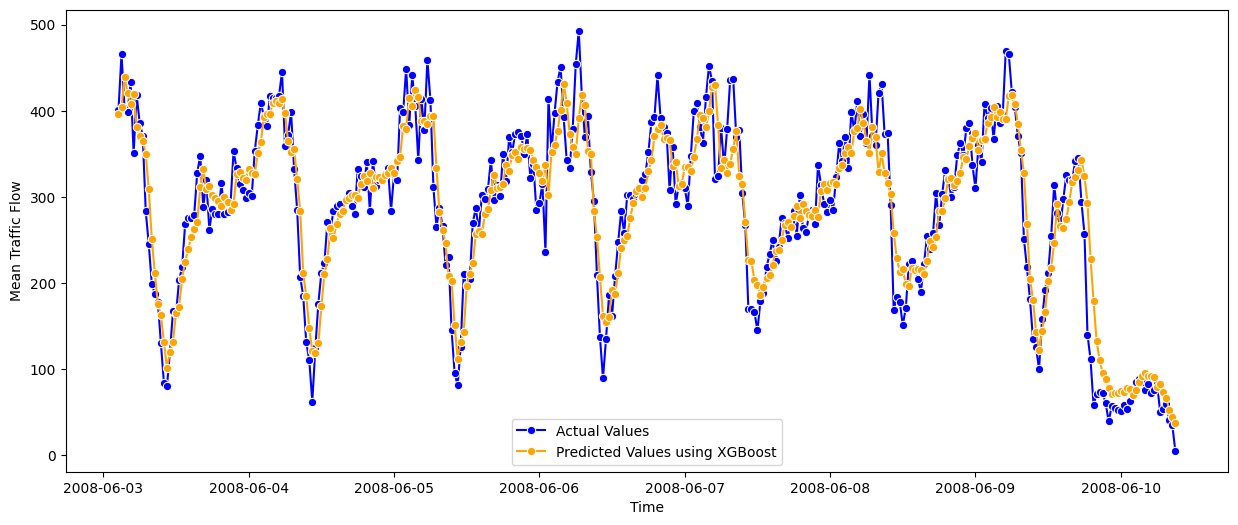

In [100]:
# Select relevant columns from the 'test' DataFrame
select = test[['Time Column','Traffic Flow']]

# Add a new column 'Predictions LSTM' to the 'select' DataFrame containing the LSTM predicted values
select['Predictions XGBoost'] = y_pred_xgboost

# Print the average traffic flow on all paths grouped by timestamp
grouped_by_timestamps = select[['Traffic Flow', 'Predictions XGBoost']].groupby(select['Time Column']).sum()
grouped_by_timestamps = pd.DataFrame(grouped_by_timestamps, index=grouped_by_timestamps.index)

# Create a figure
plt.figure(figsize=(15, 6))

# Plotting actual values in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Traffic Flow',
             data=grouped_by_timestamps,
             color='blue', 
             marker='o',
             alpha=1, 
             label='Actual Values')

# Plotting predicted values using LSTM in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Predictions XGBoost',
             data=grouped_by_timestamps,
             color='orange', 
             marker='o',
             alpha=1, 
             label='Predicted Values using XGBoost')

# Set the x-axis label
plt.xlabel('Time')

# Set the y-axis label
plt.ylabel('Mean Traffic Flow')

# Add a legend to the plot
plt.legend(loc='lower center')

# Display the plot
plt.show()

In [101]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.2870923901568483
RMSE score: 2.2821952204238425


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [102]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [103]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [104]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [105]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='linear'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [106]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [107]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 13s 83ms/step - loss: 0.0064 - val_loss: 0.0029
Epoch 2/50
100/100 [==============================] - 7s 72ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 3/50
100/100 [==============================] - 8s 75ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 4/50
100/100 [==============================] - 7s 74ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 5/50
100/100 [==============================] - 7s 73ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 6/50
100/100 [==============================] - 7s 72ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 7/50
100/100 [==============================] - 7s 69ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 8/50
100/100 [==============================] - 5s 52ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 9/50
100/100 [==============================] - 7s 73ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 10/50
100/100 [==============================] - 7s 71ms/step - loss: 0.0018 - val_l

In [108]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

1094/1094 [==============================] - 10s 9ms/step - loss: 0.0011
Test Loss: 0.0010798524599522352


In [109]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

1094/1094 [==============================] - 10s 8ms/step


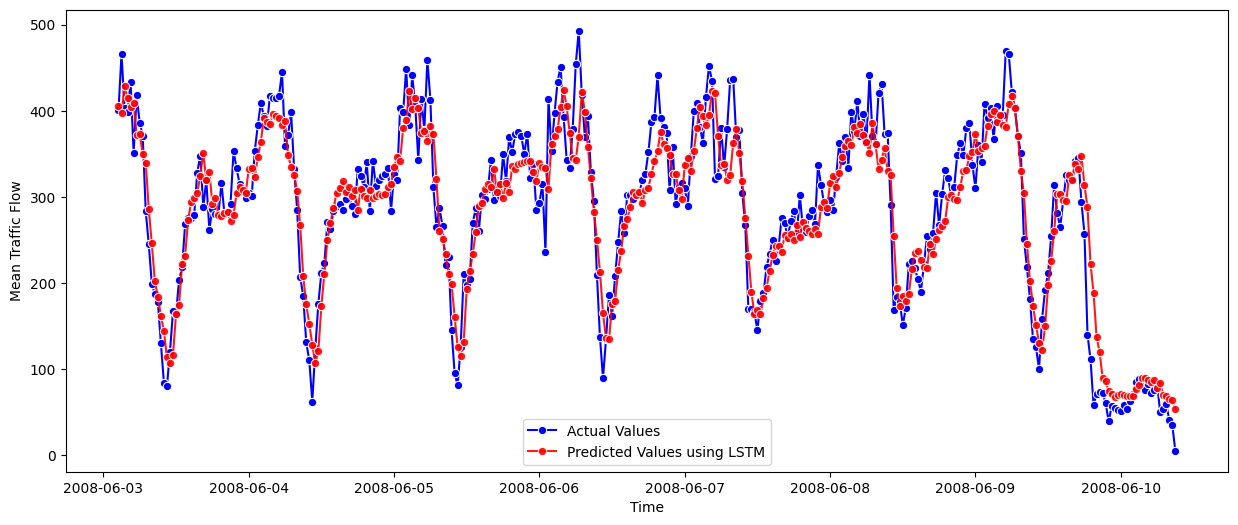

In [110]:
# Select relevant columns from the 'test' DataFrame
select = test[['Time Column','Traffic Flow']]

# Add a new column 'Predictions LSTM' to the 'select' DataFrame containing the LSTM predicted values
select['Predictions LSTM'] = y_pred_lstm

# Print the average traffic flow on all paths grouped by timestamp
grouped_by_timestamps = select[['Traffic Flow', 'Predictions LSTM']].groupby(select['Time Column']).sum()
grouped_by_timestamps = pd.DataFrame(grouped_by_timestamps, index=grouped_by_timestamps.index)

# Create a figure
plt.figure(figsize=(15, 6))

# Plotting actual values in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Traffic Flow',
             data=grouped_by_timestamps,
             color='blue', 
             marker='o',
             alpha=1, 
             label='Actual Values')

# Plotting predicted values using LSTM in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Predictions LSTM',
             data=grouped_by_timestamps,
             color='red', 
             marker='o',
             alpha=0.9, 
             label='Predicted Values using LSTM')

# Set the x-axis label
plt.xlabel('Time')

# Set the y-axis label
plt.ylabel('Mean Traffic Flow')

# Add a legend to the plot
plt.legend(loc='lower center')

# Display the plot
plt.show()

Evaluate the LSTM model

In [111]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  1.3189737750225834
RMSE LSTM score: 2.3002786977383827


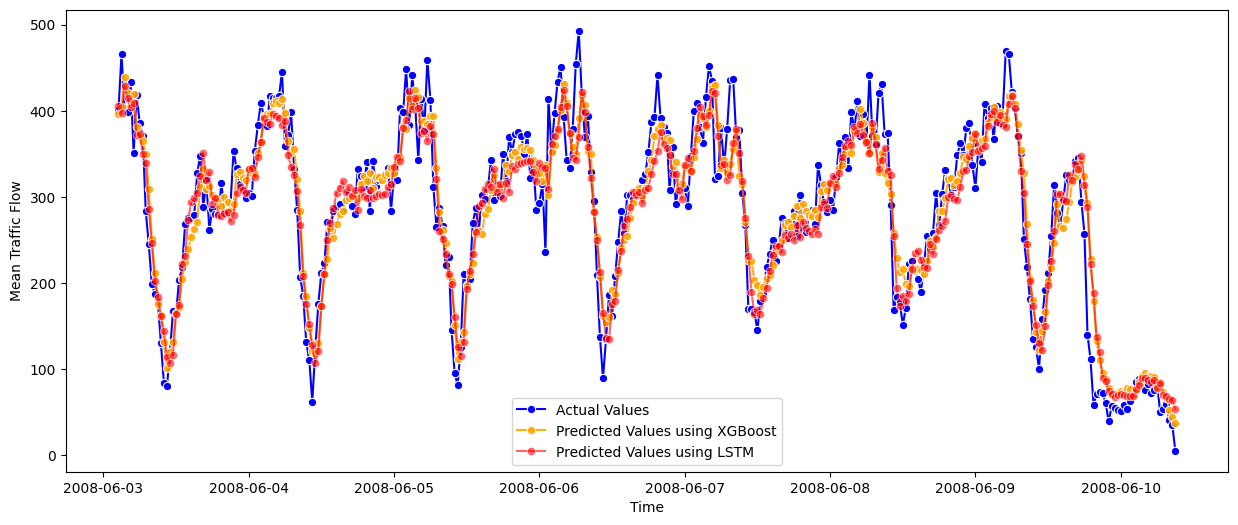

In [112]:
# Select relevant columns from the 'test' DataFrame
select = test[['Time Column','Traffic Flow']]

# Add a new column 'Predictions XGBoost' to the 'select' DataFrame containing the XGBoost predicted values
select['Predictions XGBoost'] = y_pred_xgboost

# Add a new column 'Predictions LSTM' to the 'select' DataFrame containing the LSTM predicted values
select['Predictions LSTM'] = y_pred_lstm

# Print the average traffic flow on all paths grouped by timestamp
grouped_by_timestamps = select[['Traffic Flow', 'Predictions XGBoost', 'Predictions LSTM']].groupby(select['Time Column']).sum()
grouped_by_timestamps = pd.DataFrame(grouped_by_timestamps, index=grouped_by_timestamps.index)

# Create a figure
plt.figure(figsize=(15, 6))

# Plotting actual values in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Traffic Flow',
             data=grouped_by_timestamps,
             color='blue', 
             marker='o',
             alpha=1, 
             label='Actual Values')

# Plotting predicted values using XGBoost in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Predictions XGBoost',
             data=grouped_by_timestamps,
             color='orange', 
             marker='o',
             alpha=0.9, 
             label='Predicted Values using XGBoost')

# Plotting predicted values using LSTM in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Predictions LSTM',
             data=grouped_by_timestamps,
             color='red', 
             marker='o',
             alpha=0.6, 
             label='Predicted Values using LSTM')

# Set the x-axis label
plt.xlabel('Time')

# Set the y-axis label
plt.ylabel('Mean Traffic Flow')

# Add a legend to the plot
plt.legend(loc='lower center')

# Display the plot
plt.show()

In [113]:
# Save XGBoost model to a file
reg.save_model('xgboost_traffic_flow_length-'+str(lookback)+'.model')

In [114]:
# Save the model
model.save("Models/LSTM-length-"+str(lookback)+".h5")

##### Sliding Window Length Equal to 6

In [115]:
lookback = 6

In [116]:
# Define train data
train= traffic_flow.loc[traffic_flow['Time Column'] < '2008-06-03']

# Define test data
test = traffic_flow.loc[traffic_flow['Time Column'] >= '2008-06-03']

In [117]:
# Convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train, lookback)
test = generate_X_y_pairs(test, lookback)

In [118]:
# Add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

# Add rolling var information
train['rolling_var'] = 0
test['rolling_var'] = 0

# Calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:lookback].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:lookback].mean(axis=1)

# Calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:lookback].var(axis=1)

In [119]:
# Define features
features = train.drop(removable_items,axis=1).columns

# Define labels
labels = ['Record 1(t)']

# Create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# Create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

**Apply GridSearchCV**

Use a 3-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [120]:
# Tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [100],
    "learning_rate": [0.1],
    "max_depth": [3,6,9],
    "objective":['reg:squarederror'],
    "gamma": [0,0.1],
    "reg_lambda": [0,1],
    'reg_alpha': [0, 0.1]
}

# Define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        scoring= "neg_mean_squared_error")

# Train on train data using 3 fold Cross Validation
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

[0]	validation_0-rmse:5.08055	validation_1-rmse:5.11246
[1]	validation_0-rmse:4.72401	validation_1-rmse:4.75856
[2]	validation_0-rmse:4.39366	validation_1-rmse:4.42964
[3]	validation_0-rmse:4.10364	validation_1-rmse:4.14091
[4]	validation_0-rmse:3.85106	validation_1-rmse:3.89008
[5]	validation_0-rmse:3.63955	validation_1-rmse:3.67817
[6]	validation_0-rmse:3.44676	validation_1-rmse:3.48442
[7]	validation_0-rmse:3.29047	validation_1-rmse:3.32867
[8]	validation_0-rmse:3.15222	validation_1-rmse:3.18955
[9]	validation_0-rmse:3.02745	validation_1-rmse:3.06585
[10]	validation_0-rmse:2.92114	validation_1-rmse:2.96006
[11]	validation_0-rmse:2.83041	validation_1-rmse:2.86942
[12]	validation_0-rmse:2.75429	validation_1-rmse:2.79249
[13]	validation_0-rmse:2.69375	validation_1-rmse:2.73138
[14]	validation_0-rmse:2.63806	validation_1-rmse:2.67637
[15]	validation_0-rmse:2.59320	validation_1-rmse:2.63065
[16]	validation_0-rmse:2.55397	validation_1-rmse:2.59135
[17]	validation_0-rmse:2.52143	validation

[45]	validation_0-rmse:2.30433	validation_1-rmse:2.38247
[46]	validation_0-rmse:2.30319	validation_1-rmse:2.38297
[47]	validation_0-rmse:2.30340	validation_1-rmse:2.38641
[0]	validation_0-rmse:5.06570	validation_1-rmse:5.09633
[1]	validation_0-rmse:4.68268	validation_1-rmse:4.71265
[2]	validation_0-rmse:4.34590	validation_1-rmse:4.37667
[3]	validation_0-rmse:4.04981	validation_1-rmse:4.08321
[4]	validation_0-rmse:3.79336	validation_1-rmse:3.82640
[5]	validation_0-rmse:3.56930	validation_1-rmse:3.60434
[6]	validation_0-rmse:3.37616	validation_1-rmse:3.41150
[7]	validation_0-rmse:3.20814	validation_1-rmse:3.24510
[8]	validation_0-rmse:3.06497	validation_1-rmse:3.10385
[9]	validation_0-rmse:2.94406	validation_1-rmse:2.98531
[10]	validation_0-rmse:2.84100	validation_1-rmse:2.88162
[11]	validation_0-rmse:2.75286	validation_1-rmse:2.79372
[12]	validation_0-rmse:2.67953	validation_1-rmse:2.72172
[13]	validation_0-rmse:2.61828	validation_1-rmse:2.66042
[14]	validation_0-rmse:2.56452	validation

[64]	validation_0-rmse:2.28786	validation_1-rmse:2.33588
[65]	validation_0-rmse:2.28757	validation_1-rmse:2.33558
[66]	validation_0-rmse:2.28670	validation_1-rmse:2.33488
[67]	validation_0-rmse:2.28574	validation_1-rmse:2.33461
[68]	validation_0-rmse:2.28547	validation_1-rmse:2.33451
[69]	validation_0-rmse:2.28526	validation_1-rmse:2.33415
[70]	validation_0-rmse:2.28415	validation_1-rmse:2.33330
[71]	validation_0-rmse:2.28339	validation_1-rmse:2.33297
[72]	validation_0-rmse:2.28260	validation_1-rmse:2.33209
[73]	validation_0-rmse:2.28191	validation_1-rmse:2.33142
[74]	validation_0-rmse:2.28113	validation_1-rmse:2.33114
[75]	validation_0-rmse:2.28038	validation_1-rmse:2.33062
[76]	validation_0-rmse:2.28026	validation_1-rmse:2.33053
[77]	validation_0-rmse:2.28015	validation_1-rmse:2.33041
[78]	validation_0-rmse:2.27925	validation_1-rmse:2.33025
[79]	validation_0-rmse:2.27715	validation_1-rmse:2.32860
[80]	validation_0-rmse:2.27704	validation_1-rmse:2.32852
[81]	validation_0-rmse:2.27708	

[61]	validation_0-rmse:2.25385	validation_1-rmse:2.32110
[62]	validation_0-rmse:2.25294	validation_1-rmse:2.32104
[63]	validation_0-rmse:2.25246	validation_1-rmse:2.32114
[64]	validation_0-rmse:2.25184	validation_1-rmse:2.32062
[65]	validation_0-rmse:2.25135	validation_1-rmse:2.32050
[66]	validation_0-rmse:2.25056	validation_1-rmse:2.32042
[67]	validation_0-rmse:2.25036	validation_1-rmse:2.32031
[68]	validation_0-rmse:2.24985	validation_1-rmse:2.32081
[69]	validation_0-rmse:2.24925	validation_1-rmse:2.32032
[70]	validation_0-rmse:2.24884	validation_1-rmse:2.32054
[71]	validation_0-rmse:2.24910	validation_1-rmse:2.32116
[0]	validation_0-rmse:5.08056	validation_1-rmse:5.11246
[1]	validation_0-rmse:4.72402	validation_1-rmse:4.75857
[2]	validation_0-rmse:4.39367	validation_1-rmse:4.42964
[3]	validation_0-rmse:4.10365	validation_1-rmse:4.14092
[4]	validation_0-rmse:3.85107	validation_1-rmse:3.89009
[5]	validation_0-rmse:3.63956	validation_1-rmse:3.67818
[6]	validation_0-rmse:3.44677	validat

[34]	validation_0-rmse:2.32791	validation_1-rmse:2.39365
[35]	validation_0-rmse:2.32461	validation_1-rmse:2.39086
[36]	validation_0-rmse:2.32143	validation_1-rmse:2.38799
[37]	validation_0-rmse:2.31855	validation_1-rmse:2.38645
[38]	validation_0-rmse:2.31612	validation_1-rmse:2.38445
[39]	validation_0-rmse:2.31421	validation_1-rmse:2.38376
[40]	validation_0-rmse:2.31201	validation_1-rmse:2.38306
[41]	validation_0-rmse:2.30936	validation_1-rmse:2.38173
[42]	validation_0-rmse:2.30833	validation_1-rmse:2.38270
[43]	validation_0-rmse:2.30618	validation_1-rmse:2.38106
[44]	validation_0-rmse:2.30539	validation_1-rmse:2.38253
[45]	validation_0-rmse:2.30429	validation_1-rmse:2.38238
[46]	validation_0-rmse:2.30315	validation_1-rmse:2.38287
[47]	validation_0-rmse:2.30335	validation_1-rmse:2.38630
[0]	validation_0-rmse:5.06570	validation_1-rmse:5.09633
[1]	validation_0-rmse:4.68269	validation_1-rmse:4.71265
[2]	validation_0-rmse:4.34591	validation_1-rmse:4.37668
[3]	validation_0-rmse:4.04982	vali

[52]	validation_0-rmse:2.29558	validation_1-rmse:2.34263
[53]	validation_0-rmse:2.29411	validation_1-rmse:2.34141
[54]	validation_0-rmse:2.29302	validation_1-rmse:2.34088
[55]	validation_0-rmse:2.29096	validation_1-rmse:2.33907
[56]	validation_0-rmse:2.29034	validation_1-rmse:2.33830
[57]	validation_0-rmse:2.29020	validation_1-rmse:2.33811
[58]	validation_0-rmse:2.28998	validation_1-rmse:2.33773
[59]	validation_0-rmse:2.28895	validation_1-rmse:2.33697
[60]	validation_0-rmse:2.28784	validation_1-rmse:2.33572
[61]	validation_0-rmse:2.28749	validation_1-rmse:2.33536
[62]	validation_0-rmse:2.28719	validation_1-rmse:2.33487
[63]	validation_0-rmse:2.28873	validation_1-rmse:2.33565
[64]	validation_0-rmse:2.28872	validation_1-rmse:2.33564
[65]	validation_0-rmse:2.28782	validation_1-rmse:2.33491
[66]	validation_0-rmse:2.28683	validation_1-rmse:2.33448
[67]	validation_0-rmse:2.28656	validation_1-rmse:2.33439
[68]	validation_0-rmse:2.28626	validation_1-rmse:2.33451
[69]	validation_0-rmse:2.28594	

[51]	validation_0-rmse:2.26350	validation_1-rmse:2.32758
[52]	validation_0-rmse:2.26227	validation_1-rmse:2.32651
[53]	validation_0-rmse:2.26163	validation_1-rmse:2.32611
[54]	validation_0-rmse:2.26073	validation_1-rmse:2.32590
[55]	validation_0-rmse:2.25967	validation_1-rmse:2.32569
[56]	validation_0-rmse:2.25886	validation_1-rmse:2.32496
[57]	validation_0-rmse:2.25834	validation_1-rmse:2.32460
[58]	validation_0-rmse:2.25678	validation_1-rmse:2.32387
[59]	validation_0-rmse:2.25616	validation_1-rmse:2.32314
[60]	validation_0-rmse:2.25583	validation_1-rmse:2.32272
[61]	validation_0-rmse:2.25524	validation_1-rmse:2.32295
[62]	validation_0-rmse:2.25444	validation_1-rmse:2.32258
[63]	validation_0-rmse:2.25261	validation_1-rmse:2.32090
[64]	validation_0-rmse:2.25233	validation_1-rmse:2.32047
[65]	validation_0-rmse:2.25182	validation_1-rmse:2.32013
[66]	validation_0-rmse:2.25176	validation_1-rmse:2.32045
[67]	validation_0-rmse:2.25093	validation_1-rmse:2.31946
[68]	validation_0-rmse:2.25048	

[12]	validation_0-rmse:2.54456	validation_1-rmse:2.62989
[13]	validation_0-rmse:2.47777	validation_1-rmse:2.56913
[14]	validation_0-rmse:2.42458	validation_1-rmse:2.52219
[15]	validation_0-rmse:2.37890	validation_1-rmse:2.47859
[16]	validation_0-rmse:2.33806	validation_1-rmse:2.44216
[17]	validation_0-rmse:2.30664	validation_1-rmse:2.41455
[18]	validation_0-rmse:2.28097	validation_1-rmse:2.39205
[19]	validation_0-rmse:2.25812	validation_1-rmse:2.37470
[20]	validation_0-rmse:2.23958	validation_1-rmse:2.36032
[21]	validation_0-rmse:2.22529	validation_1-rmse:2.34971
[22]	validation_0-rmse:2.21127	validation_1-rmse:2.33922
[23]	validation_0-rmse:2.20025	validation_1-rmse:2.33175
[24]	validation_0-rmse:2.19117	validation_1-rmse:2.32581
[25]	validation_0-rmse:2.18181	validation_1-rmse:2.31986
[26]	validation_0-rmse:2.17482	validation_1-rmse:2.31597
[27]	validation_0-rmse:2.17010	validation_1-rmse:2.31417
[28]	validation_0-rmse:2.16492	validation_1-rmse:2.31140
[29]	validation_0-rmse:2.15964	

[3]	validation_0-rmse:3.98811	validation_1-rmse:4.03192
[4]	validation_0-rmse:3.71924	validation_1-rmse:3.76365
[5]	validation_0-rmse:3.48486	validation_1-rmse:3.53363
[6]	validation_0-rmse:3.28525	validation_1-rmse:3.33932
[7]	validation_0-rmse:3.11249	validation_1-rmse:3.17359
[8]	validation_0-rmse:2.96514	validation_1-rmse:3.03073
[9]	validation_0-rmse:2.83318	validation_1-rmse:2.90281
[10]	validation_0-rmse:2.72172	validation_1-rmse:2.79729
[11]	validation_0-rmse:2.63012	validation_1-rmse:2.71021
[12]	validation_0-rmse:2.55269	validation_1-rmse:2.64175
[13]	validation_0-rmse:2.48787	validation_1-rmse:2.58262
[14]	validation_0-rmse:2.43107	validation_1-rmse:2.53167
[15]	validation_0-rmse:2.38472	validation_1-rmse:2.48983
[16]	validation_0-rmse:2.34712	validation_1-rmse:2.45591
[17]	validation_0-rmse:2.31479	validation_1-rmse:2.42761
[18]	validation_0-rmse:2.28702	validation_1-rmse:2.40399
[19]	validation_0-rmse:2.26385	validation_1-rmse:2.38333
[20]	validation_0-rmse:2.24234	validat

[34]	validation_0-rmse:2.22326	validation_1-rmse:2.38081
[35]	validation_0-rmse:2.22738	validation_1-rmse:2.38878
[36]	validation_0-rmse:2.22302	validation_1-rmse:2.38639
[37]	validation_0-rmse:2.22465	validation_1-rmse:2.39254
[38]	validation_0-rmse:2.22183	validation_1-rmse:2.39135
[0]	validation_0-rmse:5.04492	validation_1-rmse:5.08018
[1]	validation_0-rmse:4.64363	validation_1-rmse:4.68151
[2]	validation_0-rmse:4.29064	validation_1-rmse:4.32997
[3]	validation_0-rmse:3.97849	validation_1-rmse:4.02182
[4]	validation_0-rmse:3.70642	validation_1-rmse:3.75239
[5]	validation_0-rmse:3.47355	validation_1-rmse:3.52440
[6]	validation_0-rmse:3.27109	validation_1-rmse:3.32782
[7]	validation_0-rmse:3.09754	validation_1-rmse:3.15710
[8]	validation_0-rmse:2.94814	validation_1-rmse:3.01498
[9]	validation_0-rmse:2.82057	validation_1-rmse:2.89235
[10]	validation_0-rmse:2.71305	validation_1-rmse:2.79061
[11]	validation_0-rmse:2.62142	validation_1-rmse:2.70254
[12]	validation_0-rmse:2.54477	validation

[36]	validation_0-rmse:2.22441	validation_1-rmse:2.38927
[37]	validation_0-rmse:2.22138	validation_1-rmse:2.38782
[38]	validation_0-rmse:2.21768	validation_1-rmse:2.38583
[39]	validation_0-rmse:2.22107	validation_1-rmse:2.39141
[40]	validation_0-rmse:2.21803	validation_1-rmse:2.38942
[41]	validation_0-rmse:2.22143	validation_1-rmse:2.39642
[42]	validation_0-rmse:2.22294	validation_1-rmse:2.39936
[0]	validation_0-rmse:5.05091	validation_1-rmse:5.08326
[1]	validation_0-rmse:4.64869	validation_1-rmse:4.68383
[2]	validation_0-rmse:4.29804	validation_1-rmse:4.33822
[3]	validation_0-rmse:3.98817	validation_1-rmse:4.03198
[4]	validation_0-rmse:3.71931	validation_1-rmse:3.76379
[5]	validation_0-rmse:3.48494	validation_1-rmse:3.53378
[6]	validation_0-rmse:3.28533	validation_1-rmse:3.33947
[7]	validation_0-rmse:3.11258	validation_1-rmse:3.17375
[8]	validation_0-rmse:2.96523	validation_1-rmse:3.03089
[9]	validation_0-rmse:2.83327	validation_1-rmse:2.90297
[10]	validation_0-rmse:2.72175	validation

[38]	validation_0-rmse:1.93284	validation_1-rmse:2.37372
[39]	validation_0-rmse:1.92758	validation_1-rmse:2.37305
[40]	validation_0-rmse:1.92288	validation_1-rmse:2.37236
[41]	validation_0-rmse:1.92056	validation_1-rmse:2.37494
[42]	validation_0-rmse:1.91560	validation_1-rmse:2.37514
[43]	validation_0-rmse:1.91214	validation_1-rmse:2.37563
[44]	validation_0-rmse:1.90754	validation_1-rmse:2.37557
[45]	validation_0-rmse:1.90391	validation_1-rmse:2.37434
[0]	validation_0-rmse:5.02324	validation_1-rmse:5.07224
[1]	validation_0-rmse:4.60148	validation_1-rmse:4.66554
[2]	validation_0-rmse:4.23022	validation_1-rmse:4.30073
[3]	validation_0-rmse:3.90427	validation_1-rmse:3.98873
[4]	validation_0-rmse:3.62068	validation_1-rmse:3.72157
[5]	validation_0-rmse:3.37381	validation_1-rmse:3.49516
[6]	validation_0-rmse:3.15921	validation_1-rmse:3.28856
[7]	validation_0-rmse:2.97253	validation_1-rmse:3.12465
[8]	validation_0-rmse:2.81364	validation_1-rmse:2.98466
[9]	validation_0-rmse:2.67400	validation

[43]	validation_0-rmse:2.00271	validation_1-rmse:2.43158
[44]	validation_0-rmse:2.00147	validation_1-rmse:2.43456
[45]	validation_0-rmse:1.99870	validation_1-rmse:2.43172
[46]	validation_0-rmse:1.99482	validation_1-rmse:2.43061
[47]	validation_0-rmse:1.99186	validation_1-rmse:2.42941
[48]	validation_0-rmse:1.98829	validation_1-rmse:2.42915
[49]	validation_0-rmse:1.98502	validation_1-rmse:2.42785
[50]	validation_0-rmse:1.98354	validation_1-rmse:2.42738
[51]	validation_0-rmse:1.98083	validation_1-rmse:2.42844
[52]	validation_0-rmse:1.97690	validation_1-rmse:2.42816
[53]	validation_0-rmse:1.97412	validation_1-rmse:2.42736
[54]	validation_0-rmse:1.97190	validation_1-rmse:2.42789
[55]	validation_0-rmse:1.96936	validation_1-rmse:2.42727
[56]	validation_0-rmse:1.96569	validation_1-rmse:2.42540
[57]	validation_0-rmse:1.96329	validation_1-rmse:2.42460
[58]	validation_0-rmse:1.96061	validation_1-rmse:2.42373
[59]	validation_0-rmse:1.95868	validation_1-rmse:2.42406
[60]	validation_0-rmse:1.95493	

[33]	validation_0-rmse:1.98569	validation_1-rmse:2.40646
[34]	validation_0-rmse:1.97780	validation_1-rmse:2.40455
[35]	validation_0-rmse:1.96888	validation_1-rmse:2.40108
[36]	validation_0-rmse:1.96169	validation_1-rmse:2.39878
[37]	validation_0-rmse:1.95478	validation_1-rmse:2.39677
[38]	validation_0-rmse:1.94911	validation_1-rmse:2.39463
[39]	validation_0-rmse:1.94498	validation_1-rmse:2.39573
[40]	validation_0-rmse:1.93922	validation_1-rmse:2.39496
[41]	validation_0-rmse:1.93397	validation_1-rmse:2.39371
[42]	validation_0-rmse:1.93003	validation_1-rmse:2.39289
[43]	validation_0-rmse:1.92015	validation_1-rmse:2.38419
[44]	validation_0-rmse:1.91616	validation_1-rmse:2.38311
[45]	validation_0-rmse:1.91322	validation_1-rmse:2.38333
[46]	validation_0-rmse:1.90799	validation_1-rmse:2.38245
[47]	validation_0-rmse:1.90175	validation_1-rmse:2.38008
[48]	validation_0-rmse:1.89899	validation_1-rmse:2.38015
[49]	validation_0-rmse:1.89612	validation_1-rmse:2.37944
[50]	validation_0-rmse:1.89390	

[24]	validation_0-rmse:2.16740	validation_1-rmse:2.51244
[25]	validation_0-rmse:2.15071	validation_1-rmse:2.50154
[26]	validation_0-rmse:2.13412	validation_1-rmse:2.49133
[27]	validation_0-rmse:2.11911	validation_1-rmse:2.48187
[28]	validation_0-rmse:2.10604	validation_1-rmse:2.47174
[29]	validation_0-rmse:2.09398	validation_1-rmse:2.46295
[30]	validation_0-rmse:2.08514	validation_1-rmse:2.45739
[31]	validation_0-rmse:2.07385	validation_1-rmse:2.44943
[32]	validation_0-rmse:2.06601	validation_1-rmse:2.44459
[33]	validation_0-rmse:2.05879	validation_1-rmse:2.44010
[34]	validation_0-rmse:2.05189	validation_1-rmse:2.43581
[35]	validation_0-rmse:2.04589	validation_1-rmse:2.43316
[36]	validation_0-rmse:2.04165	validation_1-rmse:2.43147
[37]	validation_0-rmse:2.03619	validation_1-rmse:2.42879
[38]	validation_0-rmse:2.02946	validation_1-rmse:2.42664
[39]	validation_0-rmse:2.02429	validation_1-rmse:2.42530
[40]	validation_0-rmse:2.01761	validation_1-rmse:2.42378
[41]	validation_0-rmse:2.01239	

[49]	validation_0-rmse:2.29457	validation_1-rmse:2.34156
[50]	validation_0-rmse:2.29217	validation_1-rmse:2.33945
[51]	validation_0-rmse:2.29140	validation_1-rmse:2.33834
[52]	validation_0-rmse:2.29045	validation_1-rmse:2.33701
[53]	validation_0-rmse:2.28961	validation_1-rmse:2.33672
[54]	validation_0-rmse:2.28800	validation_1-rmse:2.33520
[55]	validation_0-rmse:2.28657	validation_1-rmse:2.33405
[56]	validation_0-rmse:2.28590	validation_1-rmse:2.33348
[57]	validation_0-rmse:2.28564	validation_1-rmse:2.33305
[58]	validation_0-rmse:2.28535	validation_1-rmse:2.33306
[59]	validation_0-rmse:2.28456	validation_1-rmse:2.33226
[60]	validation_0-rmse:2.28407	validation_1-rmse:2.33132
[61]	validation_0-rmse:2.28356	validation_1-rmse:2.33090
[62]	validation_0-rmse:2.28180	validation_1-rmse:2.32965
[63]	validation_0-rmse:2.28125	validation_1-rmse:2.32917
[64]	validation_0-rmse:2.28089	validation_1-rmse:2.32885
[65]	validation_0-rmse:2.28053	validation_1-rmse:2.32866
[66]	validation_0-rmse:2.27823	

[46]	validation_0-rmse:2.26634	validation_1-rmse:2.32816
[47]	validation_0-rmse:2.26533	validation_1-rmse:2.32693
[48]	validation_0-rmse:2.26451	validation_1-rmse:2.32735
[49]	validation_0-rmse:2.26343	validation_1-rmse:2.32719
[50]	validation_0-rmse:2.26249	validation_1-rmse:2.32667
[51]	validation_0-rmse:2.26138	validation_1-rmse:2.32529
[52]	validation_0-rmse:2.25998	validation_1-rmse:2.32420
[53]	validation_0-rmse:2.25933	validation_1-rmse:2.32408
[54]	validation_0-rmse:2.25759	validation_1-rmse:2.32232
[55]	validation_0-rmse:2.25684	validation_1-rmse:2.32164
[56]	validation_0-rmse:2.25613	validation_1-rmse:2.32066
[57]	validation_0-rmse:2.25527	validation_1-rmse:2.32027
[58]	validation_0-rmse:2.25460	validation_1-rmse:2.32002
[59]	validation_0-rmse:2.25363	validation_1-rmse:2.31968
[60]	validation_0-rmse:2.25336	validation_1-rmse:2.31954
[61]	validation_0-rmse:2.25263	validation_1-rmse:2.31968
[62]	validation_0-rmse:2.25207	validation_1-rmse:2.31963
[63]	validation_0-rmse:2.25170	

[14]	validation_0-rmse:2.62800	validation_1-rmse:2.67852
[15]	validation_0-rmse:2.58368	validation_1-rmse:2.63594
[16]	validation_0-rmse:2.54577	validation_1-rmse:2.59875
[17]	validation_0-rmse:2.51217	validation_1-rmse:2.56711
[18]	validation_0-rmse:2.48511	validation_1-rmse:2.54120
[19]	validation_0-rmse:2.46096	validation_1-rmse:2.51820
[20]	validation_0-rmse:2.43918	validation_1-rmse:2.49601
[21]	validation_0-rmse:2.42127	validation_1-rmse:2.47984
[22]	validation_0-rmse:2.40689	validation_1-rmse:2.46619
[23]	validation_0-rmse:2.39325	validation_1-rmse:2.45158
[24]	validation_0-rmse:2.38129	validation_1-rmse:2.44047
[25]	validation_0-rmse:2.37120	validation_1-rmse:2.43234
[26]	validation_0-rmse:2.36344	validation_1-rmse:2.42552
[27]	validation_0-rmse:2.35494	validation_1-rmse:2.41658
[28]	validation_0-rmse:2.34831	validation_1-rmse:2.41103
[29]	validation_0-rmse:2.34178	validation_1-rmse:2.40477
[30]	validation_0-rmse:2.33700	validation_1-rmse:2.40087
[31]	validation_0-rmse:2.33345	

[39]	validation_0-rmse:2.31183	validation_1-rmse:2.35471
[40]	validation_0-rmse:2.30928	validation_1-rmse:2.35270
[41]	validation_0-rmse:2.30846	validation_1-rmse:2.35249
[42]	validation_0-rmse:2.30736	validation_1-rmse:2.35110
[43]	validation_0-rmse:2.30569	validation_1-rmse:2.35003
[44]	validation_0-rmse:2.30263	validation_1-rmse:2.34707
[45]	validation_0-rmse:2.30195	validation_1-rmse:2.34592
[46]	validation_0-rmse:2.30025	validation_1-rmse:2.34441
[47]	validation_0-rmse:2.29938	validation_1-rmse:2.34396
[48]	validation_0-rmse:2.29852	validation_1-rmse:2.34354
[49]	validation_0-rmse:2.29766	validation_1-rmse:2.34234
[50]	validation_0-rmse:2.29243	validation_1-rmse:2.33914
[51]	validation_0-rmse:2.29191	validation_1-rmse:2.33868
[52]	validation_0-rmse:2.29087	validation_1-rmse:2.33764
[53]	validation_0-rmse:2.28976	validation_1-rmse:2.33708
[54]	validation_0-rmse:2.28956	validation_1-rmse:2.33687
[55]	validation_0-rmse:2.28801	validation_1-rmse:2.33577
[56]	validation_0-rmse:2.28754	

[35]	validation_0-rmse:2.28532	validation_1-rmse:2.34100
[36]	validation_0-rmse:2.28328	validation_1-rmse:2.33954
[37]	validation_0-rmse:2.28153	validation_1-rmse:2.33847
[38]	validation_0-rmse:2.27944	validation_1-rmse:2.33698
[39]	validation_0-rmse:2.27722	validation_1-rmse:2.33445
[40]	validation_0-rmse:2.27507	validation_1-rmse:2.33304
[41]	validation_0-rmse:2.27380	validation_1-rmse:2.33296
[42]	validation_0-rmse:2.27235	validation_1-rmse:2.33224
[43]	validation_0-rmse:2.27113	validation_1-rmse:2.33209
[44]	validation_0-rmse:2.27006	validation_1-rmse:2.33126
[45]	validation_0-rmse:2.26840	validation_1-rmse:2.32997
[46]	validation_0-rmse:2.26635	validation_1-rmse:2.32816
[47]	validation_0-rmse:2.26535	validation_1-rmse:2.32694
[48]	validation_0-rmse:2.26453	validation_1-rmse:2.32736
[49]	validation_0-rmse:2.26345	validation_1-rmse:2.32720
[50]	validation_0-rmse:2.26252	validation_1-rmse:2.32668
[51]	validation_0-rmse:2.26071	validation_1-rmse:2.32520
[52]	validation_0-rmse:2.26007	

[2]	validation_0-rmse:4.38261	validation_1-rmse:4.41692
[3]	validation_0-rmse:4.09384	validation_1-rmse:4.12996
[4]	validation_0-rmse:3.84455	validation_1-rmse:3.88183
[5]	validation_0-rmse:3.62524	validation_1-rmse:3.66173
[6]	validation_0-rmse:3.43292	validation_1-rmse:3.47117
[7]	validation_0-rmse:3.27856	validation_1-rmse:3.32140
[8]	validation_0-rmse:3.13561	validation_1-rmse:3.17860
[9]	validation_0-rmse:3.01151	validation_1-rmse:3.05618
[10]	validation_0-rmse:2.90672	validation_1-rmse:2.95231
[11]	validation_0-rmse:2.82185	validation_1-rmse:2.86946
[12]	validation_0-rmse:2.75070	validation_1-rmse:2.79993
[13]	validation_0-rmse:2.68484	validation_1-rmse:2.73469
[14]	validation_0-rmse:2.62801	validation_1-rmse:2.67853
[15]	validation_0-rmse:2.58369	validation_1-rmse:2.63596
[16]	validation_0-rmse:2.54578	validation_1-rmse:2.59877
[17]	validation_0-rmse:2.51218	validation_1-rmse:2.56712
[18]	validation_0-rmse:2.48512	validation_1-rmse:2.54122
[19]	validation_0-rmse:2.46098	validati

[18]	validation_0-rmse:2.40779	validation_1-rmse:2.47769
[19]	validation_0-rmse:2.38087	validation_1-rmse:2.45101
[20]	validation_0-rmse:2.35680	validation_1-rmse:2.42973
[21]	validation_0-rmse:2.33724	validation_1-rmse:2.41281
[22]	validation_0-rmse:2.32028	validation_1-rmse:2.39776
[23]	validation_0-rmse:2.30592	validation_1-rmse:2.38559
[24]	validation_0-rmse:2.29459	validation_1-rmse:2.37692
[25]	validation_0-rmse:2.28542	validation_1-rmse:2.36881
[26]	validation_0-rmse:2.27803	validation_1-rmse:2.36298
[27]	validation_0-rmse:2.26856	validation_1-rmse:2.35665
[28]	validation_0-rmse:2.26313	validation_1-rmse:2.35260
[29]	validation_0-rmse:2.25855	validation_1-rmse:2.35013
[30]	validation_0-rmse:2.25251	validation_1-rmse:2.34530
[31]	validation_0-rmse:2.24760	validation_1-rmse:2.34157
[32]	validation_0-rmse:2.24330	validation_1-rmse:2.33922
[33]	validation_0-rmse:2.23806	validation_1-rmse:2.33678
[34]	validation_0-rmse:2.23433	validation_1-rmse:2.33568
[35]	validation_0-rmse:2.23397	

[7]	validation_0-rmse:3.23451	validation_1-rmse:3.28428
[8]	validation_0-rmse:3.08968	validation_1-rmse:3.14479
[9]	validation_0-rmse:2.96040	validation_1-rmse:3.01946
[10]	validation_0-rmse:2.84986	validation_1-rmse:2.91185
[11]	validation_0-rmse:2.76232	validation_1-rmse:2.82758
[12]	validation_0-rmse:2.68775	validation_1-rmse:2.75450
[13]	validation_0-rmse:2.62108	validation_1-rmse:2.69073
[14]	validation_0-rmse:2.56559	validation_1-rmse:2.63534
[15]	validation_0-rmse:2.51675	validation_1-rmse:2.59137
[16]	validation_0-rmse:2.47775	validation_1-rmse:2.55378
[17]	validation_0-rmse:2.44118	validation_1-rmse:2.52181
[18]	validation_0-rmse:2.40972	validation_1-rmse:2.49311
[19]	validation_0-rmse:2.38161	validation_1-rmse:2.46560
[20]	validation_0-rmse:2.35966	validation_1-rmse:2.44507
[21]	validation_0-rmse:2.33916	validation_1-rmse:2.42692
[22]	validation_0-rmse:2.32440	validation_1-rmse:2.41330
[23]	validation_0-rmse:2.30757	validation_1-rmse:2.39781
[24]	validation_0-rmse:2.29262	val

[3]	validation_0-rmse:4.07216	validation_1-rmse:4.10669
[4]	validation_0-rmse:3.81764	validation_1-rmse:3.85122
[5]	validation_0-rmse:3.59389	validation_1-rmse:3.62982
[6]	validation_0-rmse:3.39437	validation_1-rmse:3.43509
[7]	validation_0-rmse:3.23195	validation_1-rmse:3.27559
[8]	validation_0-rmse:3.08389	validation_1-rmse:3.13299
[9]	validation_0-rmse:2.96078	validation_1-rmse:3.01335
[10]	validation_0-rmse:2.85758	validation_1-rmse:2.91226
[11]	validation_0-rmse:2.76368	validation_1-rmse:2.81996
[12]	validation_0-rmse:2.68475	validation_1-rmse:2.74471
[13]	validation_0-rmse:2.61708	validation_1-rmse:2.67924
[14]	validation_0-rmse:2.55776	validation_1-rmse:2.62397
[15]	validation_0-rmse:2.51077	validation_1-rmse:2.57929
[16]	validation_0-rmse:2.46676	validation_1-rmse:2.53882
[17]	validation_0-rmse:2.42970	validation_1-rmse:2.51223
[18]	validation_0-rmse:2.39884	validation_1-rmse:2.48301
[19]	validation_0-rmse:2.38030	validation_1-rmse:2.46465
[20]	validation_0-rmse:2.35849	validat

[1]	validation_0-rmse:4.69611	validation_1-rmse:4.73257
[2]	validation_0-rmse:4.36513	validation_1-rmse:4.40369
[3]	validation_0-rmse:4.07324	validation_1-rmse:4.11392
[4]	validation_0-rmse:3.81426	validation_1-rmse:3.85742
[5]	validation_0-rmse:3.59868	validation_1-rmse:3.64408
[6]	validation_0-rmse:3.40054	validation_1-rmse:3.44776
[7]	validation_0-rmse:3.23460	validation_1-rmse:3.28437
[8]	validation_0-rmse:3.08979	validation_1-rmse:3.14483
[9]	validation_0-rmse:2.96051	validation_1-rmse:3.01951
[10]	validation_0-rmse:2.85129	validation_1-rmse:2.91333
[11]	validation_0-rmse:2.76460	validation_1-rmse:2.82737
[12]	validation_0-rmse:2.68616	validation_1-rmse:2.74819
[13]	validation_0-rmse:2.62238	validation_1-rmse:2.68620
[14]	validation_0-rmse:2.56424	validation_1-rmse:2.63364
[15]	validation_0-rmse:2.51418	validation_1-rmse:2.58692
[16]	validation_0-rmse:2.47289	validation_1-rmse:2.54831
[17]	validation_0-rmse:2.43506	validation_1-rmse:2.51200
[18]	validation_0-rmse:2.40390	validatio

[33]	validation_0-rmse:2.13878	validation_1-rmse:2.29730
[34]	validation_0-rmse:2.13596	validation_1-rmse:2.29626
[35]	validation_0-rmse:2.13275	validation_1-rmse:2.29488
[36]	validation_0-rmse:2.12876	validation_1-rmse:2.29265
[37]	validation_0-rmse:2.12509	validation_1-rmse:2.29063
[38]	validation_0-rmse:2.12246	validation_1-rmse:2.29091
[39]	validation_0-rmse:2.12011	validation_1-rmse:2.29086
[40]	validation_0-rmse:2.11765	validation_1-rmse:2.29035
[41]	validation_0-rmse:2.11562	validation_1-rmse:2.29051
[42]	validation_0-rmse:2.11354	validation_1-rmse:2.29050
[43]	validation_0-rmse:2.11076	validation_1-rmse:2.28894
[44]	validation_0-rmse:2.10930	validation_1-rmse:2.28939
[45]	validation_0-rmse:2.10794	validation_1-rmse:2.28978
[46]	validation_0-rmse:2.10757	validation_1-rmse:2.29093
[47]	validation_0-rmse:2.10470	validation_1-rmse:2.29137
[0]	validation_0-rmse:5.06348	validation_1-rmse:5.10283
[1]	validation_0-rmse:4.67963	validation_1-rmse:4.72769
[2]	validation_0-rmse:4.33619	val

[2]	validation_0-rmse:4.37110	validation_1-rmse:4.42828
[3]	validation_0-rmse:4.07964	validation_1-rmse:4.14587
[4]	validation_0-rmse:3.82002	validation_1-rmse:3.89330
[5]	validation_0-rmse:3.59716	validation_1-rmse:3.67667
[6]	validation_0-rmse:3.39677	validation_1-rmse:3.49172
[7]	validation_0-rmse:3.22108	validation_1-rmse:3.32602
[8]	validation_0-rmse:3.06715	validation_1-rmse:3.18952
[9]	validation_0-rmse:2.93429	validation_1-rmse:3.07350
[10]	validation_0-rmse:2.82653	validation_1-rmse:2.97319
[11]	validation_0-rmse:2.72482	validation_1-rmse:2.88396
[12]	validation_0-rmse:2.63431	validation_1-rmse:2.80635
[13]	validation_0-rmse:2.56119	validation_1-rmse:2.74572
[14]	validation_0-rmse:2.49687	validation_1-rmse:2.69357
[15]	validation_0-rmse:2.43738	validation_1-rmse:2.64226
[16]	validation_0-rmse:2.38567	validation_1-rmse:2.60278
[17]	validation_0-rmse:2.34424	validation_1-rmse:2.56751
[18]	validation_0-rmse:2.30706	validation_1-rmse:2.53712
[19]	validation_0-rmse:2.26991	validati

[9]	validation_0-rmse:2.86268	validation_1-rmse:3.00537
[10]	validation_0-rmse:2.74287	validation_1-rmse:2.90092
[11]	validation_0-rmse:2.64465	validation_1-rmse:2.81393
[12]	validation_0-rmse:2.55977	validation_1-rmse:2.74127
[13]	validation_0-rmse:2.48846	validation_1-rmse:2.68691
[14]	validation_0-rmse:2.42412	validation_1-rmse:2.63553
[15]	validation_0-rmse:2.37106	validation_1-rmse:2.59301
[16]	validation_0-rmse:2.31995	validation_1-rmse:2.55220
[17]	validation_0-rmse:2.27940	validation_1-rmse:2.52407
[18]	validation_0-rmse:2.24381	validation_1-rmse:2.49662
[19]	validation_0-rmse:2.21404	validation_1-rmse:2.47681
[20]	validation_0-rmse:2.18481	validation_1-rmse:2.45487
[21]	validation_0-rmse:2.16127	validation_1-rmse:2.43958
[22]	validation_0-rmse:2.14145	validation_1-rmse:2.42647
[23]	validation_0-rmse:2.12229	validation_1-rmse:2.41219
[24]	validation_0-rmse:2.10571	validation_1-rmse:2.40252
[25]	validation_0-rmse:2.09384	validation_1-rmse:2.39675
[26]	validation_0-rmse:2.08175	v

[16]	validation_0-rmse:2.38694	validation_1-rmse:2.59566
[17]	validation_0-rmse:2.34273	validation_1-rmse:2.56390
[18]	validation_0-rmse:2.31083	validation_1-rmse:2.53623
[19]	validation_0-rmse:2.27842	validation_1-rmse:2.51204
[20]	validation_0-rmse:2.24862	validation_1-rmse:2.49404
[21]	validation_0-rmse:2.22415	validation_1-rmse:2.47775
[22]	validation_0-rmse:2.20447	validation_1-rmse:2.46356
[23]	validation_0-rmse:2.18377	validation_1-rmse:2.45038
[24]	validation_0-rmse:2.16569	validation_1-rmse:2.43834
[25]	validation_0-rmse:2.15132	validation_1-rmse:2.43170
[26]	validation_0-rmse:2.13652	validation_1-rmse:2.42227
[27]	validation_0-rmse:2.12319	validation_1-rmse:2.41332
[28]	validation_0-rmse:2.11150	validation_1-rmse:2.40689
[29]	validation_0-rmse:2.10009	validation_1-rmse:2.40153
[30]	validation_0-rmse:2.09425	validation_1-rmse:2.39918
[31]	validation_0-rmse:2.08670	validation_1-rmse:2.39695
[32]	validation_0-rmse:2.07878	validation_1-rmse:2.39396
[33]	validation_0-rmse:2.07107	

[43]	validation_0-rmse:1.86586	validation_1-rmse:2.30582
[44]	validation_0-rmse:1.86333	validation_1-rmse:2.30556
[45]	validation_0-rmse:1.86022	validation_1-rmse:2.30499
[46]	validation_0-rmse:1.85768	validation_1-rmse:2.30556
[47]	validation_0-rmse:1.85644	validation_1-rmse:2.30584
[48]	validation_0-rmse:1.85384	validation_1-rmse:2.30642
[49]	validation_0-rmse:1.85451	validation_1-rmse:2.30783
[0]	validation_0-rmse:5.07518	validation_1-rmse:5.10687
[1]	validation_0-rmse:4.69822	validation_1-rmse:4.73144
[2]	validation_0-rmse:4.36686	validation_1-rmse:4.40306
[3]	validation_0-rmse:4.07682	validation_1-rmse:4.11557
[4]	validation_0-rmse:3.82423	validation_1-rmse:3.86254
[5]	validation_0-rmse:3.60180	validation_1-rmse:3.64042
[6]	validation_0-rmse:3.41017	validation_1-rmse:3.44968
[7]	validation_0-rmse:3.24427	validation_1-rmse:3.28467
[8]	validation_0-rmse:3.10126	validation_1-rmse:3.14281
[9]	validation_0-rmse:2.97962	validation_1-rmse:3.02236
[10]	validation_0-rmse:2.87510	validation

**Train an XGboost model**

We will fit all the data in this model using the optimum parameters we found above.

In [121]:
# Define XGBoost regressor
reg = xgb.XGBRegressor(
    reg_lambda = xgb_grid.best_params_['reg_lambda'],
    reg_alpha = xgb_grid.best_params_['reg_alpha'],
    learning_rate = xgb_grid.best_params_['learning_rate'],
    max_depth = xgb_grid.best_params_['max_depth'],
    n_estimators = 100,
    gamma = xgb_grid.best_params_['gamma'],
    objective = xgb_grid.best_params_['objective'],
    early_stopping_rounds = 5
)

# Train the XGBoost model with feature weights (use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)])

[0]	validation_0-rmse:5.07518	validation_1-rmse:5.10687
[1]	validation_0-rmse:4.69822	validation_1-rmse:4.73144
[2]	validation_0-rmse:4.36686	validation_1-rmse:4.40306
[3]	validation_0-rmse:4.07682	validation_1-rmse:4.11557
[4]	validation_0-rmse:3.82423	validation_1-rmse:3.86254
[5]	validation_0-rmse:3.60180	validation_1-rmse:3.64042
[6]	validation_0-rmse:3.41017	validation_1-rmse:3.44968
[7]	validation_0-rmse:3.24427	validation_1-rmse:3.28467
[8]	validation_0-rmse:3.10126	validation_1-rmse:3.14281
[9]	validation_0-rmse:2.97962	validation_1-rmse:3.02236
[10]	validation_0-rmse:2.87510	validation_1-rmse:2.91921
[11]	validation_0-rmse:2.78675	validation_1-rmse:2.83116
[12]	validation_0-rmse:2.71032	validation_1-rmse:2.75652
[13]	validation_0-rmse:2.64567	validation_1-rmse:2.69258
[14]	validation_0-rmse:2.59181	validation_1-rmse:2.63899
[15]	validation_0-rmse:2.54584	validation_1-rmse:2.59269
[16]	validation_0-rmse:2.50608	validation_1-rmse:2.55403
[17]	validation_0-rmse:2.47369	validation

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Make predictions on the test set

In [122]:
# Make predictions on the X_test set
y_pred_xgboost = reg.predict(X_test)

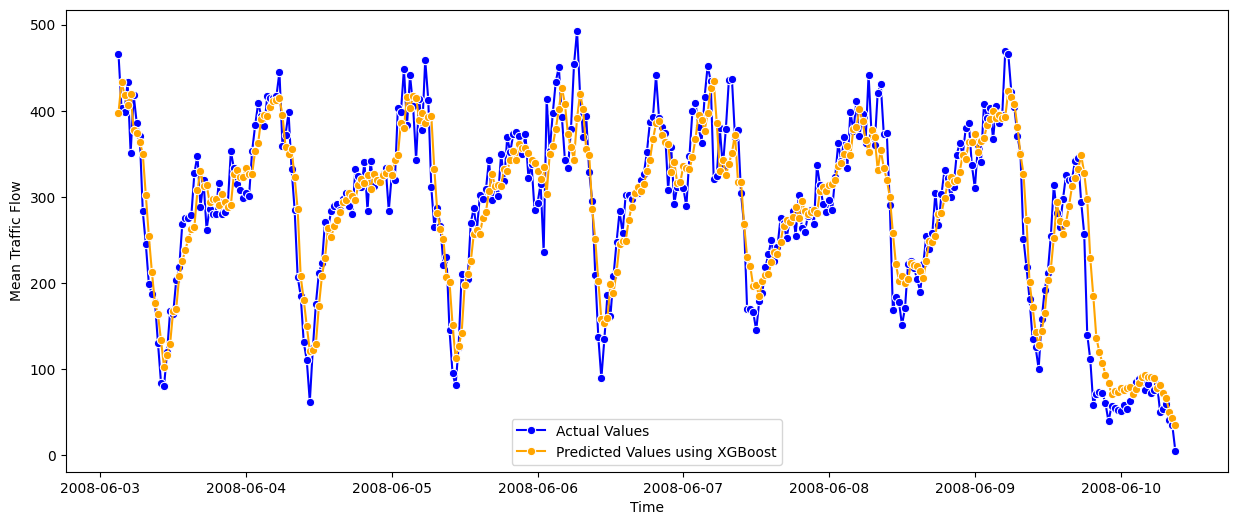

In [123]:
# Select relevant columns from the 'test' DataFrame
select = test[['Time Column','Traffic Flow']]

# Add a new column 'Predictions LSTM' to the 'select' DataFrame containing the LSTM predicted values
select['Predictions XGBoost'] = y_pred_xgboost

# Print the average traffic flow on all paths grouped by timestamp
grouped_by_timestamps = select[['Traffic Flow', 'Predictions XGBoost']].groupby(select['Time Column']).sum()
grouped_by_timestamps = pd.DataFrame(grouped_by_timestamps, index=grouped_by_timestamps.index)

# Create a figure
plt.figure(figsize=(15, 6))

# Plotting actual values in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Traffic Flow',
             data=grouped_by_timestamps,
             color='blue', 
             marker='o',
             alpha=1, 
             label='Actual Values')

# Plotting predicted values using LSTM in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Predictions XGBoost',
             data=grouped_by_timestamps,
             color='orange', 
             marker='o',
             alpha=1, 
             label='Predicted Values using XGBoost')

# Set the x-axis label
plt.xlabel('Time')

# Set the y-axis label
plt.ylabel('Mean Traffic Flow')

# Add a legend to the plot
plt.legend(loc='lower center')

# Display the plot
plt.show()

In [124]:
# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.287957981533663
RMSE score: 2.289045063638271


**Train LSTM for time series forecasting**

Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM Recurrent Neural Network model.

In [125]:
# Scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [126]:
# Create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [127]:
# Create 3D test set for LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [128]:
# Define LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(25, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(12, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(6, activation='linear'))
model.add(Dense(3, activation='linear'))

# Output layer
model.add(Dense(trainY.shape[1]))

# Add early stopping mechanism
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

In [129]:
# Compile LSTM model
model.compile(optimizer='adam', loss='mse')

In [130]:
# Fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 12s 74ms/step - loss: 0.0062 - val_loss: 0.0020
Epoch 2/50
100/100 [==============================] - 7s 70ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 3/50
100/100 [==============================] - 7s 68ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 4/50
100/100 [==============================] - 7s 70ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 5/50
100/100 [==============================] - 7s 68ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 6/50
100/100 [==============================] - 6s 64ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 7/50
100/100 [==============================] - 8s 80ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 8/50
100/100 [==============================] - 7s 70ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 9/50
100/100 [==============================] - 7s 71ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 10/50
100/100 [==============================] - 7s 72ms/step - loss: 0.0018 - val_l

In [131]:
# Evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

1091/1091 [==============================] - 10s 9ms/step - loss: 0.0010
Test Loss: 0.0010463545331731439


In [132]:
# Predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

1091/1091 [==============================] - 10s 9ms/step


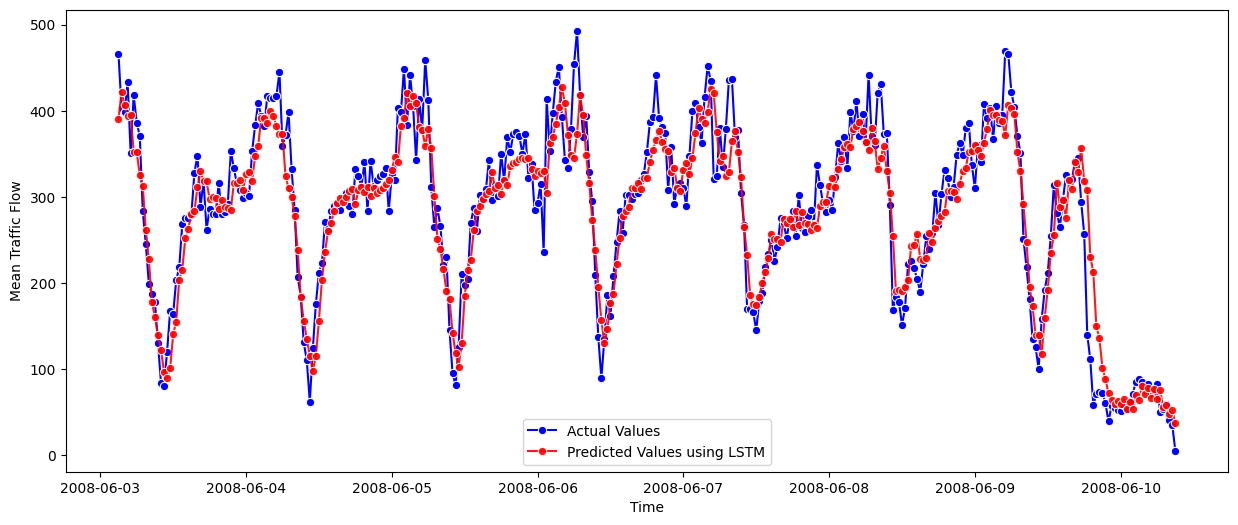

In [133]:
# Select relevant columns from the 'test' DataFrame
select = test[['Time Column','Traffic Flow']]

# Add a new column 'Predictions LSTM' to the 'select' DataFrame containing the LSTM predicted values
select['Predictions LSTM'] = y_pred_lstm

# Print the average traffic flow on all paths grouped by timestamp
grouped_by_timestamps = select[['Traffic Flow', 'Predictions LSTM']].groupby(select['Time Column']).sum()
grouped_by_timestamps = pd.DataFrame(grouped_by_timestamps, index=grouped_by_timestamps.index)

# Create a figure
plt.figure(figsize=(15, 6))

# Plotting actual values in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Traffic Flow',
             data=grouped_by_timestamps,
             color='blue', 
             marker='o',
             alpha=1, 
             label='Actual Values')

# Plotting predicted values using LSTM in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Predictions LSTM',
             data=grouped_by_timestamps,
             color='red', 
             marker='o',
             alpha=0.9, 
             label='Predicted Values using LSTM')

# Set the x-axis label
plt.xlabel('Time')

# Set the y-axis label
plt.ylabel('Mean Traffic Flow')

# Add a legend to the plot
plt.legend(loc='lower center')

# Display the plot
plt.show()

Evaluate the LSTM model

In [134]:
# Calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  1.251036754753067
RMSE LSTM score: 2.2643186604016505


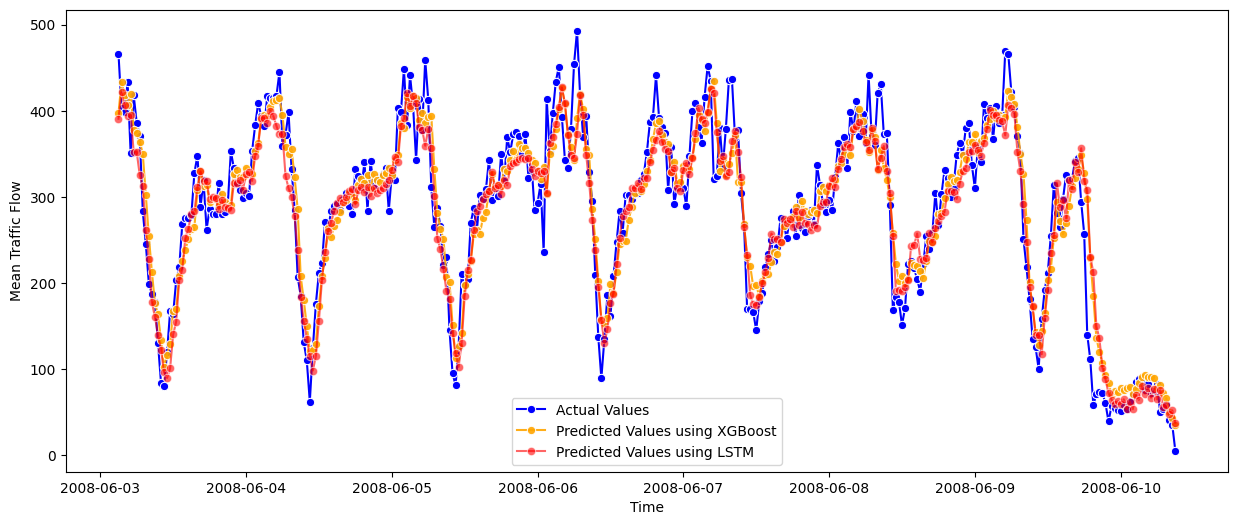

In [135]:
# Select relevant columns from the 'test' DataFrame
select = test[['Time Column','Traffic Flow']]

# Add a new column 'Predictions XGBoost' to the 'select' DataFrame containing the XGBoost predicted values
select['Predictions XGBoost'] = y_pred_xgboost

# Add a new column 'Predictions LSTM' to the 'select' DataFrame containing the LSTM predicted values
select['Predictions LSTM'] = y_pred_lstm

# Print the average traffic flow on all paths grouped by timestamp
grouped_by_timestamps = select[['Traffic Flow', 'Predictions XGBoost', 'Predictions LSTM']].groupby(select['Time Column']).sum()
grouped_by_timestamps = pd.DataFrame(grouped_by_timestamps, index=grouped_by_timestamps.index)

# Create a figure
plt.figure(figsize=(15, 6))

# Plotting actual values in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Traffic Flow',
             data=grouped_by_timestamps,
             color='blue', 
             marker='o',
             alpha=1, 
             label='Actual Values')

# Plotting predicted values using XGBoost in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Predictions XGBoost',
             data=grouped_by_timestamps,
             color='orange', 
             marker='o',
             alpha=0.9, 
             label='Predicted Values using XGBoost')

# Plotting predicted values using LSTM in the test set
sns.lineplot(x=grouped_by_timestamps.index,
             y='Predictions LSTM',
             data=grouped_by_timestamps,
             color='red', 
             marker='o',
             alpha=0.6, 
             label='Predicted Values using LSTM')

# Set the x-axis label
plt.xlabel('Time')

# Set the y-axis label
plt.ylabel('Mean Traffic Flow')

# Add a legend to the plot
plt.legend(loc='lower center')

# Display the plot
plt.show()

In [136]:
# Save XGBoost model to a file
reg.save_model('xgboost_traffic_flow_length-'+str(lookback)+'.model')

In [137]:
# Save the model
model.save("Models/LSTM-length-"+str(lookback)+".h5")